# Path

In [1]:
import scipy as sp
import pandas as pd
import numpy as np
import importlib
import lftmodels
import lftlib
import matplotlib.pyplot as plt
import math
import lmfit
import lftfit
import diagnosis
import re
import pathinc
import entity_recognition_liver
import demographics
import procedure
import encounters
import physical
import meds
from lmfit import Model

from collections import Counter
pd.set_option('display.max_columns', 350)
pd.set_option('display.max_rows', 300)
#pd.set_option('display.max_colwidth', None)
#pd.reset_option('^display.', silent=True)

## Current version

In [2]:
# LOAD PATH
path_df_liv = pathinc.load_RPDR_path_multiple('/Users/pkc17/MGH/RPDR_files/Liver/',
                                  'HK961_20210303_135834_Pat.txt', delimiter='|', datetime_col='Report_Date_Time')

Reading from : /Users/pkc17/MGH/RPDR_files/Liver/2-1/HK961_20210303_135834_Pat_multiline_corrected.txt
Reading from : /Users/pkc17/MGH/RPDR_files/Liver/2-2/HK961_20210303_135834_Pat_multiline_corrected.txt
Reading from : /Users/pkc17/MGH/RPDR_files/Liver/2-3/HK961_20210303_135834_Pat_multiline_corrected.txt
Reading from : /Users/pkc17/MGH/RPDR_files/Liver/2-4/HK961_20210303_135834_Pat_multiline_corrected.txt


In [3]:
# Truncate final dx

%time path_df2_liv = pathinc.truncate_finaldx(path_df_liv.copy(), update=True)

Truncating to only final diagnosis...
Updating input path dataframe with truncated path reports
CPU times: user 5min 45s, sys: 1.53 s, total: 5min 47s
Wall time: 5min 48s


In [4]:
# Truncate extra details

%time path_df3_liv = pathinc.truncate_lower(path_df2_liv.copy(), update=True)

Updating input path dataframe with truncated path reports
CPU times: user 2min 14s, sys: 457 ms, total: 2min 14s
Wall time: 2min 14s


In [5]:
# Filter liver biopsies

%time path_df4_liv = pathinc.is_liver_biopsy(path_df3_liv.copy(), update=True)

Updating input path dataframe with truncated MGH, BWH path reports
Done. | Status: 67821 reports with likely liver biopsy, 435223 reports likely not a liver biopsy
CPU times: user 2min 55s, sys: 1.37 s, total: 2min 57s
Wall time: 2min 57s


In [399]:
# path_df4_liv.to_csv('/Users/pkc17/MGH/Processed files/path_df4_liv.csv')
# path_df4_liv = pd.read_csv('/Users/pkc17/MGH/Processed files/path_df4_liv.csv', index_col=0)

In [ ]:
importlib.reload(entity_recognition_liver)

In [6]:
%time path_df5_liv = entity_recognition_liver.is_liver_disease(path_df4_liv.copy(), update=True)

Updating input path dataframe
CPU times: user 1h 7min 58s, sys: 37.8 s, total: 1h 8min 36s
Wall time: 1h 8min 55s


In [7]:
path_df5_liv = path_df5_liv.sort_values(['EMPI','datetime'])

In [2]:
# path_df5_liv.to_pickle("/Users/pkc17/MGH/Processed files/path_df5_liv.pkl")  
path_df5_liv = pd.read_pickle("/Users/pkc17/MGH/Processed files/path_df5_liv.pkl") 

In [8]:
del path_df_liv, path_df2_liv, path_df3_liv

In [9]:
# path_df5_liv.to_csv('/Users/pkc17/MGH/Processed files/path_df5_liv.csv')
# path_df5_liv = pd.read_csv('/Users/pkc17/MGH/Processed files/path_df5_liv.csv', index_col=0, low_memory=False)

# NegSpacy

## Model

In [3]:
import spacy
from negspacy.negation import Negex
from negspacy.termsets import termset

ts = termset("en_clinical")

#from spacy.pipeline import EntityRuler

corpus = 'en_core_sci_lg' # en_ner_bc5cdr_md, en_core_sci_md, en_core_sci_lg

# en = phrases for general english language text
# en_clinical DEFAULT = adds phrases specific to clinical domain to general english
# en_clinical_sensitive = adds additional phrases to help rule out historical and possibly irrelevant entities

config={
        "neg_termset":{
            "pseudo_negations": ts.terms['pseudo_negations'] + ['not limited to', 'not excluded', 'needs to be ruled out', 'although not apparent'],
            "preceding_negations": ts.terms['preceding_negations'] + ['negative', 'insufficient', 'without evidence of', 'rather than', 'precludes'], #'grade 0'
            "following_negations": ts.terms['following_negations'] + ['negative', 'ruled out', 'less likely', 'is not', 'are not', 'does not', 'have not', 'was not', 'were not', 'absent', 'grade 0', 'not present'],
            "termination": ts.terms['termination'] + ['note:', ';', ', negative', ',negative'] #'negative for', 'with'
        }
    }

nlp_2 = spacy.load(corpus) 

# ruler = EntityRuler(nlp_2, overwrite_ents=True)

# patterns = [
#     {"label": "ENTITY", "pattern": [{"LOWER": "chronic inflammation"}]}
#         ]
# ruler.add_patterns(patterns)

nlp_2.add_pipe(
    "negex",
    config = config
)

In [803]:
text=''' 
"Findings:
     The perianal and digital rectal examinations were normal. In setting of 
     active flare of proctitis, retroflexed view of the rectum was deferred.
     Inflammation characterized by adherent blood, congestion (edema), 
     erosions, erythema and granularity was found in a continuous and 
     circumferential pattern from the rectum to the sigmoid colon. This was 
     mild  moderate in severity. Biopsies were taken with a cold forceps 
     for histology from the rectum and distal sigmoid colon. Estimated blood 
     loss was minimal.
                                                                               
Impression:               - Mild to moderate flare of ulcerative 
                          proctosigmoiditis. Biopsied to rule out CMV and to 
                          assess severity of ulcerative colitis."
     
     '''.lower()

In [804]:
importlib.reload(entity_recognition_liver)

<module 'entity_recognition_liver' from '/Users/pkc17/MGH/RPDR/entity_recognition_liver.py'>

In [802]:
print(entity_recognition_colon.entities(text, nlp_2))

"findings: the perianal and digital rectal examinations were normal
in setting of actv flare of proctitis, retroflexed view of the rectum was deferred
inflammation characterized by adherent-blood, congestion (edema), erosions, erythema and granularity was found in a continuous and circumferential pattern from the rectum to the sigmoid colon
inflammation was mild and moderate in severity
biopsies were taken with a cold forceps for histology from the rectum and distal sigmoid colon
estimated blood loss was minimal
impression:
mild and to moderate flare of ulcerative proctosigmoiditis
biopsied to rule out cmv and to assess severity of ulcerativecolitis
"
findings True
perianal True
digital rectal examinations True
active True
flare True
proctitis True
retroflexed view True
rectum True
inflammation True
characterized True
adherent-blood True
congestion True
edema True
erosions True
erythema True
granularity True
continuous True
circumferential pattern True
rectum True
sigmoid colon True
in

In [793]:
doc = nlp_2(text)

In [795]:
for e in doc.ents:
    print(e.text, e._.negex)

iron True
intrahepatocytic d-pas globules True
mallory's True
hyaline
      True
ballooning degeneration False
satellitosis False
zone 2 False
consistent with False
toxic/metabolic liver disease False
non-alcoholic steatohepatitis False
copper stain False
addendum False


## Keyword test

In [857]:
importlib.reload(entity_recognition_liver)

<module 'entity_recognition' from '/Users/pkc17/MGH/RPDR/entity_recognition.py'>

In [81]:
filter_1 = path_df4_liv['is_liver_biopsy']==True

In [401]:
filter_r1 = path_nafld['Report_Text'].str.contains('lobular activity', case=False, na=False)
filter_r2 = path_nafld['Report_Text'].str.contains('activity', case=False, na=False)

In [97]:
filter_2 = path_df5_liv['Report_Text'].str.contains('):', case=False, na=False, regex=False)

In [7]:
for index, row in path_df5_liv[(path_df5_liv['steatosis']==True)&filter_2].sample(100).iterrows():
    
#     bool_1 = bool(re.search(r'\b(?:portal\W+(?:\w+\W+){0,5}?septa|septa\W+(?:\w+\W+){0,5}?portal)\b', path_df4_liv.loc[index, 'Report_Text']))
#     bool_2 = bool(re.search(r'\b(?:portal\W+(?:\w+\W+){0,5}?septal|septal\W+(?:\w+\W+){0,5}?portal)\b', path_df4_liv.loc[index, 'Report_Text']))
#     bool_3 = bool(re.search(r'\b(?:portal\W+(?:\w+\W+){0,5}?septae|septae\W+(?:\w+\W+){0,5}?portal)\b', path_df4_liv.loc[index, 'Report_Text']))

#      bool_2 = bool(re.search(r'\b(?:fibrosis\W+(?:\w+\W+){0,13}?stage|stage\W+(?:\w+\W+){0,10}?fibrosis)\b', path_df4_liv.loc[index, 'Report_Text']))
#      bool_3 = bool(re.search(r'\b(?:1a\W+(?:\w+\W+){0,5}?stage|stage\W+(?:\w+\W+){0,5}?1a)\b', path_df4_liv.loc[index, 'Report_Text']))

#      if 'zone-3 inflammation' not in entiy_result:
#          continue
#     if not (bool_1|bool_2|bool_3):
#         continue

    entiy_result = entity_recognition_liver.entities(path_df4_liv.loc[index, 'Report_Text'], nlp_2)
    print('#####################################', end='\n\n')
    print(index, end='\n\n')
    print('MRN:', row['MRN'], end='\n\n')
    print('Report_Number:', row['Report_Number'], end='\n\n')
    print('Report_Description:', row['Report_Description'], end='\n\n')
    print('Report_Status:', row['Report_Status'], end='\n\n')
    print(row['MRN_Type'], end='\n\n')
    print(path_df4_liv.loc [index, 'datetime'], end='\n\n')
    print(path_df4_liv.loc [index, 'Report_Text'], end='\n\n')
    print(entiy_result, end='\n\n')
    print(path_df5_liv.loc[index, 'disease_list'])
    print('#####################################', end='\n\n')

# Function test

In [734]:
fil_is_liver_biopsy = path_df5_liv['is_liver_biopsy']==True
fil_steatosis = path_df5_liv['steatosis']==True
fil_ballooning = path_df5_liv['ballooning']==True
fil_inflammation = path_df5_liv['inflammation']==True

fil_lobular_inflammation = path_df5_liv['lobular_inflammation']==True
fil_zone3_inflammation = path_df5_liv['zone3_inflammation']==True
fil_lobular_hepatitis = path_df5_liv['lobular_hepatitis']==True
fil_zone3_hepatitis = path_df5_liv['zone3_hepatitis']==True


In [690]:
filter_1 = path_df5_liv['is_liver_biopsy']==True
filter_2_1 = path_df5_liv['Report_Text'].str.contains('steatosis|steatotic', case=False, na=False)
filter_2_2 = path_df5_liv['Report_Text'].str.contains('<5%|< 5%', case=False, na=False)
filter_3_1 = path_df5_liv['Report_Text'].str.contains('balloon', case=False, na=False)
filter_3_2 = path_df5_liv['Report_Text'].str.contains('baloon', case=False, na=False)
filter_3_3 = path_df5_liv['Report_Text'].str.contains('ballon', case=False, na=False)
filter_4_1 = path_df5_liv['Report_Text'].str.contains('inflammation', case=False, na=False)
filter_4_2 = path_df5_liv['Report_Text'].str.contains('inflammatory', case=False, na=False)
filter_4_3 = path_df5_liv['Report_Text'].str.contains('lobular', case=False, na=False)
filter_4_4 = path_df5_liv['Report_Text'].str.contains('portal', case=False, na=False)
filter_5_1 = path_df5_liv['Report_Text'].str.contains('hepatitis|hepatic', case=False, na=False)
filter_6_1 = path_df5_liv['Report_Text'].str.contains('zone', case=False, na=False)
filter_6_2 = path_df5_liv['Report_Text'].str.contains('zone 3|zone3', case=False, na=False)
filter_6_2 = path_df5_liv['Report_Text'].str.contains('zone 3|zone3', case=False, na=False)

filter_7_1 = path_df5_liv['Report_Text'].str.contains('fibrosis', case=False, na=False)
filter_8_1 = path_df5_liv['Report_Text'].str.contains('autoimmune hepatitis', case=False, na=False)
filter_8_2 = path_df5_liv['Report_Text'].str.contains('AIH', case=False, na=False)

In [871]:
for index, row in cov_outcomes_df[filter_ss].sample(50).iterrows():
#     if 'zone-3 inflammation' not in entiy_result:
#         continue
#     if not len(path_df5_liv.loc[index, 'disease_list'])==0:
#         continue
#     if not bool(re.search(r'\b(?:lobular\W+(?:\w+\W+){0,3}?inflammation|inflammation\W+(?:\w+\W+){0,2}?lobular)\b', path_df4_liv.loc[index, 'Report_Text'])):
#         continue
    entiy_result = entity_recognition_liver.entities(row['Report_Text'], nlp_2)
    print('#####################################', end='\n\n')
    print(index, end='\n\n')
    print(row['MRN_Type'], end='\n\n')
    print(row['Report_Text'], end='\n\n')
#     print(path_df_liv.loc[(path_df_liv['EMPI']==row['EMPI'])&(path_df_liv['Report_Number']==row['Report_Number']),
#                           'Report_Text'].item(), end='\n\n')
    print(entiy_result, end='\n\n')
    print(row['disease_list'], end='\n\n')
    print('#####################################', end='\n\n')

#####################################

1940

MGH

     FINAL DIAGNOSIS:
     LIVER, CORE BIOPSY:
     HEPATIC PARENCHYMA WITH NON-SPECIFIC CHANGES.
     
     NOTE:  Focal portal triaditis, minimal spotty necrosis and minimal non zonal
     steatosis are seen.  No iron or intrahepatocytic d-PAS globules are seen or
     fibrosis.  The changes are not diagnostic.
     

diagnosis True
liver True
core biopsy True
hepatic-parenchyma True
changes True
focal portal triaditis True
minimal_spotty necrosis True
minimal_non True
zonal steatosis True
iron False
intrahepatocytic d-pas globules False
fibrosis False
changes False
diagnostic False


['hepatic-parenchyma True', 'zonal steatosis True']

#####################################

#####################################

7360

MGH

     FINAL PATHOLOGIC DIAGNOSIS:
     A. LIVER BIOPSY:  
     Hepatic parenchyma with reactive/regenerative changes, (see note).
     
     Note for part A:  Sections through the liver reveal a mildly nodular hepat

#####################################

457

BWH

DIAGNOSIS:      by ODZE,ROBERT DANIEL,M.D.
LIVER BIOPSY:
     Marked centrilobular cholestasis with hepatocellular and canalicular bile
       deposition.
     Focal bile ductular necrosis is present.
     Focal endothelialitis is present.
     Focal microvesicular steatosis is present.
     No viral inclusions seen.
     No fibrosis or cirrhosis.
     Iron stain shows abundant iron in hepatocytes and Kupffer cells.
     Iron, trichrome, and reticulum stains were examined for the final
       diagnosis.
 
 
NOTE:
The findings are consistent with acute graft vs. host disease.


diagnosis True
odze True
robert daniel True
liver biopsy True
centrilobular True
cholestasis True
hepatocellular True
canalicular True
deposition True
focal_bile ductular necrosis True
focal_endothelialitis True
focal_microvesicular steatosis True
viral inclusions False
fibrosis False
cirrhosis False
iron stain True
abundant True
iron True
hepatocytes True
kupffer-

#####################################

1918

MGH

     FINAL DIAGNOSIS:
     GALLBLADDER, CHOLECYSTECTOMY:
     CHRONIC CHOLECYSTITIS AND CHOLELITHIASIS.
     ONE LYMPH NODE WITH NO DIAGNOSTIC ABNORMALITY RECOGNIZED.
     
     LIVER, WEDGE BIOPSY:
     SUBCAPSULAR HEPATIC PARENCHYMA WITH MILD MIXED MICRO- AND MACROVESICULAR
     STEATOSIS.  (SEE NOTE).
     
     NOTE:  Trichrome stain does not reveal pathologic fibrosis.  There is no
     evidence of steatohepatitis.
     No iron or intrahepatocytic d-PAS globules are seen.

diagnosis True
gallbladder True
cholecystectomy True
cholecystitis True
cholelithiasis True
lymph node True
diagnostic abnomality False
liver True
wedge biopsy True
subcapsular True
hepatic-parenchyma True
mild_mixed-micro- True
macrovesicular steatosis True
trichrome stain False
pathologic fibrosis False
evidence False
steatohepatitis False
iron False
intrahepatocytic d-pas globules False


['hepatic-parenchyma True', 'macrovesicular steatosis True']

##########

#####################################

1795

MGH

     FINAL DIAGNOSIS:
     LIVER, CORE BIOPSY:
     MILD ZONE 3 STEATOSIS WITH CHRONIC PORTAL TRIADITIS.
     
     NOTE: No iron or intrahepatocytic d-PAS globules are seen. There is no evidence
     of  hepatitis or scarring.

diagnosis True
liver True
core biopsy True
mild_zone-3 steatosis True
portal triaditis True
iron False
intrahepatocytic d-pas globules False
evidence False
hepatitis False
scarring False


['mild_zone-3 steatosis True']

#####################################

#####################################

6015

BWH

PATHOLOGIC DIAGNOSIS:

SPECIMEN DESIGNATED "LIVER MASS, CORE BIOPSY":

Liver parenchyma with focal macrovesicular steatosis. See note.

NOTE: Clinical/radiologic correlation is needed to determine if the sample is
representative.

Per the radiologist's procedure note, the hepatic segment 6 mass was targeted
in this FNA and core biopsy procedure.

See also FNA BC16-27234.



pathologic diagnosis True
specimen

#####################################

6552

MGH

     FINAL PATHOLOGIC DIAGNOSIS:
     A. LIVER BIOPSY, RIGHT LOBE NONFOCAL:  
     Grade 2 steatosis without steatohepatitis and no fibrosis (stage 0). 
     
     Note:  The biopsy shows grade 2 of 3 steatosis (33-66%) predominantly in zones 2
     and 3.  Mallory bodies are present.  Lobular inflammation is absent.  Portal
     tracts show mild inflammation.  Portal tracts show no or minimal ductular
     duplication.  Trichrome stain shows no fibrosis (modified Brunt stage 0 of 4). 
     Iron stain shows no stainable iron and PASD stain shows no PASD positive
     globules.
     
     
     

pathologic diagnosis True
liver biopsy True
right lobe nonfocal True
grade 2 steatosis True
steatohepatitis False
fibrosis stage: 0.0/4.0 False
stage False
biopsy True
grade True
steatosis True
zones True
mallory bodies True
lobular-inflammation False
portal tract True
mild True
portal inflammation True
portal tract True
minimal_ductular duplica

#####################################

3255

BWH

PATHOLOGIC DIAGNOSIS:

A. LIVER, CORE BIOPSY:
     Moderate canalicular cholestasis (see NOTE).
Portal areas with bile ductular proliferation, cholangiolitis, prominent
eosinophils, and edema.
Differential diagnosis includes large duct obstruction and drug effect.
Mild macrovesicular steatosis.
Slight Kupffer cell iron.
No significant fibrosis.
Iron, trichrome, and reticulin stains were examined for the final diagnosis.

NOTE: Clinical correlation is needed.  Dr. R. Odze has reviewed select sections
and concurs.


pathologic diagnosis True
liver True
core biopsy True
moderate_canalicular cholestasis True
portal area True
bile ductular True
proliferation True
cholangiolitis True
eosinophils True
edema True
differential diagnosis True
duct obstruction True
drug effect True
mild_macrovesicular steatosis True
significant False
fibrosis False
iron True
trichrome True
reticulin stains True
diagnosis True
clinical correlation True
odze True
re

# Import files

## Demographics

In [9]:
importlib.reload(demographics)

<module 'demographics' from '/Users/pkc17/MGH/RPDR/demographics.py'>

In [4]:
dem_df_liv = demographics.load_RPDR_dem_multiple('/Users/pkc17/MGH/RPDR_files/Liver/',
                                  'HK961_20210303_135834_Dem.txt', delimiter='|')

dem_df_liv = dem_df_liv.loc[~(dem_df_liv['Date_of_Birth']==('1901-01-01')), :]

dem_df_liv['EMPI'] = dem_df_liv['EMPI'].astype(str)
dem_df_liv['Date_of_Birth'] = pd.to_datetime(dem_df_liv['Date_of_Birth'], errors='coerce')
dem_df_liv['Date_Of_Death'] = pd.to_datetime(dem_df_liv['Date_Of_Death'], errors='coerce')
dem_df_liv['Race'] = dem_df_liv['Race'].str.lower()

In [5]:
filter_1 = (dem_df_liv['Race'].str.startswith('african american', na=False) | 
            dem_df_liv['Race'].str.startswith('black', na=False))
dem_df_liv.loc[filter_1, 'Race'] = 'African American'

filter_2 = (dem_df_liv['Race'].str.startswith('american indian', na=False))
dem_df_liv.loc[filter_2, 'Race'] = 'American Indian'

filter_3 = (dem_df_liv['Race'].str.startswith('asian', na=False) | 
            dem_df_liv['Race'].str.startswith('indian', na=False))
dem_df_liv.loc[filter_3, 'Race'] = 'Asian'

filter_4 = (dem_df_liv['Race'].str.startswith('dominican', na=False) | 
            dem_df_liv['Race'].str.startswith('hispanic', na=False))
dem_df_liv.loc[filter_4, 'Race'] = 'Hispanic'

filter_5 = (dem_df_liv['Race'].str.startswith('hawaiian', na=False))
dem_df_liv.loc[filter_5, 'Race'] = 'Hawaiian or other pacific islander'

filter_6 = (dem_df_liv['Race'].str.startswith('european', na=False) | 
            dem_df_liv['Race'].str.startswith('white', na=False))
dem_df_liv.loc[filter_6, 'Race'] = 'Caucasian'

filter_7 = (dem_df_liv['Race'].str.startswith('not recorded', na=False))
dem_df_liv.loc[filter_7, 'Race'] = 'Not recorded'

filter_8 = (dem_df_liv['Race'].str.startswith('other', na=False))
dem_df_liv.loc[filter_8, 'Race'] = 'Other'

## Diagnosis

In [13]:
importlib.reload(diagnosis)

<module 'diagnosis' from '/Users/pkc17/MGH/RPDR/diagnosis.py'>

In [6]:
dia_df_liv = diagnosis.load_RPDR_diag_multiple('/Users/pkc17/MGH/RPDR_files/Liver/',
                                'HK961_20210303_135834_Dia.txt', delimiter='|')

In [7]:
dia_df_liv = dia_df_liv.sort_values(['EMPI', 'datetime']).copy()

### Alcohol exclusions

In [8]:
filter_code_icd9 = dia_df_liv['Code'].str.startswith(('357.5', '425.5', '535.3', '980.1', '980.9',
           '571.0', '571.1', '571.2', '571.3', '535.3', '305.0', '291', '303', 'T51.0', 'T51.9'), na=False)

filter_icd9 = (filter_code_icd9) & (dia_df_liv['Code_Type']=='ICD9')

In [9]:
filter_code_icd10 = dia_df_liv['Code'].str.startswith(('E24.4', 'G62.1', 'I42.6', 'K29.20', 'G31.2', 'G72.1', 
        'K86.0', 'T51.0', 'T51.9', 'Y57.3', 'X65', 'Z50.2', 'Z71.4', 'Z72.1', 'F10', 'K70', 'K85.2', 
        'K29.2', 'Z71.4'), na=False)

filter_icd10 = (filter_code_icd10) & (dia_df_liv['Code_Type']=='ICD10')

In [10]:
filter_lmr = (dia_df_liv['Code'].isin(['LPA13', 'LPA12', 'LPA1535'])) & (dia_df_liv['Code_Type']=='LMR')

filter_drg = (dia_df_liv['Code'].isin(['202', '521', '433'])) & (dia_df_liv['Code_Type']=='DRG')

filter_aprdrg = (dia_df_liv['Code'].isin(['280', '770', '775'])) & (dia_df_liv['Code_Type']=='APRDRG')

filter_oncall = (dia_df_liv['Code'].isin(['YHCJ1', 'YHAD5', 'QJPX3'])
                 | (dia_df_liv['Diagnosis_Name'] == 'B - Alcoholic cirrhosis-Oncall')
                 | (dia_df_liv['Diagnosis_Name'] == 'C - Alcohol use status: major-Oncall')
                 | (dia_df_liv['Diagnosis_Name'] == 'D - Alcohol use status: abuse-Oncall')
                ) & (dia_df_liv['Code_Type']=='Oncall')

filter_dsm4 = (dia_df_liv['Code'].str.startswith(('305.0', '303.9.1'))) & (dia_df_liv['Code_Type']=='DSM4')

filter_nonicd = (filter_lmr|filter_drg|filter_aprdrg|filter_oncall|filter_dsm4)

In [11]:
filter_alc = (filter_icd9|filter_icd10|filter_nonicd)

In [12]:
dia_df_liv_subset = dia_df_liv[filter_alc].copy()

In [13]:
dia_df_liv_subset['alcohol_history'] = True

In [21]:
dia_df_liv_subset.drop(dia_df_liv_subset.columns.difference(['EMPI','datetime','alcohol_history']), 1, inplace=True)

In [260]:
# dia_df_liv.loc[filter_alc_val&~filter_alc&~((dia_df_liv['Code_Type']=='ICD10')|(dia_df_liv['Code_Type']=='ICD9')), ['Diagnosis_Name', 'Code', 'Code_Type']].value_counts()

## Medications

In [14]:
meds_df_liv = meds.load_RPDR_meds_multiple('/Users/pkc17/MGH/RPDR_files/Liver/',
                                'HK961_20210303_135834_Med.txt', delimiter='|')
meds_df_liv = meds_df_liv.sort_values(['EMPI', 'datetime'])

In [15]:
filter_meds_1 = meds_df_liv['Medication'].str.contains('Methotrexate', case=False, na=False)
filter_meds_2 = meds_df_liv['Medication'].str.contains('Amiodarone', case=False, na=False)
filter_meds_3 = meds_df_liv['Medication'].str.contains('Prednisone', case=False, na=False)

In [16]:
meds_df_liv_subset = meds_df_liv[filter_meds_1|filter_meds_2].copy()

In [17]:
prednisone = meds_df_liv[filter_meds_3].copy()
prednisone = prednisone.sort_values(['EMPI', 'datetime'])

# Timediff for each EMPI
gs = prednisone.groupby(['EMPI'])['datetime']
prednisone['time_diff'] = gs.diff().fillna(pd.Timedelta(seconds=0)).dt.days

# Select anyone that used prednisone more than 30 days apart
pred_EMPIs = prednisone.loc[prednisone['time_diff']>30, 'EMPI'].drop_duplicates()
prednisone = prednisone[prednisone['EMPI'].isin(pred_EMPIs)]

In [18]:
meds_df_liv_subset = meds_df_liv_subset.append(prednisone, ignore_index=True)
meds_df_liv_subset = meds_df_liv_subset.sort_values(['EMPI', 'datetime'])

In [19]:
meds_df_liv_subset['medications_history'] = True

In [20]:
meds_df_liv_subset = meds_df_liv_subset.loc[:,['EMPI', 'datetime', 'medications_history']].copy()

## Encounter

In [26]:
importlib.reload(encounters)

<module 'encounters' from '/Users/pkc17/MGH/RPDR/encounters.py'>

In [22]:
enc_df_liv = encounters.load_RPDR_enc_multiple('/Users/pkc17/MGH/RPDR_files/Liver/',
                                'HK961_20210303_135834_Enc.txt', delimiter='|')

## Procedure

In [23]:
prc_df_liv = procedure.load_RPDR_prc_multiple('/Users/pkc17/MGH/RPDR_files/Liver/',
                                               'HK961_20210303_135834_Prc.txt', delimiter='|')

Reading from : /Users/pkc17/MGH/RPDR_files/Liver/2-1/HK961_20210303_135834_Prc_multiline_corrected.txt
Reading from : /Users/pkc17/MGH/RPDR_files/Liver/2-2/HK961_20210303_135834_Prc_multiline_corrected.txt
Reading from : /Users/pkc17/MGH/RPDR_files/Liver/2-3/HK961_20210303_135834_Prc_multiline_corrected.txt
Reading from : /Users/pkc17/MGH/RPDR_files/Liver/2-4/HK961_20210303_135834_Prc_multiline_corrected.txt


## Physical

In [39]:
importlib.reload(physical)

<module 'physical' from '/Users/pkc17/MGH/RPDR/physical.py'>

In [24]:
phy_df_liv = physical.load_RPDR_phy_multiple('/Users/pkc17/MGH/RPDR_files/Liver/',
                                'HK961_20210303_135834_Phy.txt', delimiter='|')

## Radiology

In [25]:
rad_df_liv = diagnosis.load_RPDR_diag_multiple('/Users/pkc17/MGH/RPDR_files/Liver/',
                                'HK961_20210303_135834_rdt.txt', delimiter='|')

In [29]:
ct_modes = ['CT', 'PET/CT', 'CT.ANGIO']
filter_ct_modes = rad_df_liv['Mode'].isin(ct_modes)

In [30]:
ct_groups = ['ABD', 'SPLV']
filter_ct_groups = rad_df_liv['Group'].isin(ct_groups)

In [31]:
filter_rd_1 = rad_df_liv['Test_Description'].str.contains('CT', case=True)
filter_rd_2 = rad_df_liv['Test_Description'].str.contains('Abd', case=False)
filter_rd_3 = rad_df_liv['Test_Description'].str.contains('Pel', case=False)

In [297]:
(
    rad_df_liv
    .loc[
        ((filter_rd_2|filter_rd_3)&filter_rd_1)|(filter_ct_modes&filter_ct_groups),
        ['Mode', 'Group', 'Test_Description']]
    .drop_duplicates()
    .reset_index(drop=True)
    .to_csv('/Users/pkc17/MGH/CT Scan Cirrhosis/rad_df_liv_subset.csv')
)

In [259]:
Counter(rad_df_liv.loc[(filter_rd_2|filter_rd_3)&filter_rd_1, 'Group']).most_common()

[('ABD', 55871),
 ('SPLV', 39471),
 ('UNCLASSIFIED', 15480),
 ('LEXTR', 15216),
 ('GPS', 454),
 ('CHEST', 60),
 ('COLON', 13),
 ('URT', 1)]

# Chart Review

In [811]:
cov_outcomes_df.loc[cov_outcomes_df['Simple_Steatosis_lab']==True, 'EMPI'].sample(10)

2110    102833173
7208    106767633
4220    102943101
1290    100343654
681     101802081
5284    109876083
6481    104986496
932     106287381
4375    103412398
1184    100930422
Name: EMPI, dtype: object

In [814]:
cov_outcomes_df.loc[(cov_outcomes_df['fibrosis_stage_4']==0) &
                    (cov_outcomes_df['NASH_lab']==True), 'EMPI'].sample(10)

2647    100912896
4423    101819808
2696    103475800
3170    104666965
4985    108909394
5734    105085503
5027    100263406
3814    100397441
7395    108835575
6184    101116461
Name: EMPI, dtype: object

In [812]:
cov_outcomes_df.loc[(cov_outcomes_df['fibrosis_stage_4']==1), 'EMPI'].sample(10)

3439    105696279
3497    107019347
7119    113391323
7402    102719405
5626    109721174
4114    102249638
7152    104633012
3593    104000098
5556    104841016
6648    102535636
Name: EMPI, dtype: object

In [813]:
cov_outcomes_df.loc[(cov_outcomes_df['fibrosis_stage_4']==0), 'EMPI'].sample(10)

7707    113275702
5242    111112950
6994    100175138
3192    104727379
6699    102854904
2871    101243105
6666    107106945
3170    104666965
2615    100079786
7065    100282059
Name: EMPI, dtype: object

In [815]:
random_empi = '102833173'

In [820]:
dem_df_liv[dem_df_liv['EMPI']==random_empi]

,EMPI,EPIC_PMRN,MRN_Type,MRN,Gender,Date_of_Birth,Age,Language,Race,Marital_status,Religion,Is_a_veteran,Zip_code,Country,Vital_status,Date_Of_Death
57476,102833173,1.006372e+10,"PMRN, MGH, BWH, FH, NSM","10063721293, 4346420, 18745315, 01211698, 0052...",Female,1957-05-07,61,English-ENGLISH,Caucasian,Married-MARRIED,Catholic-CATHOLIC,No,01867,United States-UNITED STATES,Date of Death reported from a Partners Hospital,2019-03-14


In [816]:
path_df5_liv[path_df5_liv['EMPI']==random_empi]

,EMPI,EPIC_PMRN,MRN_Type,MRN,Report_Number,Report_Date_Time,Report_Description,Report_Status,Report_Type,Report_Text,datetime,has_final_diagnosis,final_diagnosis_line,has_lowersec,lowersec_line,lowersec_start_LAFD,is_liver_biopsy,is_liver_biopsy_line,liver_biopsy_LAFD,steatosis,ballooning,inflammation,lobular_inflammation,zone3_inflammation,lobular_hepatitis,zone3_hepatitis,fibrosis,bridging_fibrosis,sinusoidal_fibrosis,portal_fibrosis,periportal_fibrosis,pericellular_fibrosis,perivenular_fibrosis,septal_fibrosis,central_fibrosis,zone3_fibrosis,zone1_fibrosis,centrilob_fibrosis,hepatitis,autoimmune_hepatitis,mallory,pbc,cirrhosis,steatohepatitis,hepatitisa,hepatitisb,hepatitisc,drug_hepatitis,interface_hepatitis,viral_hepatitis,granulomatous_hepatitis,hepatic_parenchyma,hemochromatosis,antitrypsin,cholangitis,wilsons,drug_ind_liv_inj,budd_chiari,alcoholic,carcinoma,methotrexate,ext_hematopoiesis,nafld,nash,fibrosis_stage_4,fibrosis_stage_6,disease_list,transplant
415832,102833173,10063721293,BWH,18745315,C0402999S,1/16/2004 12:00:00 AM,Cytology,Final,PAT,Accession Number: C0402999S ...,2004-01-16 00:00:00,False,,False,,-1.0,False,,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
415831,102833173,10063721293,BWH,18745315,S0428996S,8/13/2004 12:00:00 AM,Surgical Pathology,Final,PAT,"DIAGNOSIS: by KRANE,JEFFREY FRED,M.D.,PH....",2004-08-13 00:00:00,True,"DIAGNOSIS: by KRANE,JEFFREY FRED,M.D.,PH.D.",True,CLINICAL DATA:,7.0,False,,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
415830,102833173,10063721293,BWH,18745315,BC06N05117,1/27/2006 12:00:00 AM,Cytology,Final,PAT,Accession Number: BC06N05117 ...,2006-01-27 00:00:00,False,,False,,-1.0,False,,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
415829,102833173,10063721293,BWH,18745315,BS06N07132,2/17/2006 12:00:00 AM,Surgical Pathology,Final,PAT,"PATHOLOGIC DIAGNOSIS:\n\nSKIN, RIGHT ANTERIOR ...",2006-02-17 00:00:00,True,PATHOLOGIC DIAGNOSIS:,True,CLINICAL DATA:,6.0,False,,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
415826,102833173,10063721293,MGH,4346420,MS06X25912,5/15/2006 12:00:00 AM,Surgical Pathology,Final,PAT,"FINAL DIAGNOSIS:\n LIVER, CORE BIOPSY...",2006-05-15 00:00:00,True,FINAL DIAGNOSIS:,True,"By his/her signature below, the pathologi...",10.0,True,"LIVER, CORE BIOPSY:",1.0,True,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[microvesicular steatosis True],NaN
415828,102833173,10063721293,BWH,18745315,BS07F34171,8/2/2007 12:00:00 AM,Surgical Pathology,Final,PAT,PATHOLOGIC DIAGNOSIS:\n\nA. SPECIMEN DESIGNATE...,2007-08-02 00:00:00,True,PATHOLOGIC DIAGNOSIS:,True,CLINICAL DATA:,7.0,False,,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
415827,102833173,10063721293,BWH,18745315,BC16R08387,3/23/2016 12:00:00 AM,Cytology,Updated,PAT,Accession Number: BC16R08387 ...,2016-03-23 00:00:00,False,,False,,-1.0,False,,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
415825,102833173,10063721293,MGH,4346420,S18-50657,7/27/2018 12:00:00 AM,Surg

In [822]:
dia_df_liv[dia_df_liv['EMPI']==random_empi]

,EMPI,EPIC_PMRN,MRN_Type,MRN,Date,Diagnosis_Name,Code_Type,Code,Diagnosis_Flag,Provider,Clinic,Hospital,Inpatient_Outpatient,Encounter_number,datetime
26258296,102833173,10063721293,BWH,18745315,1/16/2004,Routine general medical examination at a healt...,ICD9,V70.0,Primary,"Sokol, MD, H. Nancy, MD",BPG At 850 Boylston (100),BWH,Outpatient,TSI-BWH-218106600001,2004-01-16
26262462,102833173,10063721293,BWH,18745315,1/16/2004,Screening for malignant neoplasms of the cervix,ICD9,V76.2,NaN,"Sokol MD, Nancy H",Pc-Bpg Brigham Physicians Group (2209),BWH,Outpatient,IDX-BWH-0-7763433,2004-01-16
26266714,102833173,10063721293,NaN,NaN,1/16/2004,Macromastia-LMR 652,LMR,LPA652,NaN,"Brown, MD, Mary Linda, MD,MPH",BPG - Brigham and Women's Physician Group (100),BWH,Outpatient,LMR-PROB-1629353,2004-01-16
26280201,102833173,10063721293,NaN,NaN,1/16/2004,Low back pain-LMR 226,LMR,LPA226,NaN,"Sokol, MD, H. Nancy, MD",BPG - Brigham and Women's Physician Group (100),BWH,Outpatient,LMR-PROB-1629352,2004-01-16
26281878,102833173,10063721293,BWH,18745315,1/16/2004,Routine general medical examination at a healt...,ICD9,V70.0,Primary,"Sokol MD, Nancy H",Pc-Bpg Brigham Physicians Group (2209),BWH,Outpatient,IDX-BWH-0-7763433,2004-01-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26284674,102833173,10063721293,NaN,NaN,3/31/2019,Current or Past History of PHD [DX_ct >= 1],Phenotype,PHD_ICD1,NaN,NaN,not recorded,PHS,not recorded,Phenotypes-102833173-PheNormV1.1,2019-03-31
26284966,102833173,10063721293,NaN,NaN,3/31/2019,Current or Past History of GERD [DX_ct >= 1],Phenotype,GERD_ICD1,NaN,NaN,not recorded,PHS,not recorded,Phenotypes-102833173-PheNormV1.1,2019-03-31
26285053,102833173,10063721293,NaN,NaN,3/31/2019,Current or Past History of ACNE [DX_ct >= 1],Phenotype,ACNE_ICD1,NaN,NaN,not recorded,PHS,not recorded,Phenotypes-102833173-PheNormV1.1,2019-03-31
26285185,102833173,10063721293,NaN,NaN,3/31/2019,Current or Past History of OA [x_NLP_log.postp...,Phenotype,OA_pN0.5,NaN,NaN,not recorded,PHS,not recorded,Phenotypes-102833173-PheNormV1.1,2019-03-31


In [823]:
enc_df_liv[enc_df_liv['EMPI']==random_empi]

,EMPI,EPIC_PMRN,MRN_Type,MRN,Encounter_number,Encounter_Status,Hospital,Inpatient_Outpatient,Service_Line,Attending_MD,Admit_Date,Discharge_Date,LOS_Days,Clinic_Name,Admit_Source,Discharge_Disposition,Payor,Admitting_Diagnosis,Principal_Diagnosis,Diagnosis_1,Diagnosis_2,Diagnosis_3,Diagnosis_4,Diagnosis_5,Diagnosis_6,Diagnosis_7,Diagnosis_8,Diagnosis_9,Diagnosis_10,DRG,Patient_Type,Referrer_Discipline
10270233,102833173,10063721293,BWH,18745315,TSI-BWH-218106600001,Regular,BWH,Outpatient,NaN,"Sokol, MD, H. Nancy, MD",2004-01-16,2004-01-16,0,BPG At 850 Boylston (100),NaN,NaN,Tufts Health Plan Hmo/Epo,NaN,V70.0 - Routine general medical examination at...,V76.2 - Screening for malignant neoplasms of t...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10270234,102833173,10063721293,BWH,18745315,TSI-BWH-218106600002,Regular,BWH,Outpatient,NaN,"Sokol, MD, H. Nancy, MD",2004-01-26,2004-01-26,0,BPG At 850 Boylston (100),NaN,NaN,Tufts Health Plan Hmo/Epo,NaN,V70.0 - Routine general medical examination at...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10270235,102833173,10063721293,BWH,18745315,TSI-BWH-218106600003,Regular,BWH,Outpatient,NaN,"Sokol, MD, H. Nancy, MD",2004-02-05,2004-02-05,0,BPG At 850 Boylston (100),NaN,NaN,Tufts Health Plan Hmo/Epo,NaN,726.5 - Enthesopathy of hip region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10270236,102833173,10063721293,BWH,18745315,TSI-BWH-218106600004,Regular,BWH,Outpatient,NaN,NaN,2004-02-25,2004-02-25,0,not recorded,NaN,NaN,Tufts Health Plan Hmo/Epo,NaN,"V76.10 - Breast screening, unspecified",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10270237,102833173,10063721293,BWH,18745315,TSI-BWH-218106600005,Regular,BWH,Outpatient,NaN,"Sokol, MD, H. Nancy, MD",2004-05-07,2004-05-07,0,BPG At 850 Boylston (100),NaN,NaN,Tufts Health Plan Hmo/Epo,NaN,729.5 - Pain in limb,780.57 - Other and unspecified sleep apnea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10307931,102833173,10063721293,BWH,18745315,IDX-BWH-0-10771402,NaN,BWH,Outpatient,NaN,"Brown MD, M Linda",2006-05-03,2006-05-03,0,Pc-Bpg Brigham Physicians Group (2209),NaN,NaN,NaN,NaN,"995.3 - Allergy, unspecified, not elsewhere cl...",780.59 - Other sleep disturbances,"278.00 - Obesity, unspecified","461.9 - Acute sinusitis, unspecified",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10307956,102833173,10063721293,BWH,18745315,IDX-BWH-0-8516402,NaN,BWH,Inpatient,NaN,"Krane MD, Jeffrey",2004-08-13,2004-08-13,0,Gen Surg Path & Subspecialty (701),NaN,NaN,NaN,NaN,611.1 - Hypertrophy of breast,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10307978,102833173,10063721293,BWH,18745315,IDX-BWH-0-9370890,NaN,BWH,Outpatient,NaN,"Wu MD, Justina",2005-04-22,2005-04-22,0,Cardiology (102),NaN,NaN,NaN,NaN,V72.81 - Preoperative cardiovascular examination,"V72.84 - Preoperative examination, unspecified",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10308013,102833173,10063721293,BWH,18745315,IDX-BWH-0-10158498,NaN,BWH,Outpatient,NaN,"Wright MD, R. John",2005-11-08,2005-11-08,0,Orth-Orthopedics (51),NaN,NaN,NaN,NaN,"715.16 - Osteoarthrosis, localized, primary, i...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [818]:
meds_df_liv[meds_df_liv['EMPI']==random_empi]

,EMPI,EPIC_PMRN,MRN_Type,MRN,datetime,Medication,Code_Type,Code,Quantity,Inpatient_Outpatient
14464862,102833173,10063721293,NaN,NaN,2004-06-09,fexofenadine hcl (allegra) - lmr 2387,LMR,2387,NaN,Outpatient
14466746,102833173,10063721293,NaN,NaN,2004-08-02,valacyclovir (valtrex) - lmr 2404,LMR,2404,NaN,Outpatient
14428644,102833173,10063721293,BWH,18745315,2004-08-12,xylocaine hcl with epinephrine 1 :200000 -0.5%...,BWH_CC,902680,2.0,Outpatient
14428660,102833173,10063721293,BWH,18745315,2004-08-12,"injection, lidocaine hydrochloride for intrave...",HCPCS,J2001,2.0,Outpatient
14428649,102833173,10063721293,BWH,18745315,2004-08-13,metoclopramide hydrochloride 5 mg/ml solution,BWH_CC,908999,1.0,Outpatient
...,...,...,...,...,...,...,...,...,...,...
14470108,102833173,10063721293,MGH,4346420,2019-03-13,lidocaine 4 % adhesive patch,EPIC-MED,116154,1.0,Inpatient
14470109,102833173,10063721293,MGH,4346420,2019-03-13,famotidine (pf) 20 mg/2 ml intravenous solution,EPIC-MED,124715,2.0,Inpatient
14470110,102833173,10063721293,MGH,4346420,2019-03-13,hydromorphone 0.5 mg/ml in 0.9 % sodium chlori...,EPIC-MED,127812,4.0,Inpatient
14470111,102833173,10063721293,MGH,4346420,2019-03-13,"nystatin 100,000 unit/gram topical powder",EPIC-MED,39136,1.0,Inpatient


In [819]:
enc_df_liv[enc_df_liv['EMPI']==random_empi]

,EMPI,EPIC_PMRN,MRN_Type,MRN,Encounter_number,Encounter_Status,Hospital,Inpatient_Outpatient,Service_Line,Attending_MD,Admit_Date,Discharge_Date,LOS_Days,Clinic_Name,Admit_Source,Discharge_Disposition,Payor,Admitting_Diagnosis,Principal_Diagnosis,Diagnosis_1,Diagnosis_2,Diagnosis_3,Diagnosis_4,Diagnosis_5,Diagnosis_6,Diagnosis_7,Diagnosis_8,Diagnosis_9,Diagnosis_10,DRG,Patient_Type,Referrer_Discipline
10270233,102833173,10063721293,BWH,18745315,TSI-BWH-218106600001,Regular,BWH,Outpatient,NaN,"Sokol, MD, H. Nancy, MD",2004-01-16,2004-01-16,0,BPG At 850 Boylston (100),NaN,NaN,Tufts Health Plan Hmo/Epo,NaN,V70.0 - Routine general medical examination at...,V76.2 - Screening for malignant neoplasms of t...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10270234,102833173,10063721293,BWH,18745315,TSI-BWH-218106600002,Regular,BWH,Outpatient,NaN,"Sokol, MD, H. Nancy, MD",2004-01-26,2004-01-26,0,BPG At 850 Boylston (100),NaN,NaN,Tufts Health Plan Hmo/Epo,NaN,V70.0 - Routine general medical examination at...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10270235,102833173,10063721293,BWH,18745315,TSI-BWH-218106600003,Regular,BWH,Outpatient,NaN,"Sokol, MD, H. Nancy, MD",2004-02-05,2004-02-05,0,BPG At 850 Boylston (100),NaN,NaN,Tufts Health Plan Hmo/Epo,NaN,726.5 - Enthesopathy of hip region,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10270236,102833173,10063721293,BWH,18745315,TSI-BWH-218106600004,Regular,BWH,Outpatient,NaN,NaN,2004-02-25,2004-02-25,0,not recorded,NaN,NaN,Tufts Health Plan Hmo/Epo,NaN,"V76.10 - Breast screening, unspecified",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10270237,102833173,10063721293,BWH,18745315,TSI-BWH-218106600005,Regular,BWH,Outpatient,NaN,"Sokol, MD, H. Nancy, MD",2004-05-07,2004-05-07,0,BPG At 850 Boylston (100),NaN,NaN,Tufts Health Plan Hmo/Epo,NaN,729.5 - Pain in limb,780.57 - Other and unspecified sleep apnea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10307931,102833173,10063721293,BWH,18745315,IDX-BWH-0-10771402,NaN,BWH,Outpatient,NaN,"Brown MD, M Linda",2006-05-03,2006-05-03,0,Pc-Bpg Brigham Physicians Group (2209),NaN,NaN,NaN,NaN,"995.3 - Allergy, unspecified, not elsewhere cl...",780.59 - Other sleep disturbances,"278.00 - Obesity, unspecified","461.9 - Acute sinusitis, unspecified",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10307956,102833173,10063721293,BWH,18745315,IDX-BWH-0-8516402,NaN,BWH,Inpatient,NaN,"Krane MD, Jeffrey",2004-08-13,2004-08-13,0,Gen Surg Path & Subspecialty (701),NaN,NaN,NaN,NaN,611.1 - Hypertrophy of breast,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10307978,102833173,10063721293,BWH,18745315,IDX-BWH-0-9370890,NaN,BWH,Outpatient,NaN,"Wu MD, Justina",2005-04-22,2005-04-22,0,Cardiology (102),NaN,NaN,NaN,NaN,V72.81 - Preoperative cardiovascular examination,"V72.84 - Preoperative examination, unspecified",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10308013,102833173,10063721293,BWH,18745315,IDX-BWH-0-10158498,NaN,BWH,Outpatient,NaN,"Wright MD, R. John",2005-11-08,2005-11-08,0,Orth-Orthopedics (51),NaN,NaN,NaN,NaN,"715.16 - Osteoarthrosis, localized, primary, i...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [642]:
prc_df_liv[prc_df_liv['EMPI']==random_empi]

,EMPI,EPIC_PMRN,MRN_Type,MRN,Date,Procedure_Name,Code_Type,Code,Procedure_Flag,Quantity,Provider,Clinic,Hospital,Inpatient_Outpatient,Encounter_number,datetime


In [643]:
phy_df_liv[phy_df_liv['EMPI']==random_empi]

,EMPI,EPIC_PMRN,MRN_Type,MRN,Date,Concept_Name,Code_Type,Code,Result,Units,Provider,Clinic,Hospital,Inpatient_Outpatient,Encounter_number,datetime


In [644]:
rad_df_liv[rad_df_liv['EMPI']==random_empi]

,EMPI,EPIC_PMRN,MRN_Type,MRN,Date,Mode,Group,Test_Code,Test_Description,Accession_Number,Provider,Clinic,Hospital,Inpatient_Outpatient,datetime


# NAFLD merge

In [ ]:
# path_df5_liv['EMPI'] = path_df5_liv['EMPI'].astype(int).astype(str)
# path_df5_liv['datetime'] = pd.to_datetime(path_df5_liv['datetime'], errors='ignore')

In [26]:
filter_liv_biop = path_df5_liv['is_liver_biopsy']==True

filter_transplant_1 = path_df5_liv['Report_Text'].str.contains('ALLOGRAFT', case=True, na=False)
filter_transplant_2 = path_df5_liv['Report_Text'].str.contains('TRANSPLANT', case=True, na=False) 
filter_transplant_3 = path_df5_liv['Report_Text'].str.contains('DONOR', case=True, na=False)
filter_transplant_4 = path_df5_liv['Report_Text'].str.contains('EXPLANT', case=True, na=False)
filter_transplant_5 = path_df5_liv['Report_Text'].str.contains('NATIVE', case=True, na=False)

In [27]:
path_df5_liv['transplant'] = np.nan

path_df5_liv.loc[filter_liv_biop&(filter_transplant_1|filter_transplant_2|
                                 filter_transplant_3|filter_transplant_4|
                                 filter_transplant_5), 'transplant'] = True

In [28]:
path_merged = pd.merge(
    path_df5_liv, dem_df_liv.loc[:,['EMPI', 'Gender', 'Race', 'Date_of_Birth', 'Date_Of_Death']], 
    how='left', on='EMPI')

In [29]:
path_merged['Age'] = ((path_merged['datetime']-path_merged['Date_of_Birth']) / np.timedelta64(1, 'Y'))
path_merged['dx_year'] = path_merged['datetime'].dt.year.astype(int, errors='ignore')

In [30]:
path_merged = path_merged.sort_values(['datetime', 'EMPI'])

In [31]:
dia_df_liv_subset = dia_df_liv_subset.sort_values(['datetime', 'EMPI'])

path_merged = pd.merge_asof(path_merged, dia_df_liv_subset, on='datetime', by='EMPI', direction='backward')

In [32]:
meds_df_liv_subset = meds_df_liv_subset.sort_values(['datetime', 'EMPI'])

path_merged = pd.merge_asof(path_merged, meds_df_liv_subset, on='datetime', by='EMPI' , direction='backward')

In [36]:
del dia_df_liv_subset, meds_df_liv_subset

In [1702]:
# meds_df_liv_subset.loc[meds_df_liv_subset['medications_history']==True, 'EMPI'].nunique()

In [1704]:
# path_merged_dup.loc[path_merged_dup['medications_history']==True, 'EMPI'].nunique()

In [839]:
nafld_features_list = ['steatosis', 'ballooning', 'inflammation',
       'lobular_inflammation', 'zone3_inflammation', 'lobular_hepatitis',
       'zone3_hepatitis', 'fibrosis', 'bridging_fibrosis',
       'sinusoidal_fibrosis', 'portal_fibrosis', 'periportal_fibrosis',
       'pericellular_fibrosis', 'perivenular_fibrosis', 'septal_fibrosis',
       'central_fibrosis', 'zone3_fibrosis', 'centrilob_fibrosis', 'hepatitis',
       'autoimmune_hepatitis', 'mallory', 'cirrhosis', 'steatohepatitis',
       'hepatitisa', 'hepatitisb', 'hepatitisc', 'drug_hepatitis',
       'interface_hepatitis', 'viral_hepatitis', 'granulomatous_hepatitis',
       'hepatic_parenchyma', 'hemochromatosis', 'antitrypsin', 'cholangitis',
       'wilsons', 'drug_ind_liv_inj', 'budd_chiari', 'alcoholic', 'carcinoma',
       'nafld', 'nash']

In [71]:
path_merged.loc[:,nafld_features_list].sum()

steatosis                  18942.0
ballooning                  5433.0
inflammation               21090.0
lobular_inflammation       10448.0
zone3_inflammation            50.0
lobular_hepatitis           1123.0
zone3_hepatitis               85.0
fibrosis                   22823.0
bridging_fibrosis           5893.0
sinusoidal_fibrosis         5689.0
portal_fibrosis             7831.0
periportal_fibrosis         4417.0
pericellular_fibrosis       1655.0
perivenular_fibrosis         470.0
septal_fibrosis              753.0
central_fibrosis            1240.0
zone3_fibrosis              1934.0
centrilob_fibrosis           243.0
hepatitis                  12695.0
autoimmune_hepatitis        1957.0
mallory                     2219.0
cirrhosis                   6094.0
steatohepatitis             5961.0
hepatitisa                     1.0
hepatitisb                   880.0
hepatitisc                  7911.0
drug_hepatitis               346.0
interface_hepatitis         3717.0
viral_hepatitis     

## Table 1

In [33]:
path_merged = path_merged.sort_values(['EMPI', 'datetime'])

In [34]:
exclusion_columns = ['hepatitisc', 'hepatitisb', 'autoimmune_hepatitis', 
'hemochromatosis', 'antitrypsin', 'cholangitis', 'wilsons', 'drug_ind_liv_inj', 'budd_chiari', 'alcoholic',
'granulomatous_hepatitis', 'viral_hepatitis', 'carcinoma', 'transplant', 'medications_history',
'alcohol_history', 'pbc', 'ext_hematopoiesis', 'methotrexate']

path_merged['count_exclusions'] = path_merged.loc[:, exclusion_columns].sum(axis=1)

path_merged['exclusions_cs'] = path_merged.groupby('EMPI')['count_exclusions'].cumsum()

In [35]:
# drop duplicate EMPIS by keeping the first ever dx of steatosis
path_nafld_all = (
    path_merged[(path_merged['steatosis']==True)]
    .drop_duplicates('EMPI', keep='first')
).copy()

print('Total number of steatosis cases:', sum(path_nafld_all['steatosis']==1), end='\n\n')

print('Total exclusions:', sum(path_nafld_all['exclusions_cs']!=0), end='\n\n')

excluded_steat_empis = path_nafld_all.loc[path_nafld_all['exclusions_cs']!=0, 'EMPI'].drop_duplicates()
print('Count of reports for each exclusion factor:')
print(((
    path_nafld_all
    .loc[
        (
            (path_nafld_all['EMPI'].isin(excluded_steat_empis)) &
            (path_nafld_all['is_liver_biopsy']==True)
        )
        , exclusion_columns+['EMPI']]
).groupby('EMPI').count()!=0).sum(), end='\n\n')


path_nafld = path_nafld_all[path_nafld_all['exclusions_cs']==0].copy()
print('Total remaining steatosis cases - NAFLD:', path_nafld.shape[0])


Total number of steatosis cases: 16929

Total exclusions: 8984

Count of reports for each exclusion factor:
hepatitisc                 2554
hepatitisb                  320
autoimmune_hepatitis        601
hemochromatosis             280
antitrypsin                 209
cholangitis                 497
wilsons                      94
drug_ind_liv_inj            308
budd_chiari                   5
alcoholic                   228
granulomatous_hepatitis      53
viral_hepatitis             518
carcinoma                  2584
transplant                  529
medications_history        2140
alcohol_history            1971
pbc                         472
ext_hematopoiesis            37
methotrexate                160
dtype: int64

Total remaining steatosis cases - NAFLD: 7945


In [36]:
#NAFLD EMPIs
filter_nafld_cohort = path_merged['EMPI'].isin(path_nafld['EMPI'])

# Filter NAFLD cohort 
path_nafld_multiple = (
    path_merged.loc[
    filter_nafld_cohort, :]
    .sort_values(['EMPI', 'datetime'])
).copy()

# Carry forward the first occurence of steatotis to extract liver biopsies that only occured after
path_nafld_multiple['steatosis_case'] = path_nafld_multiple['steatosis']
path_nafld_multiple.loc[path_nafld_multiple['steatosis']==False, 'steatosis_case'] = np.nan

path_nafld_multiple['steatosis_case'] = (
    path_nafld_multiple
    .groupby('EMPI')['steatosis_case'].transform(lambda v: v.ffill())
)

# Extract all liver biopsy reports after first ever steatotis dx

path_nafld_multiple = (
    path_nafld_multiple.loc[
        (path_nafld_multiple['steatosis_case']==True)&(path_nafld_multiple['is_liver_biopsy']==True)
    ]
).copy()


# Calculate time difference between each liver biopsy
path_nafld_multiple['time_diff'] = (
    path_nafld_multiple
    .groupby('EMPI')['datetime'].transform(lambda v: v.diff()).dt.days
)

print('Count of patients who had one or more liver biopsies after their first steatotis dx:',
     path_nafld_multiple.loc[path_nafld_multiple.duplicated(['EMPI'], keep=False), 'EMPI'].nunique())

print('Count of patients who had one or more liver biopsies one year after their first steatotis dx:',
     path_nafld_multiple.loc[path_nafld_multiple['time_diff']>=365, 'EMPI'].nunique())

Count of patients who had one or more liver biopsies after their first steatotis dx: 788
Count of patients who had one or more liver biopsies one year after their first steatotis dx: 540


In [41]:
print('Mean age:', round(path_nafld['Age'].mean(), 2))
print('Std age:', round(path_nafld['Age'].std(), 2), end='\n\n')

print('Min/Max age: {}/{}'.format(round(path_nafld['Age'].min(), 2), round(path_nafld['Age'].max(), 2)), end='\n\n')

print('Sex, Female n (%): {} ({})'.format((path_nafld['Gender']=='Female').sum(),
      round((path_nafld['Gender']=='Female').mean()*100, 2)), end='\n\n')

print('Race, Asians n (%): {} ({})'.format((path_nafld['Race']=='Asian').sum(),
      round((path_nafld['Race']=='Asian').mean()*100, 2)))
print('Race, African Americans n (%): {} ({})'.format((path_nafld['Race']=='African American').sum(),
      round((path_nafld['Race']=='African American').mean()*100, 2)))
print('Race, Hispanic n (%): {} ({})'.format((path_nafld['Race']=='Hispanic').sum(),
      round((path_nafld['Race']=='Hispanic').mean()*100, 2)))
print('Race, Whites n (%): {} ({})'.format((path_nafld['Race']=='Caucasian').sum(),
      round((path_nafld['Race']=='Caucasian').mean()*100, 2)))
print('Race, Others n (%): {} ({})'.format(path_nafld['Race'].isin(['Other', 'American Indian']).sum(),
      round(path_nafld['Race'].isin(['Other', 'American Indian']).mean()*100, 2)))
print('Race, Not recorded n (%): {} ({})'.format((path_nafld['Race']=='Not recorded').sum(),
      round((path_nafld['Race']=='Not recorded').mean()*100, 2)), end='\n\n')

print('Cases through 1987-1995 n (%): {} ({})'.format(path_nafld['dx_year'].between(1987, 1995).sum(),
      round(path_nafld['dx_year'].between(1987, 1995).mean()*100, 2)))
print('Cases through 1996-2000 n (%): {} ({})'.format(path_nafld['dx_year'].between(1996, 2000).sum(),
      round(path_nafld['dx_year'].between(1996, 2000).mean()*100, 2)))
print('Cases through 2001-2005 n (%): {} ({})'.format(path_nafld['dx_year'].between(2001, 2005).sum(),
      round(path_nafld['dx_year'].between(2001, 2005).mean()*100, 2)))
print('Cases through 2006-2010 n (%): {} ({})'.format(path_nafld['dx_year'].between(2006, 2010).sum(),
      round(path_nafld['dx_year'].between(2006, 2010).mean()*100, 2)))
print('Cases through 2011-2015 n (%): {} ({})'.format(path_nafld['dx_year'].between(2011, 2015).sum(),
      round(path_nafld['dx_year'].between(2011, 2015).mean()*100, 2)))
print('Cases through 2016-2021 n (%): {} ({})'.format(path_nafld['dx_year'].between(2016, 2021).sum(),
      round(path_nafld['dx_year'].between(2016, 2021).mean()*100, 2)), end='\n\n')

Mean age: 48.44
Std age: 14.49

Min/Max age: 0.49/91.73

Sex, Female n (%): 4815 (60.6)

Race, Asians n (%): 221 (2.78)
Race, African Americans n (%): 352 (4.43)
Race, Hispanic n (%): 403 (5.07)
Race, Whites n (%): 6013 (75.68)
Race, Others n (%): 396 (4.98)
Race, Not recorded n (%): 550 (6.92)

Cases through 1987-1995 n (%): 332 (4.18)
Cases through 1996-2000 n (%): 434 (5.46)
Cases through 2001-2005 n (%): 1241 (15.62)
Cases through 2006-2010 n (%): 1839 (23.15)
Cases through 2011-2015 n (%): 1927 (24.25)
Cases through 2016-2021 n (%): 2172 (27.34)



In [42]:
print('Hospitalizations by site N:\n\n', 
      path_nafld.loc[:, 'MRN_Type'].value_counts(), sep='', end='\n\n')

print('Hospitalizations by site %:\n\n', 
      path_nafld.loc[:, 'MRN_Type'].value_counts()*100/path_nafld.loc[:, 'MRN_Type'].shape[0], 
      sep='')

Hospitalizations by site N:

MGH    6391
BWH    1314
NSM      84
NWH      81
FH       75
Name: MRN_Type, dtype: int64

Hospitalizations by site %:

MGH    80.440529
BWH    16.538704
NSM     1.057269
NWH     1.019509
FH      0.943990
Name: MRN_Type, dtype: float64


## NAFLD features

In [37]:
cohort_lob_inflammation = ((path_nafld['lobular_inflammation']==True) | (path_nafld['lobular_hepatitis']==True))

cohort_ballooning = path_nafld['ballooning']==1

cohort_fibrosis = (path_nafld['fibrosis']==1) | (path_nafld['bridging_fibrosis']==1)

In [38]:
cohort_simple_steatosis = (
    
    (path_nafld['steatosis']==1) &
    
    ~((cohort_lob_inflammation) | (path_nafld['ballooning']==True) | (cohort_fibrosis) | 
      (path_nafld['cirrhosis']==True) | (path_nafld['nash']==True) | (path_nafld['steatohepatitis']==True))
)

In [39]:
cohort_steatosis = (
    
    (path_nafld['steatosis']==1)
    
)

In [40]:
cohort_nash = (
    
    (path_nafld['nash']==1) |
    
    (path_nafld['steatohepatitis']==1) |
    
    ((path_nafld['steatosis']==1)
    & (cohort_lob_inflammation)
    & (path_nafld['ballooning']==1))
)

In [41]:
cohort_cirrhosis = (
    
    ((path_nafld['cirrhosis']==1) | (path_nafld['fibrosis_stage_4']==4))
    
)

In [42]:
path_nafld['year'] = ''
path_nafld.loc[path_nafld['datetime'].dt.year<2005, 'year'] ='pre-2005'
path_nafld.loc[path_nafld['datetime'].dt.year>=2005, 'year'] ='post-2005'

In [43]:
print('Simple steatosis n (%): {} ({})'.format(
    cohort_simple_steatosis.sum(), round(cohort_simple_steatosis.mean()*100, 2)), end='\n\n')
path_nafld['Simple_Steatosis_lab'] = False
path_nafld.loc[cohort_simple_steatosis, 'Simple_Steatosis_lab'] = True

print('Steatosis n (%): {} ({})'.format(
    cohort_steatosis.sum(), round(cohort_steatosis.mean()*100, 2)), end='\n\n')
path_nafld['Steatosis_lab'] = False
path_nafld.loc[cohort_steatosis, 'Steatosis_lab'] = True

print('NASH n (%): {} ({})'.format(
    cohort_nash.sum(), round(cohort_nash.mean()*100, 2)), end='\n\n')
path_nafld['NASH_lab'] = False
path_nafld.loc[cohort_nash, 'NASH_lab'] = True

print('Lobular Inflammation n (%): {} ({})'.format(
    cohort_lob_inflammation.sum(), round(cohort_lob_inflammation.mean()*100, 2)), end='\n\n')
path_nafld['Lobular_Inf_lab'] = False
path_nafld.loc[cohort_lob_inflammation, 'Lobular_Inf_lab'] = True

print('Ballooning n (%): {} ({})'.format(
    cohort_ballooning.sum(), round(cohort_ballooning.mean()*100, 2)), end='\n\n')
path_nafld['Ballooning_lab'] = False
path_nafld.loc[cohort_ballooning, 'Ballooning_lab'] = True

print('Cirrhosis n (%): {} ({})'.format(
    cohort_cirrhosis.sum(), round(cohort_cirrhosis.mean()*100, 2)), end='\n\n')
path_nafld['Cirrhosis_lab'] = False
path_nafld.loc[cohort_cirrhosis, 'Cirrhosis_lab'] = True

print('Fibrosis n (%): {} ({})'.format(
    cohort_fibrosis.sum(), round(cohort_fibrosis.mean()*100, 2)))

Simple steatosis n (%): 2575 (32.41)

Steatosis n (%): 7945 (100.0)

NASH n (%): 3098 (38.99)

Lobular Inflammation n (%): 2701 (34.0)

Ballooning n (%): 2382 (29.98)

Cirrhosis n (%): 623 (7.84)

Fibrosis n (%): 3858 (48.56)


## Fibrosis staging definitions

In [44]:
path_nafld['fibrosis_stage_4'] = np.ceil(path_nafld['fibrosis_stage_4'])

In [45]:
fibrosis_stage4 = (
    
    ((path_nafld['cirrhosis']==True)
    )
    
)

In [46]:
fibrosis_stage3 = (
    
    (
        (path_nafld['bridging_fibrosis']==True)
    )
    
    & 
    
    ~(fibrosis_stage4)
    
)

In [47]:
fibrosis_stage2 = (
    
    (
    ((path_nafld['zone3_fibrosis']==True)|(path_nafld['sinusoidal_fibrosis']==True)|
         (path_nafld['pericellular_fibrosis']==True)|(path_nafld['centrilob_fibrosis']==True)) &

    ((path_nafld['periportal_fibrosis']==True)|(path_nafld['portal_fibrosis']==True)|
     (path_nafld['zone1_fibrosis']==True))
    )
    
    & 
    
    ~(fibrosis_stage4|fibrosis_stage3)
    
)

In [48]:
fibrosis_stage1 = (
    
    ((
    ((path_nafld['zone3_fibrosis']==True)|(path_nafld['sinusoidal_fibrosis']==True)|
         (path_nafld['pericellular_fibrosis']==True)|(path_nafld['centrilob_fibrosis']==True)) &

    ~ ((path_nafld['periportal_fibrosis']==True)|(path_nafld['portal_fibrosis']==True)|(path_nafld['zone1_fibrosis']==True))
    )
    
    |
    
    (
    ~((path_nafld['zone3_fibrosis']==True)|(path_nafld['sinusoidal_fibrosis']==True)|
         (path_nafld['pericellular_fibrosis']==True)|(path_nafld['centrilob_fibrosis']==True)) &

    ((path_nafld['periportal_fibrosis']==True)|(path_nafld['portal_fibrosis']==True)|(path_nafld['zone1_fibrosis']==True))
    ))
    
    &
    
    ~(fibrosis_stage4|fibrosis_stage3|fibrosis_stage2)
    
)

In [49]:
path_nafld['fibrosis_stage'] = path_nafld['fibrosis_stage_4']

path_nafld.loc[(path_nafld['fibrosis_stage'].isna() & fibrosis_stage1), 'fibrosis_stage'] = 1
path_nafld.loc[(path_nafld['fibrosis_stage'].isna() & fibrosis_stage2), 'fibrosis_stage'] = 2
path_nafld.loc[(path_nafld['fibrosis_stage'].isna() & fibrosis_stage3), 'fibrosis_stage'] = 3
path_nafld.loc[(path_nafld['fibrosis_stage'].isna() & fibrosis_stage4), 'fibrosis_stage'] = 4
path_nafld.loc[path_nafld['fibrosis_stage'].isna(), 'fibrosis_stage'] = 0

In [50]:
print('Fibrosis stages N:\n\n', 
      path_nafld.loc[:, 'fibrosis_stage'].value_counts(), sep='', end='\n\n')

print('Fibrosis stages %:\n\n', 
      round(path_nafld.loc[:, 'fibrosis_stage'].value_counts()*100/path_nafld.shape[0], 2), 
      sep='')

Fibrosis stages N:

0.0    4164
1.0    2007
2.0     643
4.0     616
3.0     515
Name: fibrosis_stage, dtype: int64

Fibrosis stages %:

0.0    52.41
1.0    25.26
2.0     8.09
4.0     7.75
3.0     6.48
Name: fibrosis_stage, dtype: float64


# Validation

## Sample validation

In [244]:
# path_nafld_sample = path_nafld.sample(50).copy().reset_index(drop=True)

In [253]:
# path_nafld_sample.to_csv('/Users/pkc17/MGH/Liver_RPDR_analysis/Liver_validation/nafld_sample_validation_labels.csv')

In [251]:
# path_nafld_unlab.loc[:,['Simple_Steatosis_lab', 'NASH_lab', 'Lobular_Inf_lab', 
#                          'Ballooning_lab', 'fibrosis_stage_4']] = ''

# path_nafld_unlab = path_nafld_unlab.drop(['Simple_Steatosis_lab', 'NASH_lab', 'Lobular_Inf_lab', 
#                          'Ballooning_lab', 'fibrosis_stage_4'], axis=1)

In [1345]:
path_nafld_sample_updated = path_nafld[path_nafld['EMPI'].isin(path_nafld_sample['EMPI'])].copy()

In [1253]:
path_nafld_sample_updated.to_csv('/Users/pkc17/MGH/Liver_RPDR_analysis/Liver_validation/nafld_sample_validation_labels_updated.csv')


In [1346]:
path_sample_validated = pd.read_excel(
    '/Users/pkc17/MGH/Liver_RPDR_analysis/Liver_validation/tgs.NAFL_NASH_validation_sample_revised.xlsx', index_col=0)

# path_sample_validated[['EMPI', 'EPIC_PMRN']] = path_sample_validated[['EMPI', 'EPIC_PMRN']].astype(str)

In [1347]:
path_sample_validated = (
    pd.merge(
        path_sample_validated, 
        path_nafld_sample_updated.loc[:,['EMPI', 'Steatosis_lab', 'NASH_lab', 'Lobular_Inf_lab', 
                                          'Ballooning_lab', 'fibrosis_stage', 'Cirrhosis_lab']].astype(float),
            how='left', on='EMPI')
)

### Sample validation results

In [1328]:
pd.crosstab(path_sample_validated['Steatosis (0 or 1)'], path_sample_validated['Steatosis_lab'])

Steatosis_lab,1.0
Steatosis (0 or 1),
1,50


In [1329]:
pd.crosstab(path_sample_validated['NASH/steatohepatitis (0 or 1)'], path_sample_validated['NASH_lab'])

NASH_lab,0.0,1.0
NASH/steatohepatitis (0 or 1),,
0,34,0
1,1,15


In [1330]:
pd.crosstab(path_sample_validated['Lobular inflammation (0 or 1)'], path_sample_validated['Lobular_Inf_lab'])

Lobular_Inf_lab,0.0,1.0
Lobular inflammation (0 or 1),,
0,30,1
1,1,18


In [1331]:
pd.crosstab(path_sample_validated['Ballooning (0 or 1)'], path_sample_validated['Ballooning_lab'])

Ballooning_lab,0.0,1.0
Ballooning (0 or 1),,
0,32,1
1,1,16


In [1332]:
pd.crosstab(path_sample_validated['Cirrhosis (0 or 1)'], path_sample_validated['Cirrhosis_lab'])

Cirrhosis_lab,0.0,1.0
Cirrhosis (0 or 1),,
0,45,0
1,1,4


In [1424]:
pd.crosstab(path_sample_validated['Fibrosis stage (1,2,3,4, or 2.5 for F2-3 etc)'], 
            path_sample_validated['fibrosis_stage'])

fibrosis_stage,0.0,1.0,2.0,3.0,4.0
"Fibrosis stage (1,2,3,4, or 2.5 for F2-3 etc)",,,,,
0.0,22,0,0,0,0
1.0,3,11,0,0,0
2.0,0,0,3,0,0
3.0,0,0,1,5,0
3.5,0,0,0,1,0
4.0,0,0,0,1,3


In [1425]:
path_sample_validated.to_csv('/Users/pkc17/MGH/Liver_RPDR_analysis/Liver_validation/nafld_sample_validation_results.csv')


## Final Validation set

### MGH

In [12]:
nafld_cols = ['steatosis', 'ballooning', 'inflammation',
       'lobular_inflammation', 'zone3_inflammation', 'lobular_hepatitis',
       'zone3_hepatitis', 'fibrosis', 'bridging_fibrosis',
       'sinusoidal_fibrosis', 'portal_fibrosis', 'periportal_fibrosis',
       'pericellular_fibrosis', 'perivenular_fibrosis', 'septal_fibrosis',
       'central_fibrosis', 'zone3_fibrosis', 'zone1_fibrosis',
       'centrilob_fibrosis', 'hepatitis', 'autoimmune_hepatitis', 'mallory',
       'cirrhosis', 'steatohepatitis', 'hepatitisa', 'hepatitisb',
       'hepatitisc', 'drug_hepatitis', 'interface_hepatitis',
       'viral_hepatitis', 'granulomatous_hepatitis', 'hepatic_parenchyma',
       'hemochromatosis', 'antitrypsin', 'cholangitis', 'wilsons',
       'drug_ind_liv_inj', 'budd_chiari', 'alcoholic', 'carcinoma', 'nafld',
       'nash']

nafld_lab_cols = ['Steatosis_lab', 'Simple_Steatosis_lab', 'NASH_lab', 'Lobular_Inf_lab', 'Ballooning_lab', 'Cirrhosis_lab']

In [409]:
path_nafld_mgh = path_nafld[(path_nafld['MRN_Type']=='MGH')&(path_nafld['fibrosis_stage'].isin([0,1,2,3,4]))].copy()
# path_nafld_bwh = path_nafld[path_nafld['MRN_Type']=='BWH'].copy()

In [410]:
rndm_state = 226

# 1
mgh_simple_steatosis_ind = (
    path_nafld_mgh.loc[path_nafld_mgh['Simple_Steatosis_lab']==True, 'EMPI']
    .sample(100, random_state=rndm_state)
)

combined_ind = mgh_simple_steatosis_ind

# 4
fibrosis_s0_sample_size = (100-(path_nafld_mgh.loc[path_nafld_mgh['EMPI'].isin(combined_ind), 'fibrosis_stage']==0).sum())
if fibrosis_s0_sample_size>0:
    fibrosis_s0_ind = (
        path_nafld_mgh.loc[(path_nafld_mgh['fibrosis_stage']==0)&(~path_nafld_mgh['EMPI'].isin(combined_ind)), 'EMPI']
        .sample(fibrosis_s0_sample_size, random_state=rndm_state)
    )

    combined_ind = pd.concat([combined_ind, fibrosis_s0_ind])

fibrosis_s1_sample_size = (100-(path_nafld_mgh.loc[path_nafld_mgh['EMPI'].isin(combined_ind), 'fibrosis_stage']==1).sum())
if fibrosis_s1_sample_size>0:
    fibrosis_s1_ind = (
        path_nafld_mgh.loc[(path_nafld_mgh['fibrosis_stage']==1)&(~path_nafld_mgh['EMPI'].isin(combined_ind)), 'EMPI']
        .sample(fibrosis_s1_sample_size, random_state=rndm_state)
    )

    combined_ind = pd.concat([combined_ind, fibrosis_s1_ind])

fibrosis_s2_sample_size = (100-(path_nafld_mgh.loc[path_nafld_mgh['EMPI'].isin(combined_ind), 'fibrosis_stage']==2).sum())
if fibrosis_s2_sample_size>0:
    fibrosis_s2_ind = (
        path_nafld_mgh.loc[(path_nafld_mgh['fibrosis_stage']==2)&(~path_nafld_mgh['EMPI'].isin(combined_ind)), 'EMPI']
        .sample(fibrosis_s2_sample_size, random_state=rndm_state)
    )

    combined_ind = pd.concat([combined_ind, fibrosis_s2_ind])

fibrosis_s3_sample_size = (100-(path_nafld_mgh.loc[path_nafld_mgh['EMPI'].isin(combined_ind), 'fibrosis_stage']==3).sum())
if fibrosis_s3_sample_size>0:
    fibrosis_s3_ind = (
        path_nafld_mgh.loc[(path_nafld_mgh['fibrosis_stage']==3)&(~path_nafld_mgh['EMPI'].isin(combined_ind)), 'EMPI']
        .sample(fibrosis_s3_sample_size, random_state=rndm_state)
    )

    combined_ind = pd.concat([combined_ind, fibrosis_s3_ind])

fibrosis_s4_sample_size = (100-(path_nafld_mgh.loc[path_nafld_mgh['EMPI'].isin(combined_ind), 'fibrosis_stage']==4).sum())
if fibrosis_s4_sample_size>0:
    fibrosis_s4_ind = (
        path_nafld_mgh.loc[(path_nafld_mgh['fibrosis_stage']==4)&(~path_nafld_mgh['EMPI'].isin(combined_ind)), 'EMPI']
        .sample(fibrosis_s4_sample_size, random_state=rndm_state)
    )

    combined_ind = pd.concat([combined_ind, fibrosis_s4_ind])



# 2
nash_sample_size = (100-path_nafld_mgh.loc[path_nafld_mgh['EMPI'].isin(combined_ind), 'NASH_lab'].sum())
if nash_sample_size>0:
    mgh_nash_ind = (
        path_nafld_mgh.loc[path_nafld_mgh['NASH_lab']==True, 'EMPI']
        .sample(nash_sample_size, random_state=rndm_state)
    )

    combined_ind = pd.concat([mgh_simple_steatosis_ind, mgh_nash_ind,mgh_nash_ind])

# 3
ballooning_sample_size = (100-path_nafld_mgh.loc[path_nafld_mgh['EMPI'].isin(combined_ind), 'ballooning'].sum())

if ballooning_sample_size>0:
    mgh_ballooning_ind = (
        path_nafld_mgh.loc[(path_nafld_mgh['Ballooning_lab']==True)&(~path_nafld_mgh['EMPI'].isin(combined_ind)), 'EMPI']
        .sample(ballooning_sample_size, random_state=rndm_state)
    )

    combined_ind = pd.concat([combined_ind, mgh_ballooning_ind])


# 5

pre2000_sample_size = (75-(path_nafld_mgh.loc[path_nafld_mgh['EMPI'].isin(combined_ind), 'year']=='pre-2000').sum())
if pre2000_sample_size>0:
    pre2000_ind = (
        path_nafld_mgh.loc[(path_nafld_mgh['year']=='pre-2000')&(~path_nafld_mgh['EMPI'].isin(combined_ind)), 'EMPI']
        .sample(pre2000_sample_size, random_state=rndm_state)
    )

    combined_ind = pd.concat([combined_ind, pre2000_ind])

#     if path_nafld_mgh.loc[path_nafld_mgh['EMPI'].isin(combined_ind), 'Steatosis_lab'].sum()<min_st_count:
#         min_st_count = path_nafld_mgh.loc[path_nafld_mgh['EMPI'].isin(combined_ind), 'Steatosis_lab'].sum()
#         final_rand_state = i


In [158]:
path_nafld_mgh_val = path_nafld_mgh[path_nafld_mgh['EMPI'].isin(combined_ind)].copy().reset_index()

In [191]:
path_nafld_mgh_val.to_csv('/Users/pkc17/MGH/Liver_RPDR_analysis/Liver_validation/MGH/path_nafld_mgh_val.csv')

In [120]:
Counter(path_nafld_mgh_val.loc[:, 'fibrosis_stage'].sort_values())

Counter({0.0: 117, 1.0: 110, 2.0: 101, 3.0: 101, 4.0: 104})

In [121]:
Counter(path_nafld_mgh_val.loc[:, 'year'])

Counter({'post-2000': 458, 'pre-2000': 75})

In [128]:
path_nafld_mgh_val.loc[:, nafld_lab_cols].sum().astype(int)

Steatosis_lab           533
Simple_Steatosis_lab    111
NASH_lab                262
Lobular_Inf_lab         192
Ballooning_lab          195
dtype: int64

In [201]:
path_nafld_mgh_val.columns

Index(['index', 'EMPI', 'EPIC_PMRN', 'MRN_Type', 'MRN', 'Report_Number',
       'Report_Date_Time', 'Report_Description', 'Report_Status',
       'Report_Type', 'Report_Text', 'datetime', 'has_final_diagnosis',
       'final_diagnosis_line', 'has_lowersec', 'lowersec_line',
       'lowersec_start_LAFD', 'is_liver_biopsy', 'is_liver_biopsy_line',
       'liver_biopsy_LAFD', 'steatosis', 'ballooning', 'inflammation',
       'lobular_inflammation', 'zone3_inflammation', 'lobular_hepatitis',
       'zone3_hepatitis', 'fibrosis', 'bridging_fibrosis',
       'sinusoidal_fibrosis', 'portal_fibrosis', 'periportal_fibrosis',
       'pericellular_fibrosis', 'perivenular_fibrosis', 'septal_fibrosis',
       'central_fibrosis', 'zone3_fibrosis', 'zone1_fibrosis',
       'centrilob_fibrosis', 'hepatitis', 'autoimmune_hepatitis', 'mallory',
       'cirrhosis', 'steatohepatitis', 'hepatitisa', 'hepatitisb',
       'hepatitisc', 'drug_hepatitis', 'interface_hepatitis',
       'viral_hepatitis', 'granu

#### Split into 5 parts

In [204]:
path_nafld_mgh_val_subset = path_nafld_mgh_val.loc[:,['EMPI', 'Report_Number', 'Report_Text']].copy()

path_nafld_mgh_val_subset['Steatosis'] = ''
path_nafld_mgh_val_subset['NASH'] = ''
path_nafld_mgh_val_subset['Lobular_Inflammation'] = ''
path_nafld_mgh_val_subset['Ballooning'] = ''
path_nafld_mgh_val_subset['Fibrosis_Stage'] = ''
path_nafld_mgh_val_subset['Cirrhosis'] = ''

In [214]:
np.random.seed(555)
mgh_val_rand = np.random.choice(path_nafld_mgh_val_subset.shape[0], path_nafld_mgh_val_subset.shape[0], replace=False)
split_count = round(path_nafld_mgh_val_subset.shape[0]/5)

path_nafld_mgh_val_1 = path_nafld_mgh_val_subset[0:split_count].copy().reset_index(drop=True)
path_nafld_mgh_val_2 = path_nafld_mgh_val_subset[split_count:split_count*2].copy().reset_index(drop=True)
path_nafld_mgh_val_3 = path_nafld_mgh_val_subset[split_count*2:split_count*3].copy().reset_index(drop=True)
path_nafld_mgh_val_4 = path_nafld_mgh_val_subset[split_count*3:split_count*4].copy().reset_index(drop=True)
path_nafld_mgh_val_5 = path_nafld_mgh_val_subset[split_count*4:path_nafld_mgh_val_subset.shape[0]].copy().reset_index(drop=True)

In [256]:
path_nafld_mgh_val_1.to_csv('/Users/pkc17/MGH/Liver_RPDR_analysis/Liver_validation/MGH/path_nafld_mgh_val_1.csv')
path_nafld_mgh_val_2.to_csv('/Users/pkc17/MGH/Liver_RPDR_analysis/Liver_validation/MGH/path_nafld_mgh_val_2.csv')
path_nafld_mgh_val_3.to_csv('/Users/pkc17/MGH/Liver_RPDR_analysis/Liver_validation/MGH/path_nafld_mgh_val_3.csv')
path_nafld_mgh_val_4.to_csv('/Users/pkc17/MGH/Liver_RPDR_analysis/Liver_validation/MGH/path_nafld_mgh_val_4.csv')
path_nafld_mgh_val_5.to_csv('/Users/pkc17/MGH/Liver_RPDR_analysis/Liver_validation/MGH/path_nafld_mgh_val_5.csv')

In [260]:
path_nafld_mgh_val_1.columns

Index(['EMPI', 'Report_Number', 'Report_Text', 'Steatosis', 'NASH',
       'Lobular_Inflammation', 'Ballooning', 'Fibrosis_Stage'],
      dtype='object')

In [261]:
Counter(path_df5_liv['fibrosis_stage_4'].dropna())

Counter({1.5: 177,
         3.0: 1092,
         1.0: 2439,
         2.0: 1316,
         0.0: 2543,
         3.5: 352,
         2.5: 361,
         4.0: 594,
         0.5: 128})

#### Validation Results

In [321]:
# path_nafld_mgh_val = pd.read_csv(
#     '/Users/pkc17/MGH/Liver_RPDR_analysis/Liver_validation/MGH/path_nafld_mgh_val.csv', index_col=0)

path_nafld_mgh_val_1 = pd.read_excel(
    '/Users/pkc17/MGH/Liver_RPDR_analysis/Liver_validation/MGH/validated/path_nafld_mgh_val_1.xlsx', index_col=0)
path_nafld_mgh_val_1['val_set_num'] = 1
val_col_names = path_nafld_mgh_val_1.columns

path_nafld_mgh_val_2 = pd.read_excel(
    '/Users/pkc17/MGH/Liver_RPDR_analysis/Liver_validation/MGH/validated/path_nafld_mgh_val_2.xlsx', index_col=0)
path_nafld_mgh_val_2['val_set_num'] = 2
path_nafld_mgh_val_2 = path_nafld_mgh_val_2.loc[:,val_col_names].copy()

path_nafld_mgh_val_3 = pd.read_excel(
    '/Users/pkc17/MGH/Liver_RPDR_analysis/Liver_validation/MGH/validated/path_nafld_mgh_val_3.xlsx', index_col=0)
path_nafld_mgh_val_3['val_set_num'] = 3
path_nafld_mgh_val_3 = path_nafld_mgh_val_3.loc[:,val_col_names].copy()

path_nafld_mgh_val_4 = pd.read_excel(
    '/Users/pkc17/MGH/Liver_RPDR_analysis/Liver_validation/MGH/validated/path_nafld_mgh_val_4.xlsx', index_col=0)
path_nafld_mgh_val_4['val_set_num'] = 4
path_nafld_mgh_val_4 = path_nafld_mgh_val_4.loc[:,val_col_names].copy()

path_nafld_mgh_val_5 = pd.read_excel(
    '/Users/pkc17/MGH/Liver_RPDR_analysis/Liver_validation/MGH/validated/path_nafld_mgh_val_5.xlsx', index_col=0)
path_nafld_mgh_val_5['val_set_num'] = 5
path_nafld_mgh_val_5 = path_nafld_mgh_val_5.loc[:,val_col_names].copy()

In [322]:
path_nafld_mgh_labelled = pd.concat([path_nafld_mgh_val_1, path_nafld_mgh_val_2, path_nafld_mgh_val_3,
          path_nafld_mgh_val_4, path_nafld_mgh_val_5])

path_nafld_mgh_labelled = pd.merge(path_nafld_mgh_labelled, 
         path_nafld_mgh_val.loc[:,['EMPI', 'Report_Number', 'MRN_Type', 'datetime', 'dx_year', 'year', 'age', 'Gender', 'Steatosis_lab', 'NASH_lab', 
                'Lobular_Inf_lab', 'Ballooning_lab', 'fibrosis_stage', 'Cirrhosis_lab', 'disease_list']],
        how='left', on=['EMPI', 'Report_Number'])

In [310]:
# binary_nafld_cols = ['Steatosis', 'NASH',
#        'Lobular_Inflammation', 'Ballooning', 'Cirrhosis',
#        'val_set_num', 'Steatosis_lab', 'NASH_lab', 'Lobular_Inf_lab',
#        'Ballooning_lab', 'Cirrhosis_lab']

# path_nafld_mgh_labelled.loc[:,binary_nafld_cols] = (path_nafld_mgh_labelled
#                                                         .loc[:,binary_nafld_cols].astype(int, errors='ignore'))

# multivar_nafld_cols = ['Fibrosis_Stage', 'fibrosis_stage']
# path_nafld_mgh_labelled.loc[:,multivar_nafld_cols] = (path_nafld_mgh_labelled
#                                                         .loc[:,multivar_nafld_cols].astype(float, errors='ignore'))

In [80]:
# path_nafld_mgh_labelled[~path_nafld_mgh_labelled['EMPI'].isin(path_nafld['EMPI'])].to_csv(
#     '/Users/pkc17/MGH/Liver_RPDR_analysis/Liver_validation/MGH/PBC_excluded.csv')

In [295]:
pbc_excluded = pd.read_csv(
    '/Users/pkc17/MGH/Liver_RPDR_analysis/Liver_validation/MGH/PBC_excluded.csv', index_col=0)


In [300]:
path_nafld_mgh_labelled = path_nafld_mgh_labelled[~path_nafld_mgh_labelled['EMPI'].isin(pbc_excluded['EMPI'])].copy()

In [323]:
Counter(path_nafld_mgh_labelled['year'])

Counter({'post-2000': 458, 'pre-2000': 75})

In [324]:
Counter(path_nafld_mgh_labelled['MRN_Type'])

Counter({'MGH': 533})

In [325]:
Counter(path_nafld_mgh_labelled['Gender'])

Counter({'Female': 330, 'Male': 203})

In [326]:
Counter(path_nafld_mgh_labelled['year'])

Counter({'post-2000': 458, 'pre-2000': 75})

In [329]:
path_nafld_mgh_labelled['age'].std()

14.457807461017127

In [149]:
# pd.set_option('display.max_columns', 350)
# pd.set_option('display.max_rows', 300)
pd.set_option('display.max_colwidth', None)
# pd.reset_option('^display.', silent=True)

In [104]:
def evaluation_binary(df, actual_cols, predicted_cols):
    
    from IPython.display import Markdown, display
    
    def printmd(string):
        display(Markdown(string))
        
    for i in range(len(actual_cols)):
        
        actual_col = df[actual_cols[i]]
        predicted_col = df[predicted_cols[i]]
        feat_name = actual_cols[i]
    
        printmd('**{}**'.format(feat_name))

        from sklearn.metrics import confusion_matrix

        missing_index = (actual_col.isna() | predicted_col.isna())

    #     if sum(missing_index)!=0:
    #         print ('Missing  %: {} \n'.format(round(np.mean(missing_index)*100, 2)))

        actual_col = actual_col[~missing_index].astype(int)
        predicted_col = predicted_col[~missing_index].astype(int)

        print('N :', sum(~missing_index))

        cm = confusion_matrix(actual_col, predicted_col)
        
        if cm.shape == (1,1):
            tn, fp, fn, tp = 0, 0, 0, cm[0][0]
            
            total=(tn+fp+fn+tp)
            accuracy=(tp + tn)*100/total
            sensitivity = tp*100 / (tp+fn)
            specificity = np.nan
            ppv = tp*100 / (tp+fp)
            npv = np.nan
            
        else: 
            tn, fp, fn, tp = cm.ravel()

            total=(tn+fp+fn+tp)
            accuracy=(tp + tn)*100/total
            sensitivity = tp*100 / (tp+fn)
            specificity = tn*100 / (tn+fp)
            ppv = tp*100 / (tp+fp)
            npv = tn*100 / (tn+fn)
            
        print('\nConfusion Matrix : \n\n', pd.crosstab(actual_col, predicted_col))

        print ('\nAccuracy %: ', round(accuracy, 2))

        print('Sensitivity/Recall %: ', round(sensitivity, 2) )

        print('Specificity %: ', round(specificity, 2))

        print('PPV %:', round(ppv, 2))

        print('NPV %:', round(npv, 2))
        
    
def evaluation_multiclass(actual_col, predicted_col, feat_name, labels):
    
    from IPython.display import Markdown, display
    
    eval_list = []
    
    def printmd(string):
        display(Markdown(string))
    
    printmd('**{}**'.format(feat_name))
        
    from sklearn.metrics import confusion_matrix
    
    missing_index = (actual_col.isna() | predicted_col.isna())
    
#     if sum(missing_index)!=0:
#         print ('Missing  %: {} \n'.format(round(np.mean(missing_index)*100, 2)))
        
    actual_col = actual_col[~missing_index].astype(float)
    predicted_col = predicted_col[~missing_index].astype(float)
    
    print('N :', sum(~missing_index))
    
    print('\nConfusion Matrix : \n\n', pd.crosstab(actual_col, predicted_col))
    
    for label in labels:
        cm = confusion_matrix(actual_col==label, predicted_col==label)

        tn, fp, fn, tp = cm.ravel()

        total=(tn+fp+fn+tp)
        
        accuracy=(tp + tn)*100/total

        sensitivity = tp*100 / (tp+fn)

        specificity = tn*100 / (tn+fp)

        ppv = tp*100 / (tp+fp)

        npv = tn*100 / (tn+fn)
        
#         print('Label:{}, tn:{}, fp:{}, fn:{}, tp:{}'.format(label, tn,fp, fn, tp))
        
        eval_list.append([accuracy, sensitivity, specificity, ppv, npv])
        
    eval_list.append(np.mean(eval_list, axis=0))
    
    eval_df = pd.DataFrame(eval_list, index = labels+['overall'], columns=['Accuracy','Sensitivity/Recall','Specificity','PPV','NPV'])
    
    print('\n\n Evaluation metrics :')
    print(round(eval_df, 2))
#     return round(eval_df, 2)

In [150]:
# Actual label, Predicted label, Label name

val_col_list = [['Steatosis', 'Steatosis_lab', 'Steatosis'],
               ['Lobular_Inflammation', 'Lobular_Inf_lab', 'Lobular Inflammation'],
               ['Ballooning', 'Ballooning_lab', 'Ballooning'],
               ['Cirrhosis', 'Cirrhosis_lab', 'Cirrhosis'],
               ['NASH', 'NASH_lab', 'NASH']]

In [151]:
for val_col in val_col_list:
    evaluation_metrics(path_nafld_mgh_labelled[val_col[0]], path_nafld_mgh_labelled[val_col[1]], val_col[2])

**Steatosis**

Confusion Matrix : 

 Steatosis_lab  True
Steatosis          
0                 3
1               514

Accuracy %:  99.42
Sensitivity/Recall %:  100.0
Specificity %:  0.0
PPV %: 99.42
NPV %: nan


<ipython-input-148-f18fd14d2b77>:30: RuntimeWarning: invalid value encountered in long_scalars
  npv = tn*100 / (tn+fn)


**Lobular Inflammation**

Confusion Matrix : 

 Lobular_Inf_lab       False  True 
Lobular_Inflammation              
0                       313      5
1                        17    182

Accuracy %:  95.74
Sensitivity/Recall %:  91.46
Specificity %:  98.43
PPV %: 97.33
NPV %: 94.85


**Ballooning**

Confusion Matrix : 

 Ballooning_lab  False  True 
Ballooning                  
0                 315      1
1                   9    192

Accuracy %:  98.07
Sensitivity/Recall %:  95.52
Specificity %:  99.68
PPV %: 99.48
NPV %: 97.22


**Cirrhosis**

Confusion Matrix : 

 Cirrhosis_lab  False  True 
Cirrhosis                  
0                417      4
1                  2     94

Accuracy %:  98.84
Sensitivity/Recall %:  97.92
Specificity %:  99.05
PPV %: 95.92
NPV %: 99.52


**NASH**

Confusion Matrix : 

 NASH_lab  False  True 
NASH                  
0           253     10
1             5    249

Accuracy %:  97.1
Sensitivity/Recall %:  98.03
Specificity %:  96.2
PPV %: 96.14
NPV %: 98.06


In [152]:
evaluation_metrics_multiclass(
    path_nafld_mgh_labelled['Fibrosis_Stage'], path_nafld_mgh_labelled['fibrosis_stage'],
    feat_name='Fibrosis Stages', labels=[0,1,2,3,4])

**Fibrosis Stages**

Confusion Matrix : 

 fibrosis_stage  0.0  1.0  2.0  3.0  4.0
Fibrosis_Stage                         
0.0             112    2    1    0    1
1.0               4  101    4    0    1
1.5               0    1    0    0    0
2.0               0    3   95    0    0
3.0               0    0    1   96    2
3.5               0    0    0    1    1
4.0               1    0    0    2   88


,Accuracy,Sensitivity/Recall,Specificity,PPV,NPV
0,98.26,96.55,98.75,95.73,99.00
1,97.10,91.82,98.53,94.39,97.80
2,98.26,96.94,98.57,94.06,99.28
3,98.84,96.97,99.28,96.97,99.28
4,98.45,96.70,98.83,94.62,99.29
overall,98.18,95.80,98.79,95.15,98.93


In [112]:
path_nafld_mgh_labelled.columns

Index(['EMPI', 'Report_Number', 'Report_Text', 'Steatosis', 'NASH',
       'Lobular_Inflammation', 'Ballooning', 'Fibrosis_Stage', 'Cirrhosis',
       'val_set_num', 'Steatosis_lab', 'NASH_lab', 'Lobular_Inf_lab',
       'Ballooning_lab', 'fibrosis_stage', 'Cirrhosis_lab', 'disease_list'],
      dtype='object')

In [263]:
perfectly_scored_rep = path_nafld_mgh_labelled.query('''(Steatosis==Steatosis_lab)&(NASH==NASH_lab)&(Lobular_Inflammation==Lobular_Inf_lab)&(Ballooning==Ballooning_lab)&(Fibrosis_Stage==fibrosis_stage)&(Cirrhosis==Cirrhosis_lab)''').shape[0]


print('Percentage of perfectly scored reports:', round(perfectly_scored_rep*100/path_nafld_mgh_labelled.shape[0], 2))

Percentage of perfectly scored reports: 86.27


In [265]:
# # Kappa

# from sklearn import metrics
# metrics.cohen_kappa_score(
#     path_nafld_mgh_labelled.loc[path_nafld_mgh_labelled['Fibrosis_Stage'].isin([0,1,2,3,4]), 'Fibrosis_Stage'], 
#     path_nafld_mgh_labelled.loc[path_nafld_mgh_labelled['Fibrosis_Stage'].isin([0,1,2,3,4]), 'fibrosis_stage'],
#     labels=[0,1,2,3,4], weights=None)

In [111]:
Counter(abs(path_nafld_mgh_labelled['fibrosis_stage']-path_nafld_mgh_labelled['Fibrosis_Stage']))

Counter({0.0: 492, 1.0: 18, 0.5: 3, 4.0: 2, 3.0: 1, 2.0: 1})

In [94]:
# (
#     path_nafld_mgh_labelled.loc[
#     (path_nafld_mgh_labelled['Fibrosis_Stage']!=path_nafld_mgh_labelled['fibrosis_stage']), 
#         :]
#     .to_csv('/Users/pkc17/MGH/Liver_RPDR_analysis/Liver_validation/MGH/fibrosis_staging_all.csv')
# )


#### Overall data summary

In [264]:
print('Total number of patients to start with:', 24994+23184+24986+24986)

Total number of patients to start with: 98150


In [289]:
print('Total number of patients with liver biopsies:', 
      path_df5_liv.loc[path_df5_liv['is_liver_biopsy']==True, 'EMPI'].nunique())

Total number of patients with liver biopsies: 54858


#### Disagreement validation

In [197]:
filter_val_fib = (path_nafld_mgh_labelled['Fibrosis_Stage']!=path_nafld_mgh_labelled['fibrosis_stage'])
filter_val_stea = (path_nafld_mgh_labelled['Steatosis']!=path_nafld_mgh_labelled['Steatosis_lab'])
filter_val_nash = (path_nafld_mgh_labelled['NASH']!=path_nafld_mgh_labelled['NASH_lab'])
filter_val_lobinf = (path_nafld_mgh_labelled['Lobular_Inflammation']!=path_nafld_mgh_labelled['Lobular_Inf_lab'])
filter_val_bal = (path_nafld_mgh_labelled['Ballooning']!=path_nafld_mgh_labelled['Ballooning_lab'])
filter_val_cir = (path_nafld_mgh_labelled['Cirrhosis']!=path_nafld_mgh_labelled['Cirrhosis_lab'])

In [210]:
discrepancy_df = (
    path_nafld_mgh_labelled
    .drop(columns=['val_set_num', 'Steatosis_lab', 'NASH_lab', 'Lobular_Inf_lab',
       'Ballooning_lab', 'fibrosis_stage', 'Cirrhosis_lab', 'disease_list'])
).copy()

discrepancy_df.loc[:,['Steatosis', 'NASH',
       'Lobular_Inflammation', 'Ballooning', 'Fibrosis_Stage', 'Cirrhosis']] = 'NaN'


discrepancy_df.loc[filter_val_fib, 'Fibrosis_Stage'] = ''
discrepancy_df.loc[filter_val_stea, 'Steatosis'] = ''
discrepancy_df.loc[filter_val_nash, 'NASH'] = ''
discrepancy_df.loc[filter_val_lobinf, 'Lobular_Inflammation'] = ''
discrepancy_df.loc[filter_val_bal, 'Ballooning'] = ''
discrepancy_df.loc[filter_val_cir, 'Cirrhosis'] = ''

discrepancy_df = discrepancy_df[
    (filter_val_fib|filter_val_stea|filter_val_nash|filter_val_lobinf|filter_val_bal|filter_val_cir)]

In [212]:
(
    discrepancy_df
    .reset_index(drop=True)
    .to_csv('/Users/pkc17/MGH/Liver_RPDR_analysis/Liver_validation/MGH/all_discrepancies.csv')
)

#### Disagreement Results

In [34]:
discrepancy_df_val = pd.read_excel(
    '/Users/pkc17/MGH/Liver_RPDR_analysis/Liver_validation/MGH/marc_tiebreaker_re-analysis_mgh.xlsx', index_col=0)
discrepancy_df_val.drop(columns='Report_Text', inplace=True)

In [36]:
discrepancy_df_val = (
    pd.merge(
        discrepancy_df_val, 
        path_nafld_mgh_labelled, 
        how='left', on=['EMPI', 'Report_Number']
    )
)

In [278]:
(
    discrepancy_df_val
    .reset_index(drop=True)
    .to_csv('/Users/pkc17/MGH/Liver_RPDR_analysis/Liver_validation/MGH/all_discrepancies_val.csv')
)

In [37]:
discrepancy_df_val = pd.read_csv(
    '/Users/pkc17/MGH/Liver_RPDR_analysis/Liver_validation/MGH/all_discrepancies_val.csv', index_col=0)

##### Rescored vs Manual labels

In [289]:
# Actual label, Predicted label, Label name

val_col_list = [['Steatosis_R', 'Steatosis', 'Steatosis'],
               ['Lobular_Inflammation_R', 'Lobular_Inflammation', 'Lobular Inflammation'],
               ['Ballooning_R', 'Ballooning', 'Ballooning'],
               ['Cirrhosis_R', 'Cirrhosis', 'Cirrhosis'],
               ['NASH_R', 'NASH', 'NASH']]

for val_col in val_col_list:
    evaluation_metrics(discrepancy_df_val[val_col[0]], discrepancy_df_val[val_col[1]], val_col[2])
    


**Steatosis**

N : 3

Confusion Matrix : 

 Steatosis    0
Steatosis_R   
0            1
1            2

Accuracy %:  33.33
Sensitivity/Recall %:  0.0
Specificity %:  100.0
PPV %: nan
NPV %: 33.33


<ipython-input-288-a3d5e439aac8>:37: RuntimeWarning: invalid value encountered in long_scalars
  ppv = tp*100 / (tp+fp)


**Lobular Inflammation**

N : 21

Confusion Matrix : 

 Lobular_Inflammation    0   1
Lobular_Inflammation_R       
0                       1   1
1                       4  15

Accuracy %:  76.19
Sensitivity/Recall %:  78.95
Specificity %:  50.0
PPV %: 93.75
NPV %: 20.0


**Ballooning**

N : 10

Confusion Matrix : 

 Ballooning    0  1
Ballooning_R      
1             1  9

Accuracy %:  90.0
Sensitivity/Recall %:  90.0
Specificity %:  nan
PPV %: 100.0
NPV %: 0.0


<ipython-input-288-a3d5e439aac8>:34: RuntimeWarning: invalid value encountered in long_scalars
  specificity =  tn*100 / (tn+fp)


**Cirrhosis**

N : 6

Confusion Matrix : 

 Cirrhosis    0  1
Cirrhosis_R      
0            4  0
1            0  2

Accuracy %:  100.0
Sensitivity/Recall %:  100.0
Specificity %:  100.0
PPV %: 100.0
NPV %: 100.0


**NASH**

N : 15

Confusion Matrix : 

 NASH    0  1
NASH_R      
0       7  2
1       3  3

Accuracy %:  66.67
Sensitivity/Recall %:  50.0
Specificity %:  77.78
PPV %: 60.0
NPV %: 70.0


In [300]:
evaluation_metrics_multiclass(
    discrepancy_df_val['Fibrosis_Stage_R'], discrepancy_df_val['Fibrosis_Stage'],
    feat_name='Fibrosis Stages', labels=[0,1,2,3,4])

**Fibrosis Stages**

N : 25

Confusion Matrix : 

 Fibrosis_Stage    0.0  1.0  1.5  2.0  3.0  3.5  4.0
Fibrosis_Stage_R                                   
0.0                 4    2    0    0    0    0    0
1.0                 0    7    0    1    0    0    0
1.5                 0    0    1    0    0    0    0
2.0                 0    0    0    2    1    0    0
3.0                 0    0    0    0    2    1    0
3.5                 0    0    0    0    0    1    0
4.0                 0    0    0    0    0    0    3


 Evaluation metrics :
         Accuracy  Sensitivity/Recall  Specificity     PPV     NPV
0            92.0               66.67       100.00  100.00   90.48
1            88.0               87.50        88.24   77.78   93.75
2            92.0               66.67        95.45   66.67   95.45
3            92.0               66.67        95.45   66.67   95.45
4           100.0              100.00       100.00  100.00  100.00
overall      92.8               77.50        95.83   82.22   95.03


##### Rescored vs model predicted labels

In [291]:
# Actual label, Predicted label, Label name

val_col_list = [['Steatosis_R', 'Steatosis_lab', 'Steatosis'],
               ['Lobular_Inflammation_R', 'Lobular_Inf_lab', 'Lobular Inflammation'],
               ['Ballooning_R', 'Ballooning_lab', 'Ballooning'],
               ['Cirrhosis_R', 'Cirrhosis_lab', 'Cirrhosis'],
               ['NASH_R', 'NASH_lab', 'NASH']]

for val_col in val_col_list:
    evaluation_metrics(discrepancy_df_val[val_col[0]], discrepancy_df_val[val_col[1]], val_col[2])

**Steatosis**

N : 3

Confusion Matrix : 

 Steatosis_lab  1
Steatosis_R     
0              1
1              2

Accuracy %:  66.67
Sensitivity/Recall %:  100.0
Specificity %:  0.0
PPV %: 66.67
NPV %: nan


<ipython-input-288-a3d5e439aac8>:40: RuntimeWarning: invalid value encountered in long_scalars
  npv = tn*100 / (tn+fn)


**Lobular Inflammation**

N : 21

Confusion Matrix : 

 Lobular_Inf_lab          0  1
Lobular_Inflammation_R       
0                        1  1
1                       15  4

Accuracy %:  23.81
Sensitivity/Recall %:  21.05
Specificity %:  50.0
PPV %: 80.0
NPV %: 6.25


**Ballooning**

N : 10

Confusion Matrix : 

 Ballooning_lab  0  1
Ballooning_R        
1               9  1

Accuracy %:  10.0
Sensitivity/Recall %:  10.0
Specificity %:  nan
PPV %: 100.0
NPV %: 0.0


<ipython-input-288-a3d5e439aac8>:34: RuntimeWarning: invalid value encountered in long_scalars
  specificity =  tn*100 / (tn+fp)


**Cirrhosis**

N : 6

Confusion Matrix : 

 Cirrhosis_lab  0  1
Cirrhosis_R        
0              0  4
1              2  0

Accuracy %:  0.0
Sensitivity/Recall %:  0.0
Specificity %:  0.0
PPV %: 0.0
NPV %: 0.0


**NASH**

N : 15

Confusion Matrix : 

 NASH_lab  0  1
NASH_R        
0         2  7
1         3  3

Accuracy %:  33.33
Sensitivity/Recall %:  50.0
Specificity %:  22.22
PPV %: 30.0
NPV %: 40.0


In [293]:
evaluation_metrics_multiclass(
    discrepancy_df_val['Fibrosis_Stage_R'], discrepancy_df_val['fibrosis_stage'],
    feat_name='Fibrosis Stages', labels=[0,1,2,3,4])

**Fibrosis Stages**

N : 25

Confusion Matrix : 

 fibrosis_stage    0.0  1.0  2.0  3.0  4.0
Fibrosis_Stage_R                         
0.0                 1    2    1    0    2
1.0                 3    1    4    0    0
1.5                 0    1    0    0    0
2.0                 0    2    0    0    1
3.0                 0    0    1    1    1
3.5                 0    0    0    0    1
4.0                 1    0    0    2    0


,Accuracy,Sensitivity/Recall,Specificity,PPV,NPV
0,64.0,16.67,78.95,20.00,75.00
1,52.0,12.50,70.59,16.67,63.16
2,64.0,0.00,72.73,0.00,84.21
3,84.0,33.33,90.91,33.33,90.91
4,68.0,0.00,77.27,0.00,85.00
overall,66.4,12.50,78.09,14.00,79.66


###  BWH, FH, NSM, NWH

In [96]:
nafld_cols = ['steatosis', 'ballooning', 'inflammation',
       'lobular_inflammation', 'zone3_inflammation', 'lobular_hepatitis',
       'zone3_hepatitis', 'fibrosis', 'bridging_fibrosis',
       'sinusoidal_fibrosis', 'portal_fibrosis', 'periportal_fibrosis',
       'pericellular_fibrosis', 'perivenular_fibrosis', 'septal_fibrosis',
       'central_fibrosis', 'zone3_fibrosis', 'zone1_fibrosis',
       'centrilob_fibrosis', 'hepatitis', 'autoimmune_hepatitis', 'mallory',
       'cirrhosis', 'steatohepatitis', 'hepatitisa', 'hepatitisb',
       'hepatitisc', 'drug_hepatitis', 'interface_hepatitis',
       'viral_hepatitis', 'granulomatous_hepatitis', 'hepatic_parenchyma',
       'hemochromatosis', 'antitrypsin', 'cholangitis', 'wilsons',
       'drug_ind_liv_inj', 'budd_chiari', 'alcoholic', 'carcinoma', 'nafld',
       'nash']

In [97]:
nafld_lab_cols = ['Steatosis_lab', 'Simple_Steatosis_lab', 'NASH_lab', 'Lobular_Inf_lab', 
                  'Ballooning_lab', 'Cirrhosis_lab']

In [916]:
path_nafld_non_mgh = (
    path_nafld
    [
        (path_nafld['MRN_Type']!='MGH')&(path_nafld['fibrosis_stage'].isin([0,1,2,3,4]))
    ]
    .copy()
)
# path_nafld_bwh = path_nafld[path_nafld['MRN_Type']=='BWH'].copy()

In [772]:
rndm_state = 222

# 1
non_mgh_simple_steatosis_ind = (
    path_nafld_non_mgh.loc[path_nafld_non_mgh['Simple_Steatosis_lab']==True, 'EMPI']
    .sample(100, random_state=rndm_state)
)

combined_ind = non_mgh_simple_steatosis_ind

# 4
fibrosis_s0_sample_size = (100-(path_nafld_non_mgh.loc[path_nafld_non_mgh['EMPI'].isin(combined_ind), 'fibrosis_stage']==0).sum())
if fibrosis_s0_sample_size>0:
    fibrosis_s0_ind = (
        path_nafld_non_mgh.loc[(path_nafld_non_mgh['fibrosis_stage']==0)&(~path_nafld_non_mgh['EMPI'].isin(combined_ind)), 'EMPI']
        .sample(fibrosis_s0_sample_size, random_state=rndm_state)
    )

    combined_ind = pd.concat([combined_ind, fibrosis_s0_ind])

fibrosis_s1_sample_size = (100-(path_nafld_non_mgh.loc[path_nafld_non_mgh['EMPI'].isin(combined_ind), 'fibrosis_stage']==1).sum())
if fibrosis_s1_sample_size>0:
    fibrosis_s1_ind = (
        path_nafld_non_mgh.loc[(path_nafld_non_mgh['fibrosis_stage']==1)&(~path_nafld_non_mgh['EMPI'].isin(combined_ind)), 'EMPI']
        .sample(fibrosis_s1_sample_size, random_state=rndm_state)
    )

    combined_ind = pd.concat([combined_ind, fibrosis_s1_ind])

fibrosis_s2_sample_size = (100-(path_nafld_non_mgh.loc[path_nafld_non_mgh['EMPI'].isin(combined_ind), 'fibrosis_stage']==2).sum())
if fibrosis_s2_sample_size>0:
    fibrosis_s2_ind = (
        path_nafld_non_mgh.loc[(path_nafld_non_mgh['fibrosis_stage']==2)&(~path_nafld_non_mgh['EMPI'].isin(combined_ind)), 'EMPI']
        .sample(fibrosis_s2_sample_size, random_state=rndm_state)
    )

    combined_ind = pd.concat([combined_ind, fibrosis_s2_ind])

fibrosis_s3_sample_size = (100-(path_nafld_non_mgh.loc[path_nafld_non_mgh['EMPI'].isin(combined_ind), 'fibrosis_stage']==3).sum())
fibrosis_s3_sample_size = min(fibrosis_s3_sample_size, sum(path_nafld_non_mgh['fibrosis_stage']==3))
if fibrosis_s3_sample_size>0:
    fibrosis_s3_ind = (
        path_nafld_non_mgh.loc[(path_nafld_non_mgh['fibrosis_stage']==3)&(~path_nafld_non_mgh['EMPI'].isin(combined_ind)), 'EMPI']
        .sample(fibrosis_s3_sample_size, random_state=rndm_state)
    )

    combined_ind = pd.concat([combined_ind, fibrosis_s3_ind])

fibrosis_s4_sample_size = (100-(path_nafld_non_mgh.loc[path_nafld_non_mgh['EMPI'].isin(combined_ind), 'fibrosis_stage']==4).sum())
if fibrosis_s4_sample_size>0:
    fibrosis_s4_ind = (
        path_nafld_non_mgh.loc[(path_nafld_non_mgh['fibrosis_stage']==4)&(~path_nafld_non_mgh['EMPI'].isin(combined_ind)), 'EMPI']
        .sample(fibrosis_s4_sample_size, random_state=rndm_state)
    )

    combined_ind = pd.concat([combined_ind, fibrosis_s4_ind])



# 2
nash_sample_size = (100-path_nafld_non_mgh.loc[path_nafld_non_mgh['EMPI'].isin(combined_ind), 'NASH_lab'].sum())
if nash_sample_size>0:
    non_mgh_nash_ind = (
        path_nafld_non_mgh.loc[path_nafld_non_mgh['NASH_lab']==True, 'EMPI']
        .sample(nash_sample_size, random_state=rndm_state)
    )

    combined_ind = pd.concat([non_mgh_simple_steatosis_ind, non_mgh_nash_ind,non_mgh_nash_ind])

# 3
ballooning_sample_size = (100-path_nafld_non_mgh.loc[path_nafld_non_mgh['EMPI'].isin(combined_ind), 'ballooning'].sum())

if ballooning_sample_size>0:
    non_mgh_ballooning_ind = (
        path_nafld_non_mgh.loc[(path_nafld_non_mgh['Ballooning_lab']==True)&(~path_nafld_non_mgh['EMPI'].isin(combined_ind)), 'EMPI']
        .sample(ballooning_sample_size, random_state=rndm_state)
    )

    combined_ind = pd.concat([combined_ind, non_mgh_ballooning_ind])


# 5

pre2005_sample_size = (75-(path_nafld_non_mgh.loc[path_nafld_non_mgh['EMPI'].isin(combined_ind), 'year']=='pre-2005').sum())
if pre2005_sample_size>0:
    pre2005_ind = (
        path_nafld_non_mgh.loc[(path_nafld_non_mgh['year']=='pre-2005')&(~path_nafld_non_mgh['EMPI'].isin(combined_ind)), 'EMPI']
        .sample(pre2005_sample_size, random_state=rndm_state)
    )

    combined_ind = pd.concat([combined_ind, pre2005_ind])

#     if path_nafld_non_mgh.loc[path_nafld_non_mgh['EMPI'].isin(combined_ind), 'Steatosis_lab'].sum()<min_st_count:
#         min_st_count = path_nafld_non_mgh.loc[path_nafld_non_mgh['EMPI'].isin(combined_ind), 'Steatosis_lab'].sum()
#         final_rand_state = i


In [919]:
path_nafld_non_mgh_val = (
    path_nafld_non_mgh[path_nafld_non_mgh['EMPI'].isin(combined_ind)]
    .copy().reset_index(drop=True)
)

In [969]:
path_nafld.to_csv('/Users/pkc17/MGH/Liver_RPDR_analysis/Liver_validation/path_nafld.csv')

In [921]:
(
    path_nafld_non_mgh_val
    .to_csv('/Users/pkc17/MGH/Liver_RPDR_analysis/Liver_validation/nonMGH/path_nafld_non_mgh_val.csv')
)

In [776]:
Counter(path_nafld_non_mgh_val.loc[:, 'year'])

Counter({'pre-2005': 153, 'post-2005': 354})

In [777]:
Counter(path_nafld_non_mgh_val['MRN_Type'])

Counter({'BWH': 409, 'FH': 30, 'NWH': 35, 'NSM': 33})

In [778]:
path_nafld_non_mgh_val.loc[:, nafld_lab_cols].sum().astype(int)

Steatosis_lab           507
Simple_Steatosis_lab    101
NASH_lab                192
Lobular_Inf_lab         106
Ballooning_lab          100
Cirrhosis_lab           107
dtype: int64

In [798]:
Counter(path_nafld['MRN_Type'])

Counter({'BWH': 1314, 'MGH': 6391, 'FH': 75, 'NWH': 81, 'NSM': 84})

#### Split into 5 parts

In [788]:
path_nafld_non_mgh_val_subset = path_nafld_non_mgh_val.loc[:,['EMPI', 'Report_Number', 'Report_Text']].copy()

path_nafld_non_mgh_val_subset['Steatosis'] = ''
path_nafld_non_mgh_val_subset['NASH'] = ''
path_nafld_non_mgh_val_subset['Lobular_Inflammation'] = ''
path_nafld_non_mgh_val_subset['Ballooning'] = ''
path_nafld_non_mgh_val_subset['Fibrosis_Stage'] = ''
path_nafld_non_mgh_val_subset['Cirrhosis'] = ''

In [789]:
np.random.seed(222)
non_mgh_val_rand = np.random.choice(path_nafld_non_mgh_val_subset.shape[0], path_nafld_non_mgh_val_subset.shape[0], replace=False)
split_count = round(path_nafld_non_mgh_val_subset.shape[0]/5)

path_nafld_non_mgh_val_1 = (
    path_nafld_non_mgh_val_subset
    .loc[non_mgh_val_rand[0:split_count],:]
    .copy().reset_index(drop=True)
)

path_nafld_non_mgh_val_2 = (
    path_nafld_non_mgh_val_subset
    .loc[non_mgh_val_rand[split_count:split_count*2],:]
    .copy().reset_index(drop=True)
)

path_nafld_non_mgh_val_3 = (
    path_nafld_non_mgh_val_subset
    .loc[non_mgh_val_rand[split_count*2:split_count*3],:]
    .copy().reset_index(drop=True)
)

path_nafld_non_mgh_val_4 = (
    path_nafld_non_mgh_val_subset
    .loc[non_mgh_val_rand[split_count*3:split_count*4],:]
    .copy().reset_index(drop=True)
)

path_nafld_non_mgh_val_5 = (
    path_nafld_non_mgh_val_subset
    .loc[non_mgh_val_rand[split_count*4:path_nafld_non_mgh_val_subset.shape[0]],:]
    .copy().reset_index(drop=True)
)


In [801]:
path_nafld_non_mgh_val_1.to_csv('/Users/pkc17/MGH/Liver_RPDR_analysis/Liver_validation/nonMGH/path_nafld_non_mgh_val_1.csv')
path_nafld_non_mgh_val_2.to_csv('/Users/pkc17/MGH/Liver_RPDR_analysis/Liver_validation/nonMGH/path_nafld_non_mgh_val_2.csv')
path_nafld_non_mgh_val_3.to_csv('/Users/pkc17/MGH/Liver_RPDR_analysis/Liver_validation/nonMGH/path_nafld_non_mgh_val_3.csv')
path_nafld_non_mgh_val_4.to_csv('/Users/pkc17/MGH/Liver_RPDR_analysis/Liver_validation/nonMGH/path_nafld_non_mgh_val_4.csv')
path_nafld_non_mgh_val_5.to_csv('/Users/pkc17/MGH/Liver_RPDR_analysis/Liver_validation/nonMGH/path_nafld_non_mgh_val_5.csv')



In [793]:
print(path_nafld_non_mgh_val_1.shape)
print(path_nafld_non_mgh_val_2.shape)
print(path_nafld_non_mgh_val_3.shape)
print(path_nafld_non_mgh_val_4.shape)
print(path_nafld_non_mgh_val_5.shape)

(101, 9)
(101, 9)
(101, 9)
(101, 9)
(103, 9)


#### Validation results

In [218]:
path_nafld_non_mgh_val_1 = pd.read_excel(
    '/Users/pkc17/MGH/Liver_RPDR_analysis/Liver_validation/nonMGH/validated/path_nafld_non_mgh_val_1_Ott_complete.xlsx'
    ,index_col=0, dtype=str)
path_nafld_non_mgh_val_1['val_set_num'] = 1
val_col_names = path_nafld_non_mgh_val_1.columns

path_nafld_non_mgh_val_2 = pd.read_excel(
    '/Users/pkc17/MGH/Liver_RPDR_analysis/Liver_validation/nonMGH/validated/path_nafld_non_mgh_val_2_Wilechansky_complete.xlsx'
    ,index_col=0, dtype=str)
path_nafld_non_mgh_val_2['val_set_num'] = 2
path_nafld_non_mgh_val_2 = path_nafld_non_mgh_val_2.loc[:,val_col_names].copy()

path_nafld_non_mgh_val_3 = pd.read_excel(
    '/Users/pkc17/MGH/Liver_RPDR_analysis/Liver_validation/nonMGH/validated/path_nafld_non_mgh_val_3_Przy_complete.xlsx'
    ,index_col=0, dtype=str)
path_nafld_non_mgh_val_3['val_set_num'] = 3
path_nafld_non_mgh_val_3 = path_nafld_non_mgh_val_3.loc[:,val_col_names].copy()

path_nafld_non_mgh_val_4 = pd.read_excel(
    '/Users/pkc17/MGH/Liver_RPDR_analysis/Liver_validation/nonMGH/validated/path_nafld_non_mgh_val_4_Uche_complete.xlsx'
    ,index_col=0, dtype=str)
path_nafld_non_mgh_val_4['val_set_num'] = 4
path_nafld_non_mgh_val_4 = path_nafld_non_mgh_val_4.loc[:,val_col_names].copy()

path_nafld_non_mgh_val_5 = pd.read_excel(
    '/Users/pkc17/MGH/Liver_RPDR_analysis/Liver_validation/nonMGH/validated/path_nafld_non_mgh_val_5_Sherman_complete.xlsx'
    ,index_col=0, dtype=str)
path_nafld_non_mgh_val_5['val_set_num'] = 5
path_nafld_non_mgh_val_5 = path_nafld_non_mgh_val_5.loc[:,val_col_names].copy()

In [219]:
path_nafld_non_mgh_labelled = pd.concat([path_nafld_non_mgh_val_1, path_nafld_non_mgh_val_2, path_nafld_non_mgh_val_3,
          path_nafld_non_mgh_val_4, path_nafld_non_mgh_val_5])


path_nafld_non_mgh_labelled = pd.merge(path_nafld_non_mgh_labelled, 
         path_nafld.loc[:,['EMPI', 'Report_Number', 'MRN_Type', 'datetime', 'dx_year', 'year', 'age', 'Gender', 
                           'Steatosis_lab', 'NASH_lab', 'Lobular_Inf_lab', 'Ballooning_lab', 'fibrosis_stage', 
                           'Cirrhosis_lab', 'disease_list']],
        how='left', on=['EMPI', 'Report_Number'])

In [224]:
manual_labs_bin = ['Steatosis','Lobular_Inflammation', 'Ballooning', 'Cirrhosis','NASH']
predicted_labs_bin = ['Steatosis_lab','Lobular_Inf_lab','Ballooning_lab','Cirrhosis_lab','NASH_lab']

path_nafld_non_mgh_labelled.loc[:,manual_labs_bin+predicted_labs_bin] = (
    path_nafld_non_mgh_labelled.loc[:,manual_labs_bin+predicted_labs_bin].astype(int)
)

evaluation_binary(path_nafld_non_mgh_labelled, actual_cols=manual_labs_bin, predicted_cols=predicted_labs_bin)

**Steatosis**

N : 507

Confusion Matrix : 

 Steatosis_lab    1
Steatosis         
0                4
1              503

Accuracy %:  99.21
Sensitivity/Recall %:  100.0
Specificity %:  0.0
PPV %: 99.21
NPV %: nan


<ipython-input-221-1cd027cc56f1>:46: RuntimeWarning: invalid value encountered in long_scalars
  npv = tn*100 / (tn+fn)


**Lobular_Inflammation**

N : 507

Confusion Matrix : 

 Lobular_Inf_lab         0    1
Lobular_Inflammation          
0                     372    7
1                      21  107

Accuracy %:  94.48
Sensitivity/Recall %:  83.59
Specificity %:  98.15
PPV %: 93.86
NPV %: 94.66


**Ballooning**

N : 507

Confusion Matrix : 

 Ballooning_lab    0   1
Ballooning             
0               404   2
1                 3  98

Accuracy %:  99.01
Sensitivity/Recall %:  97.03
Specificity %:  99.51
PPV %: 98.0
NPV %: 99.26


**Cirrhosis**

N : 507

Confusion Matrix : 

 Cirrhosis_lab    0    1
Cirrhosis              
0              398    2
1                2  105

Accuracy %:  99.21
Sensitivity/Recall %:  98.13
Specificity %:  99.5
PPV %: 98.13
NPV %: 99.5


**NASH**

N : 507

Confusion Matrix : 

 NASH_lab    0    1
NASH              
0         307   12
1           8  180

Accuracy %:  96.06
Sensitivity/Recall %:  95.74
Specificity %:  96.24
PPV %: 93.75
NPV %: 97.46


In [225]:
multivar_nafld_cols = ['Fibrosis_Stage', 'fibrosis_stage']
path_nafld_non_mgh_labelled.loc[:,multivar_nafld_cols] = (path_nafld_non_mgh_labelled
                                                        .loc[:,multivar_nafld_cols].astype(float))

evaluation_multiclass(
    path_nafld_non_mgh_labelled['Fibrosis_Stage'], path_nafld_non_mgh_labelled['fibrosis_stage'],
    feat_name='Fibrosis Stages', labels=[0,1,2,3,4])

**Fibrosis Stages**

N : 507

Confusion Matrix : 

 fibrosis_stage  0.0  1.0  2.0  3.0  4.0
Fibrosis_Stage                         
0.0             101    7    1    1    9
1.0               2   94    7    0    0
2.0               0    2   91    1    0
3.0               0    0    1   89    0
3.5               0    0    0    1    0
4.0               1    0    0    1   98


 Evaluation metrics :
         Accuracy  Sensitivity/Recall  Specificity    PPV    NPV
0           95.86               84.87        99.23  97.12  95.53
1           96.45               91.26        97.77  91.26  97.77
2           97.63               96.81        97.82  91.00  99.26
3           99.01               98.89        99.04  95.70  99.76
4           97.83               98.00        97.79  91.59  99.50
overall     97.36               93.97        98.33  93.33  98.37


In [226]:
perfectly_scored_rep = path_nafld_non_mgh_labelled.query('''(Steatosis==Steatosis_lab)&(NASH==NASH_lab)&(Lobular_Inflammation==Lobular_Inf_lab)&(Ballooning==Ballooning_lab)&(Fibrosis_Stage==fibrosis_stage)&(Cirrhosis==Cirrhosis_lab)''').shape[0]


print('Percentage of perfectly scored reports:', round(perfectly_scored_rep*100/path_nafld_non_mgh_labelled.shape[0], 2))

Percentage of perfectly scored reports: 83.83


In [147]:
path_nafld_mgh_labelled = path_nafld_mgh_labelled[path_nafld_mgh_labelled['EMPI'].isin(path_nafld['EMPI'])].copy()

In [74]:
path_nafld_non_mgh_labelled.to_csv(
    '/Users/pkc17/MGH/Liver_RPDR_analysis/Liver_validation/nonMGH/path_nafld_non_mgh_labelled.csv')

#### Disagreement validation

In [74]:
filter_val_fib = (path_nafld_non_mgh_labelled['Fibrosis_Stage']!=path_nafld_non_mgh_labelled['fibrosis_stage'])
filter_val_stea = (path_nafld_non_mgh_labelled['Steatosis']!=path_nafld_non_mgh_labelled['Steatosis_lab'])
filter_val_nash = (path_nafld_non_mgh_labelled['NASH']!=path_nafld_non_mgh_labelled['NASH_lab'])
filter_val_lobinf = (path_nafld_non_mgh_labelled['Lobular_Inflammation']!=path_nafld_non_mgh_labelled['Lobular_Inf_lab'])
filter_val_bal = (path_nafld_non_mgh_labelled['Ballooning']!=path_nafld_non_mgh_labelled['Ballooning_lab'])
filter_val_cir = (path_nafld_non_mgh_labelled['Cirrhosis']!=path_nafld_non_mgh_labelled['Cirrhosis_lab'])

In [69]:
discrepancy_df_2 = (
    path_nafld_non_mgh_labelled
    .drop(columns=['val_set_num', 'Steatosis_lab', 'NASH_lab', 'Lobular_Inf_lab',
       'Ballooning_lab', 'fibrosis_stage', 'Cirrhosis_lab', 'disease_list'])
).copy()

discrepancy_df_2.loc[:,['Steatosis', 'NASH',
       'Lobular_Inflammation', 'Ballooning', 'Fibrosis_Stage', 'Cirrhosis']] = 'NaN'


discrepancy_df_2.loc[filter_val_fib, 'Fibrosis_Stage'] = ''
discrepancy_df_2.loc[filter_val_stea, 'Steatosis'] = ''
discrepancy_df_2.loc[filter_val_nash, 'NASH'] = ''
discrepancy_df_2.loc[filter_val_lobinf, 'Lobular_Inflammation'] = ''
discrepancy_df_2.loc[filter_val_bal, 'Ballooning'] = ''
discrepancy_df_2.loc[filter_val_cir, 'Cirrhosis'] = ''

discrepancy_df_2 = discrepancy_df_2[
    (filter_val_fib|filter_val_stea|filter_val_nash|filter_val_lobinf|filter_val_bal|filter_val_cir)]

In [75]:
(
    discrepancy_df_2
    .reset_index(drop=True)
    .to_csv('/Users/pkc17/MGH/Liver_RPDR_analysis/Liver_validation/nonMGH/discrepancy_df_2.csv')
)

#### Disagreement Results

In [176]:
discrepancy_df_val = pd.read_csv(
    '/Users/pkc17/MGH/Liver_RPDR_analysis/Liver_validation/nonMGH/discrep_BWH_marc.csv', index_col=0, dtype=str)
# discrepancy_df_val.drop(columns='Report_Text', inplace=True)

In [177]:
discrepancy_df_val = (
    pd.merge(
        discrepancy_df_val, 
        path_nafld_non_mgh_labelled, 
        how='left', on=['EMPI', 'Report_Number']
    )
)

In [278]:
(
    discrepancy_df_val
    .reset_index(drop=True)
    .to_csv('/Users/pkc17/MGH/Liver_RPDR_analysis/Liver_validation/MGH/all_discrepancies_val.csv')
)

In [37]:
discrepancy_df_val = pd.read_csv(
    '/Users/pkc17/MGH/Liver_RPDR_analysis/Liver_validation/MGH/all_discrepancies_val.csv', index_col=0)

##### Rescored vs Manual labels

In [178]:
# Actual label, Predicted label, Label name

val_col_list = [['Steatosis_R', 'Steatosis', 'Steatosis'],
               ['Lobular_Inflammation_R', 'Lobular_Inflammation', 'Lobular Inflammation'],
               ['Ballooning_R', 'Ballooning', 'Ballooning'],
               ['Cirrhosis_R', 'Cirrhosis', 'Cirrhosis'],
               ['NASH_R', 'NASH', 'NASH']]

for val_col in val_col_list:
    evaluation_metrics(discrepancy_df_val[val_col[0]], discrepancy_df_val[val_col[1]], val_col[2])
    


**Steatosis**

N : 4

Confusion Matrix : 

 Steatosis    0
Steatosis_R   
0            3
1            1

Accuracy %:  75.0
Sensitivity/Recall %:  0.0
Specificity %:  100.0
PPV %: nan
NPV %: 75.0


<ipython-input-118-5aa84e69c4ec>:37: RuntimeWarning: invalid value encountered in long_scalars
  ppv = tp*100 / (tp+fp)


**Lobular Inflammation**

N : 28

Confusion Matrix : 

 Lobular_Inflammation    0   1
Lobular_Inflammation_R       
0                       2   7
1                       5  14

Accuracy %:  57.14
Sensitivity/Recall %:  73.68
Specificity %:  22.22
PPV %: 66.67
NPV %: 28.57


**Ballooning**

N : 5

Confusion Matrix : 

 Ballooning    0  1
Ballooning_R      
0             0  1
1             2  2

Accuracy %:  40.0
Sensitivity/Recall %:  50.0
Specificity %:  0.0
PPV %: 66.67
NPV %: 0.0


**Cirrhosis**

N : 4

Confusion Matrix : 

 Cirrhosis    0  1
Cirrhosis_R      
0            1  1
1            1  1

Accuracy %:  50.0
Sensitivity/Recall %:  50.0
Specificity %:  50.0
PPV %: 50.0
NPV %: 50.0


**NASH**

N : 20

Confusion Matrix : 

 NASH    0  1
NASH_R      
0       6  5
1       6  3

Accuracy %:  45.0
Sensitivity/Recall %:  33.33
Specificity %:  54.55
PPV %: 37.5
NPV %: 50.0


In [179]:
evaluation_metrics_multiclass(
    discrepancy_df_val['Fibrosis_Stage_R'], discrepancy_df_val['Fibrosis_Stage'],
    feat_name='Fibrosis Stages', labels=[0,1,2,3,4])

**Fibrosis Stages**

N : 34

Confusion Matrix : 

 Fibrosis_Stage    0.0  1.0  2.0  3.0  3.5  4.0
Fibrosis_Stage_R                              
0.0                 4    1    0    0    0    0
1.0                 5    7    1    0    0    0
2.0                 1    1    2    0    0    0
3.0                 0    0    0    1    1    1
4.0                 8    0    0    0    0    1


 Evaluation metrics :
         Accuracy  Sensitivity/Recall  Specificity     PPV    NPV
0           55.88               80.00        51.72   22.22  93.75
1           76.47               53.85        90.48   77.78  76.00
2           91.18               50.00        96.67   66.67  93.55
3           94.12               33.33       100.00  100.00  93.94
4           73.53               11.11        96.00   50.00  75.00
overall     78.24               45.66        86.97   63.33  86.45


##### Rescored vs model predicted labels

In [180]:
# Actual label, Predicted label, Label name

val_col_list = [['Steatosis_R', 'Steatosis_lab', 'Steatosis'],
               ['Lobular_Inflammation_R', 'Lobular_Inf_lab', 'Lobular Inflammation'],
               ['Ballooning_R', 'Ballooning_lab', 'Ballooning'],
               ['Cirrhosis_R', 'Cirrhosis_lab', 'Cirrhosis'],
               ['NASH_R', 'NASH_lab', 'NASH']]

for val_col in val_col_list:
    evaluation_metrics(discrepancy_df_val[val_col[0]], discrepancy_df_val[val_col[1]], val_col[2])

**Steatosis**

N : 4

Confusion Matrix : 

 Steatosis_lab  1
Steatosis_R     
0              3
1              1

Accuracy %:  25.0
Sensitivity/Recall %:  100.0
Specificity %:  0.0
PPV %: 25.0
NPV %: nan


<ipython-input-118-5aa84e69c4ec>:40: RuntimeWarning: invalid value encountered in long_scalars
  npv = tn*100 / (tn+fn)


**Lobular Inflammation**

N : 28

Confusion Matrix : 

 Lobular_Inf_lab          0  1
Lobular_Inflammation_R       
0                        7  2
1                       14  5

Accuracy %:  42.86
Sensitivity/Recall %:  26.32
Specificity %:  77.78
PPV %: 71.43
NPV %: 33.33


**Ballooning**

N : 5

Confusion Matrix : 

 Ballooning_lab  0  1
Ballooning_R        
0               1  0
1               2  2

Accuracy %:  60.0
Sensitivity/Recall %:  50.0
Specificity %:  100.0
PPV %: 100.0
NPV %: 33.33


**Cirrhosis**

N : 4

Confusion Matrix : 

 Cirrhosis_lab  0  1
Cirrhosis_R        
0              1  1
1              1  1

Accuracy %:  50.0
Sensitivity/Recall %:  50.0
Specificity %:  50.0
PPV %: 50.0
NPV %: 50.0


**NASH**

N : 20

Confusion Matrix : 

 NASH_lab  0  1
NASH_R        
0         5  6
1         3  6

Accuracy %:  55.0
Sensitivity/Recall %:  66.67
Specificity %:  45.45
PPV %: 50.0
NPV %: 62.5


In [181]:
evaluation_metrics_multiclass(
    discrepancy_df_val['Fibrosis_Stage_R'], discrepancy_df_val['fibrosis_stage'],
    feat_name='Fibrosis Stages', labels=[0,1,2,3,4])

**Fibrosis Stages**

N : 34

Confusion Matrix : 

 fibrosis_stage    0.0  1.0  2.0  3.0  4.0
Fibrosis_Stage_R                         
0.0                 1    2    0    1    1
1.0                 1    6    6    0    0
2.0                 0    1    2    1    0
3.0                 0    0    1    2    0
4.0                 1    0    0    0    8


 Evaluation metrics :
         Accuracy  Sensitivity/Recall  Specificity    PPV    NPV
0           82.35               20.00        93.10  33.33  87.10
1           70.59               46.15        85.71  66.67  72.00
2           73.53               50.00        76.67  22.22  92.00
3           91.18               66.67        93.55  50.00  96.67
4           94.12               88.89        96.00  88.89  96.00
overall     82.35               54.34        89.01  52.22  88.75


In [188]:
def agreement_count(df, rescored_labs, manual_labs, predicted_labs):
    
    df = df.copy()
    
    df.loc[:,rescored_labs + manual_labs + predicted_labs] = (
        discrepancy_df_val
        .loc[:,rescored_labs + manual_labs + predicted_labs].astype(float, errors='ignore')
    )
    
    for i in range(len(rescored_labs)):
        
        print('{}, count of rescored vs predicted agreement: {}'.format(
        manual_labs[i], sum(df[rescored_labs[i]]==df[predicted_labs[i]])
        ))
        
        print('{}, count of rescored vs manual agreement: {}'.format(
        manual_labs[i], sum(df[rescored_labs[i]]==df[manual_labs[i]])
        ), end='\n\n')
        

In [189]:
agreement_count(
    discrepancy_df_val
    ,rescored_labs=['Steatosis_R','Lobular_Inflammation_R','Ballooning_R','Cirrhosis_R','NASH_R','Fibrosis_Stage_R']
    ,manual_labs=['Steatosis','Lobular_Inflammation', 'Ballooning', 'Cirrhosis','NASH','Fibrosis_Stage']
    ,predicted_labs=['Steatosis_lab','Lobular_Inf_lab','Ballooning_lab','Cirrhosis_lab','NASH_lab','fibrosis_stage']
)

Steatosis, count of rescored vs predicted agreement: 1
Steatosis, count of rescored vs manual agreement: 3

Lobular_Inflammation, count of rescored vs predicted agreement: 12
Lobular_Inflammation, count of rescored vs manual agreement: 16

Ballooning, count of rescored vs predicted agreement: 3
Ballooning, count of rescored vs manual agreement: 2

Cirrhosis, count of rescored vs predicted agreement: 2
Cirrhosis, count of rescored vs manual agreement: 2

NASH, count of rescored vs predicted agreement: 11
NASH, count of rescored vs manual agreement: 9

Fibrosis_Stage, count of rescored vs predicted agreement: 19
Fibrosis_Stage, count of rescored vs manual agreement: 15



#### Updated Validation results

In [103]:
path_nafld_non_mgh_val_1 = pd.read_excel(
    '/Users/pkc17/MGH/Liver_RPDR_analysis/Liver_validation/nonMGH/validated/path_nafld_non_mgh_val_1_Ott_complete.xlsx'
    ,index_col=0, dtype=str)
path_nafld_non_mgh_val_1['val_set_num'] = 1
val_col_names = path_nafld_non_mgh_val_1.columns

path_nafld_non_mgh_val_2 = pd.read_excel(
    '/Users/pkc17/MGH/Liver_RPDR_analysis/Liver_validation/nonMGH/validated/path_nafld_non_mgh_val_2_Wilechansky_complete.xlsx'
    ,index_col=0, dtype=str)
path_nafld_non_mgh_val_2['val_set_num'] = 2
path_nafld_non_mgh_val_2 = path_nafld_non_mgh_val_2.loc[:,val_col_names].copy()

path_nafld_non_mgh_val_3 = pd.read_excel(
    '/Users/pkc17/MGH/Liver_RPDR_analysis/Liver_validation/nonMGH/validated/path_nafld_non_mgh_val_3_Przy_complete.xlsx'
    ,index_col=0, dtype=str)
path_nafld_non_mgh_val_3['val_set_num'] = 3
path_nafld_non_mgh_val_3 = path_nafld_non_mgh_val_3.loc[:,val_col_names].copy()

path_nafld_non_mgh_val_4 = pd.read_excel(
    '/Users/pkc17/MGH/Liver_RPDR_analysis/Liver_validation/nonMGH/validated/path_nafld_non_mgh_val_4_Uche_complete.xlsx'
    ,index_col=0, dtype=str)
path_nafld_non_mgh_val_4['val_set_num'] = 4
path_nafld_non_mgh_val_4 = path_nafld_non_mgh_val_4.loc[:,val_col_names].copy()

path_nafld_non_mgh_val_5 = pd.read_excel(
    '/Users/pkc17/MGH/Liver_RPDR_analysis/Liver_validation/nonMGH/validated/path_nafld_non_mgh_val_5_Sherman_complete.xlsx'
    ,index_col=0, dtype=str)
path_nafld_non_mgh_val_5['val_set_num'] = 5
path_nafld_non_mgh_val_5 = path_nafld_non_mgh_val_5.loc[:,val_col_names].copy()

In [105]:
path_nafld_non_mgh_labelled = pd.concat([path_nafld_non_mgh_val_1, path_nafld_non_mgh_val_2, path_nafld_non_mgh_val_3,
          path_nafld_non_mgh_val_4, path_nafld_non_mgh_val_5])


path_nafld_non_mgh_labelled = pd.merge(path_nafld_non_mgh_labelled, 
         path_nafld.loc[:,['EMPI', 'Report_Number', 'MRN_Type', 'datetime', 'dx_year', 'year', 'age', 'Gender', 
                           'Steatosis_lab', 'NASH_lab', 'Lobular_Inf_lab', 'Ballooning_lab', 'fibrosis_stage', 
                           'Cirrhosis_lab', 'disease_list']],
        how='left', on=['EMPI', 'Report_Number'])

In [106]:
discrepancy_df_val = pd.read_csv(
    '/Users/pkc17/MGH/Liver_RPDR_analysis/Liver_validation/nonMGH/discrep_BWH_marc.csv', index_col=0, dtype=str)
# discrepancy_df_val.drop(columns='Report_Text', inplace=True)

In [107]:
path_nafld_non_mgh_labelled = pd.merge(path_nafld_non_mgh_labelled, 
         discrepancy_df_val.loc[:,['EMPI', 'Report_Number','Steatosis_R', 'NASH_R',
       'Lobular_Inflammation_R', 'Ballooning_R', 'Cirrhosis_R', 'Fibrosis_Stage_R']]
         ,how='left', on=['EMPI', 'Report_Number']).copy()

In [108]:
def update_validations(df, rescored_labs, manual_labs):
    
    df = df.copy()
    
#     df.loc[:,rescored_labs + manual_labs + predicted_labs] = (
#         discrepancy_df_val
#         .loc[:,rescored_labs + manual_labs + predicted_labs].astype(float, errors='ignore')
#     )
    
    for i in range(len(rescored_labs)):
        df.loc[~df[rescored_labs[i]].isna(), manual_labs[i]] = df.loc[~df[rescored_labs[i]].isna(), rescored_labs[i]]
        
    return df
        

In [109]:
path_nafld_non_mgh_labelled = update_validations(
    path_nafld_non_mgh_labelled
    ,rescored_labs=['Steatosis_R','Lobular_Inflammation_R','Ballooning_R','Cirrhosis_R','NASH_R','Fibrosis_Stage_R']
    ,manual_labs=['Steatosis','Lobular_Inflammation', 'Ballooning', 'Cirrhosis','NASH','Fibrosis_Stage'])

In [ ]:
evaluation_binary(path_nafld_non_mgh_labelled, actual_cols=manual_labs_bin, predicted_cols=predicted_labs_bin)

In [110]:
manual_labs_bin = ['Steatosis','Lobular_Inflammation', 'Ballooning', 'Cirrhosis','NASH']
predicted_labs_bin = ['Steatosis_lab','Lobular_Inf_lab','Ballooning_lab','Cirrhosis_lab','NASH_lab']

path_nafld_non_mgh_labelled.loc[:,manual_labs_bin+predicted_labs_bin] = (
    path_nafld_non_mgh_labelled.loc[:,manual_labs_bin+predicted_labs_bin].astype(int)
)

evaluation_binary(path_nafld_non_mgh_labelled, actual_cols=manual_labs_bin, predicted_cols=predicted_labs_bin)

**Steatosis**

N : 507

Confusion Matrix : 

 Steatosis_lab    1
Steatosis         
0                3
1              504

Accuracy %:  99.41
Sensitivity/Recall %:  100.0
Specificity %:  0.0
PPV %: 99.41
NPV %: nan


<ipython-input-104-b140657dbbed>:90: RuntimeWarning: invalid value encountered in long_scalars
  npv = tn*100 / (tn+fn)


**Lobular_Inflammation**

N : 507

Confusion Matrix : 

 Lobular_Inf_lab         0    1
Lobular_Inflammation          
0                     379    2
1                      13  113

Accuracy %:  97.04
Sensitivity/Recall %:  89.68
Specificity %:  99.48
PPV %: 98.26
NPV %: 96.68


**Ballooning**

N : 507

Confusion Matrix : 

 Ballooning_lab    0    1
Ballooning              
0               405    0
1                 2  100

Accuracy %:  99.61
Sensitivity/Recall %:  98.04
Specificity %:  100.0
PPV %: 100.0
NPV %: 99.51


**Cirrhosis**

N : 507

Confusion Matrix : 

 Cirrhosis_lab    0    1
Cirrhosis              
0              399    1
1                1  106

Accuracy %:  99.61
Sensitivity/Recall %:  99.07
Specificity %:  99.75
PPV %: 99.07
NPV %: 99.75


**NASH**

N : 507

Confusion Matrix : 

 NASH_lab    0    1
NASH              
0         312    6
1           3  186

Accuracy %:  98.22
Sensitivity/Recall %:  98.41
Specificity %:  98.11
PPV %: 96.88
NPV %: 99.05


In [112]:
multivar_nafld_cols = ['Fibrosis_Stage', 'fibrosis_stage']
path_nafld_non_mgh_labelled.loc[:,multivar_nafld_cols] = (path_nafld_non_mgh_labelled
                                                        .loc[:,multivar_nafld_cols].astype(float))

evaluation_multiclass(
    path_nafld_non_mgh_labelled['Fibrosis_Stage'], path_nafld_non_mgh_labelled['fibrosis_stage'],
    feat_name='Fibrosis Stages', labels=[0,1,2,3,4])

**Fibrosis Stages**

N : 507

Confusion Matrix : 

 fibrosis_stage  0.0  1.0  2.0  3.0  4.0
Fibrosis_Stage                         
0.0             102    2    0    1    1
1.0               1  100    6    0    0
2.0               0    1   93    1    0
3.0               0    0    1   91    0
4.0               1    0    0    0  106


 Evaluation metrics :
         Accuracy  Sensitivity/Recall  Specificity    PPV    NPV
0           98.82               96.23        99.50  98.08  99.01
1           98.03               93.46        99.25  97.09  98.27
2           98.22               97.89        98.30  93.00  99.51
3           99.41               98.91        99.52  97.85  99.76
4           99.61               99.07        99.75  99.07  99.75
overall     98.82               97.11        99.26  97.02  99.26


In [243]:
perfectly_scored_rep = path_nafld_non_mgh_labelled.query('''(Steatosis==Steatosis_lab)&(NASH==NASH_lab)&(Lobular_Inflammation==Lobular_Inf_lab)&(Ballooning==Ballooning_lab)&(Fibrosis_Stage==fibrosis_stage)&(Cirrhosis==Cirrhosis_lab)''').shape[0]


print('Percentage of perfectly scored reports:', round(perfectly_scored_rep*100/path_nafld_non_mgh_labelled.shape[0], 2))

Percentage of perfectly scored reports: 91.52


##### BWH

In [113]:
evaluation_binary(
    path_nafld_non_mgh_labelled[path_nafld_non_mgh_labelled['MRN_Type']=='BWH'], 
    actual_cols=manual_labs_bin, predicted_cols=predicted_labs_bin)

**Steatosis**

N : 409

Confusion Matrix : 

 Steatosis_lab    1
Steatosis         
0                2
1              407

Accuracy %:  99.51
Sensitivity/Recall %:  100.0
Specificity %:  0.0
PPV %: 99.51
NPV %: nan


<ipython-input-104-b140657dbbed>:90: RuntimeWarning: invalid value encountered in long_scalars
  npv = tn*100 / (tn+fn)


**Lobular_Inflammation**

N : 409

Confusion Matrix : 

 Lobular_Inf_lab         0   1
Lobular_Inflammation         
0                     325   2
1                       9  73

Accuracy %:  97.31
Sensitivity/Recall %:  89.02
Specificity %:  99.39
PPV %: 97.33
NPV %: 97.31


**Ballooning**

N : 409

Confusion Matrix : 

 Ballooning_lab    0   1
Ballooning             
0               353   0
1                 2  54

Accuracy %:  99.51
Sensitivity/Recall %:  96.43
Specificity %:  100.0
PPV %: 100.0
NPV %: 99.44


**Cirrhosis**

N : 409

Confusion Matrix : 

 Cirrhosis_lab    0   1
Cirrhosis             
0              317   1
1                1  90

Accuracy %:  99.51
Sensitivity/Recall %:  98.9
Specificity %:  99.69
PPV %: 98.9
NPV %: 99.69


**NASH**

N : 409

Confusion Matrix : 

 NASH_lab    0    1
NASH              
0         270    5
1           3  131

Accuracy %:  98.04
Sensitivity/Recall %:  97.76
Specificity %:  98.18
PPV %: 96.32
NPV %: 98.9


In [114]:
evaluation_multiclass(
    path_nafld_non_mgh_labelled.loc[path_nafld_non_mgh_labelled['MRN_Type']=='BWH', 'Fibrosis_Stage'], 
    path_nafld_non_mgh_labelled.loc[path_nafld_non_mgh_labelled['MRN_Type']=='BWH', 'fibrosis_stage'],
    feat_name='Fibrosis Stages', labels=[0,1,2,3,4])

**Fibrosis Stages**

N : 409

Confusion Matrix : 

 fibrosis_stage  0.0  1.0  2.0  3.0  4.0
Fibrosis_Stage                         
0.0              89    1    0    1    1
1.0               0   76    4    0    0
2.0               0    1   76    1    0
3.0               0    0    1   67    0
4.0               1    0    0    0   90


 Evaluation metrics :
         Accuracy  Sensitivity/Recall  Specificity    PPV    NPV
0           99.02               96.74        99.68  98.89  99.06
1           98.53               95.00        99.39  97.44  98.79
2           98.29               97.44        98.49  93.83  99.39
3           99.27               98.53        99.41  97.10  99.71
4           99.51               98.90        99.69  98.90  99.69
overall     98.92               97.32        99.33  97.23  99.33


##### Others

In [115]:
evaluation_binary(
    path_nafld_non_mgh_labelled[path_nafld_non_mgh_labelled['MRN_Type']!='BWH'], 
    actual_cols=manual_labs_bin, predicted_cols=predicted_labs_bin)

**Steatosis**

N : 98

Confusion Matrix : 

 Steatosis_lab   1
Steatosis        
0               1
1              97

Accuracy %:  98.98
Sensitivity/Recall %:  100.0
Specificity %:  0.0
PPV %: 98.98
NPV %: nan


<ipython-input-104-b140657dbbed>:90: RuntimeWarning: invalid value encountered in long_scalars
  npv = tn*100 / (tn+fn)


**Lobular_Inflammation**

N : 98

Confusion Matrix : 

 Lobular_Inf_lab        0   1
Lobular_Inflammation        
0                     54   0
1                      4  40

Accuracy %:  95.92
Sensitivity/Recall %:  90.91
Specificity %:  100.0
PPV %: 100.0
NPV %: 93.1


**Ballooning**

N : 98

Confusion Matrix : 

 Ballooning_lab   0   1
Ballooning            
0               52   0
1                0  46

Accuracy %:  100.0
Sensitivity/Recall %:  100.0
Specificity %:  100.0
PPV %: 100.0
NPV %: 100.0


**Cirrhosis**

N : 98

Confusion Matrix : 

 Cirrhosis_lab   0   1
Cirrhosis            
0              82   0
1               0  16

Accuracy %:  100.0
Sensitivity/Recall %:  100.0
Specificity %:  100.0
PPV %: 100.0
NPV %: 100.0


**NASH**

N : 98

Confusion Matrix : 

 NASH_lab   0   1
NASH            
0         42   1
1          0  55

Accuracy %:  98.98
Sensitivity/Recall %:  100.0
Specificity %:  97.67
PPV %: 98.21
NPV %: 100.0


In [117]:
evaluation_multiclass(
    path_nafld_non_mgh_labelled.loc[path_nafld_non_mgh_labelled['MRN_Type']!='BWH', 'Fibrosis_Stage'], 
    path_nafld_non_mgh_labelled.loc[path_nafld_non_mgh_labelled['MRN_Type']!='BWH', 'fibrosis_stage'],
    feat_name='Fibrosis Stages', labels=[0,1,2,3,4])

**Fibrosis Stages**

N : 98

Confusion Matrix : 

 fibrosis_stage  0.0  1.0  2.0  3.0  4.0
Fibrosis_Stage                         
0.0              13    1    0    0    0
1.0               1   24    2    0    0
2.0               0    0   17    0    0
3.0               0    0    0   24    0
4.0               0    0    0    0   16


 Evaluation metrics :
         Accuracy  Sensitivity/Recall  Specificity     PPV     NPV
0           97.96               92.86        98.81   92.86   98.81
1           95.92               88.89        98.59   96.00   95.89
2           97.96              100.00        97.53   89.47  100.00
3          100.00              100.00       100.00  100.00  100.00
4          100.00              100.00       100.00  100.00  100.00
overall     98.37               96.35        98.99   95.67   98.94


# Outcomes setup

## All patients

In [57]:
# Importing external liver trx file

liver_transplant = (
    pd.read_excel('/Users/pkc17/MGH/RPDR_files/Liver/biopsies.csv', dtype=str)
    .sort_values(['MRN', 'Txp Date'])
    .drop_duplicates('MRN', keep='first')
    .rename(columns={'Txp Date': 'Liver_Tx_Date_SP'})
)

liver_transplant['DOB'] = pd.to_datetime(liver_transplant['DOB'])
liver_transplant['Liver_Tx_Date_SP'] = pd.to_datetime(liver_transplant['Liver_Tx_Date_SP'])

In [58]:
# Filtering liver transplant data in diagnosis file using ICD codes

liv_tran_icd = {'ICD9': ['V42.7'], 'ICD10': ['Z94.4']}

dia_liver_transplant = (
    dia_df_liv.loc[
        (dia_df_liv['Code_Type']=='ICD9')&(dia_df_liv['Code'].isin(liv_tran_icd['ICD9'])) |
        (dia_df_liv['Code_Type']=='ICD10')&(dia_df_liv['Code'].isin(liv_tran_icd['ICD10']))
        , :]
    .sort_values(['EMPI', 'datetime'])
    .drop_duplicates(['EMPI'], keep='first')
    .rename(columns={'datetime': 'Liver_Tx_Date_ICD'})
).copy()

In [59]:
# Merging the external liv tx file & ICD based liver transplant data with the NAFLD cohort 

outcomes_df = path_nafld.copy()
outcomes_df = pd.merge(outcomes_df, liver_transplant.loc[:,['MRN', 'Liver_Tx_Date_SP']], on='MRN', how='left')
outcomes_df = pd.merge(outcomes_df, dia_liver_transplant.loc[:,['MRN', 'Liver_Tx_Date_ICD']], on='MRN', how='left')

# Creating a single feature 'Liver_Tx_Date' by combining liver tx history from multiple sources
outcomes_df['Liver_Tx_Date'] = outcomes_df.loc[:,['Liver_Tx_Date_SP', 'Liver_Tx_Date_ICD']].min(axis=1)

#Creating a composite feature 'Death_LivTran_Date' by taking the earliest endpoint i.e. liv tx or death
outcomes_df['Death_LivTran_Date'] = outcomes_df.loc[:,['Liver_Tx_Date', 'Date_Of_Death']].min(axis=1)

In [60]:
def outcomes_diag(df):
    
    '''
    Input: Diagnosis file
    Output: returns a df containing ICD based first ever date of dx of various liver diseases
    including Cirrhosis, HCC, Ascites, Varices, Hepatorenal Syndrome and Hepatic Encephalopathy
    '''
    
    cirrhosis_icd = {'ICD9': ['571.5'], 'ICD10': ['K74.60', 'K74.69']}
    
    hcc_icd = {'ICD9': ['155.0', '155.2'], 'ICD10': ['C22.0', 'C22.9']}
    
    ascites_icd = {'ICD9': ['789.5'], 'ICD10': ['R18.0', 'R18.8']}
    
    sbp_icd = {'ICD9': ['567.23'], 'ICD10': ['K65.2']}
    
    varices_icd = {'ICD9': ['456.1', '456.21', '456.0', '456.20'], 
                   'ICD10': ['I85.9', 'I98.2', 'I86.4', 'I85.00','I85.10','I85.11','I85.01', 'I98.3']}
    
    hrs_icd = {'ICD9': ['572.4'], 'ICD10': ['K76.7']}
    
    he_icd = {'ICD9': ['572.2']}
    
    df = df.copy()
    
    df['outcome'] = np.nan
    
    df.loc[(
        ((df['Code_Type']=='ICD9')&(df['Code'].isin(cirrhosis_icd['ICD9']))) |
        ((df['Code_Type']=='ICD10')&(df['Code'].isin(cirrhosis_icd['ICD10'])))
    ), 'outcome'] = 'Cirrhosis'
    
    df.loc[(
        ((df['Code_Type']=='ICD9')&(df['Code'].isin(hcc_icd['ICD9']))) |
        ((df['Code_Type']=='ICD10')&(df['Code'].isin(hcc_icd['ICD10'])))
    ), 'outcome'] = 'HCC'
    
    df.loc[(
        ((df['Code_Type']=='ICD9')&(df['Code'].isin(ascites_icd['ICD9']))) |
        ((df['Code_Type']=='ICD10')&(df['Code'].isin(ascites_icd['ICD10'])))
    ), 'outcome'] = 'Ascites'
    
    df.loc[(
        ((df['Code_Type']=='ICD9')&(df['Code'].isin(sbp_icd['ICD9']))) |
        ((df['Code_Type']=='ICD10')&(df['Code'].isin(sbp_icd['ICD10'])))
    ), 'outcome'] = 'SBP'
    
    df.loc[(
        ((df['Code_Type']=='ICD9')&(df['Code'].isin(varices_icd['ICD9']))) |
        ((df['Code_Type']=='ICD10')&(df['Code'].isin(varices_icd['ICD10'])))
    ), 'outcome'] = 'Varices'
    
    df.loc[(
        ((df['Code_Type']=='ICD9')&(df['Code'].isin(hrs_icd['ICD9']))) |
        ((df['Code_Type']=='ICD10')&(df['Code'].isin(hrs_icd['ICD10'])))
    ), 'outcome'] = 'HRS'
    
    df.loc[(
        ((df['Code_Type']=='ICD9')&(df['Code'].isin(he_icd['ICD9'])))
    ), 'outcome'] = 'HE_ICD'
    
    df_sub = (
        df[~df['outcome'].isna()]
        .sort_values(['EMPI','datetime'])
        .drop_duplicates(['EMPI', 'outcome'], keep='first')
        .loc[:,['EMPI','outcome','datetime']]
    ).copy()
    
    df_sub = df_sub.pivot(index='EMPI', columns='outcome', values='datetime').reset_index().copy()
        
    del df
    
    return df_sub
            

In [61]:
def outcomes_meds(df, name='Hepatic Encephalopathy'):
    
    '''Input: Medications file
    Output: returns a df containing date of first ever dx of Hepatic Encephalopathy based 
    on medications history
    '''
    if name!='Hepatic Encephalopathy':
        raise('This function only applies to Hepatic Encephalopathy')
    he_meds = 'rifaximin|lactulose'
    
    df = df.copy()
    
    filter_he = df['Medication'].str.contains('rifaximin|lactulose', case=False, na=False)
    
    df_sub = (
        df.loc[filter_he]
        .sort_values(['EMPI','datetime'])
        .drop_duplicates(['EMPI'], keep='first')
        .loc[:,['EMPI','datetime']]
        .rename(columns={'datetime': 'HE_Meds'})
    ).copy()
        
    del df
    
    return df_sub
            

In [62]:
# Extract outcomes from diagnosis file

dia_subset_df = outcomes_diag(dia_df_liv)

In [63]:
# Extract outcomes from medications file

meds_subset_df = outcomes_meds(meds_df_liv)

In [64]:
# Merging outcomes extracted from diagnosis and meds files

outcomes_df = pd.merge(outcomes_df, dia_subset_df, on='EMPI', how='left').copy()

outcomes_df = pd.merge(outcomes_df, meds_subset_df, on='EMPI', how='left').copy()

# Creating the outcome 'Hep_Encephalopathy' by combining results from diag, meds
filter_hep_enc = (
    (~outcomes_df['Cirrhosis'].isna()) & 
    ((~outcomes_df['HE_ICD'].isna()) | (~outcomes_df['HE_Meds'].isna()))
)

outcomes_df['Hep_Encephalopathy'] = np.nan

outcomes_df.loc[filter_hep_enc, 'Hep_Encephalopathy'] = (
    outcomes_df.loc[filter_hep_enc, ['HE_ICD', 'HE_Meds']].min(axis=1)
)

outcomes_df['Hep_Encephalopathy'] = pd.to_datetime(outcomes_df['Hep_Encephalopathy'])

# Dropping individual 'HE' columns
outcomes_df = outcomes_df.drop(['HE_ICD', 'HE_Meds'], axis=1).copy()

# Creating a new features 'Adv_Liv_Disease' by combining results from all inidividual outcomes
outcomes_df['Adv_Liv_Disease_Date'] = (
    outcomes_df.loc[:,['Ascites','Cirrhosis','HCC','HRS','SBP','Varices', 'Hep_Encephalopathy']].min(axis=1)
)

In [65]:
del liver_transplant, dia_liver_transplant, dia_subset_df

In [435]:
# import sys
# def sizeof_fmt(num, suffix='B'):
#     ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
#     for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
#         if abs(num) < 1024.0:
#             return "%3.1f %s%s" % (num, unit, suffix)
#         num /= 1024.0
#     return "%.1f %s%s" % (num, 'Yi', suffix)

# for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
#                          key= lambda x: -x[1])[:10]:
#     print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

## Bariatric surgery

In [65]:
brsrg_codes = {'ICD9': ['44.31', '44.38', '44.39', '44.95', 'V45.86', 'V45.75'], 
                  'ICD10': ['Z98.84', 'Z90.3'],
                  'CPT': ['43770', '43771', '43772', '43773', '43774', '43775', '43842', '43843',
                         '43846', '43847', '43848']}

In [66]:
brsrg_codes = {'ICD9': ['V45.86', 'V45.75'], 
                  'ICD10': ['Z98.84', 'Z90.3'],
                  'CPT': ['43770', '43771', '43772', '43773', '43774', '43775', '43842', '43843',
                         '43846', '43847', '43848']}

In [67]:
filter_brsrg_icd = (
        ((dia_df_liv['Code_Type']=='ICD9')&
         (dia_df_liv['Code'].isin(brsrg_codes['ICD9']))) |
    
        ((dia_df_liv['Code_Type']=='ICD10')
         &(dia_df_liv['Code'].isin(brsrg_codes['ICD10'])))
    )

brsrg_diag_df = (
        dia_df_liv[filter_brsrg_icd]
        .sort_values(['EMPI','datetime'])
        .loc[:,['EMPI','datetime']]
        .drop_duplicates(['EMPI', 'datetime'])
        .rename(columns={'datetime':'datetime_bar_diag'})
    ).copy()

# brsrg_diag_df['brsurg_dia'] = 1

In [68]:
filter_brsrg_cpt = (
        ((prc_df_liv['Code_Type']=='CPT')&
         (prc_df_liv['Code'].isin(brsrg_codes['CPT'])))
    )

brsrg_prc_df = (
        prc_df_liv[filter_brsrg_cpt]
        .sort_values(['EMPI','datetime'])
        .loc[:,['EMPI','datetime']]
        .drop_duplicates(['EMPI', 'datetime'])
    .rename(columns={'datetime':'datetime_bar_prc'})
    ).copy()

# brsrg_prc_df['brsurg_prc'] = 1

In [69]:
outcomes_df = pd.merge_asof(outcomes_df.sort_values('datetime'), 
                            brsrg_diag_df.sort_values('datetime_bar_diag'), 
                            left_on='datetime', right_on='datetime_bar_diag', by='EMPI', 
                            tolerance=pd.Timedelta("365 days"), direction='nearest')

outcomes_df = pd.merge_asof(outcomes_df.sort_values('datetime'), 
                            brsrg_prc_df.sort_values('datetime_bar_prc'),
                            left_on='datetime', right_on='datetime_bar_prc', by='EMPI', 
                            tolerance=pd.Timedelta("365 days"), direction='nearest')
 
outcomes_df['datetime_bar'] = outcomes_df[['datetime_bar_diag','datetime_bar_prc']].min(axis=1)
outcomes_df['bar_diff'] = (outcomes_df['datetime_bar']-outcomes_df['datetime']).dt.days

# outcomes_df.loc[(outcomes_df['brsurg_dia']==1)|(outcomes_df['brsurg_prc']==1),'brsurg'] = 1


# Covariates

## Physical file BMI, Weight, Smoking status

In [70]:
def covariates_phy(df, covariate='BMI'):
    
    '''
    Inputs
    1) df - Physical file
    2) covariate - 'BMI', 'Weight', 'Smoking'
    

    Output
    Dataframe containing 'EMPI', 'datetime' and 'BMI'/'Weight'/'Smoking_Status'
    Note: Drop duplicates based on EMPI, datetime. Take the median of BMI/Weight for multiple records in a single day 
    '''
    
    if covariate not in ['BMI', 'Weight', 'Smoking']:
        raise Exception('covariate should be one of BMI, Weight, Smoking')
    
    if covariate in ['BMI', 'Weight']:
        
        # Extracting BMI/Weight from phy file
        
        if covariate=='BMI': covr = 'BMI'
        elif covariate=='Weight': covr = 'Weight'
        
        phy_df_sub = phy_df_liv.loc[phy_df_liv['Concept_Name']==covr, :].copy()

        phy_df_sub = phy_df_sub[~phy_df_sub['Result'].isna()].copy()
        phy_df_sub['Result'] = pd.to_numeric(phy_df_sub['Result'], errors='coerce')

        phy_df_sub = (
            phy_df_sub
            .groupby(['EMPI', 'datetime'])
            .median()['Result']
            .reset_index()
            .rename(columns={'Result': covariate})
        )
        
        
    elif covariate=='Smoking':
        
        # Extracting smkoing status from phy file

        smk_concepts = {
            'never': ['Smoking Tobacco Use-Never Smoker'
                      ,'Smoking Tobacco Use-Passive Smoke Exposure - Never Smoker'],

            'current': ['Smoking Tobacco Use-Current Every Day Smoker', 'Cigarettes'
                        ,'Smoking Tobacco Use-Current Some Day Smoker', 'Smoking Tobacco Use-Light Tobacco Smoker'
                        ,'Smoking Tobacco Use-Heavy Tobacco Smoker', 'Smoker', 'Ready to Quit Smoking-No'],

            'past': ['Smoking Tobacco Use-Former Smoker']}


        phy_df_sub = phy_df_liv.loc[
            phy_df_liv['Concept_Name'].isin([item for sublist in [*smk_concepts.values()] for item in sublist] 
                                            + ['Smoking status'])
            , :].copy()

        # Grouping various smoking concept names in the physical files into never, past & current smoke status
        filter_ns1 = (phy_df_sub['Result'].str.contains('never|non smoker|nonsmoker', case=False, na=False) &
                      phy_df_sub['Concept_Name'].isin(['Smoking status']))
        filter_ps1 = ((phy_df_sub['Result'].str.contains('former|past', case=False, na=False)) &
                      phy_df_sub['Concept_Name'].isin(['Smoking status']))
        filter_cs1 = ((phy_df_sub['Result'].str.contains('current', case=False, na=False)) &
                      phy_df_sub['Concept_Name'].isin(['Smoking status']))


        filter_ns2 = phy_df_sub['Concept_Name'].isin(smk_concepts['never'])
        filter_ps2 = phy_df_sub['Concept_Name'].isin(smk_concepts['past'])
        filter_cs2 = phy_df_sub['Concept_Name'].isin(smk_concepts['current'])


        phy_df_sub.loc[filter_ns1|filter_ns2, 'Processed_Result'] = 'never'
        phy_df_sub.loc[filter_ps1|filter_ps2, 'Processed_Result'] = 'past'
        phy_df_sub.loc[filter_cs1|filter_cs2, 'Processed_Result'] = 'current'

        phy_df_sub = phy_df_sub[~phy_df_sub['Processed_Result'].isna()].copy()

        phy_df_sub = (
            phy_df_sub.loc[:,['EMPI', 'datetime', 'Processed_Result']]
            .drop_duplicates(['EMPI', 'datetime'])
            .reset_index(drop=True)
            .rename(columns={'Processed_Result': 'Smoking_Status'})
        )
    
    return phy_df_sub

In [71]:
# BMI from phy
phy_df_bmi_sub = covariates_phy(phy_df_liv, covariate='BMI')

# Weight from phy
phy_df_weight_sub = covariates_phy(phy_df_liv, covariate='Weight')

#Smoking status from phy
phy_df_smk_sub = covariates_phy(phy_df_liv, covariate='Smoking')

In [72]:
def merge_within(df1, df2, on=None, left_on=None, right_on=None, by=None, left_by=None, right_by=None, 
                 timeframe=[12,6], direction='nearest'):
    
    '''
    Inputs
    1) df1, df2 - 2 dataframes that need to merged
    2) on - field name to join on, must be found in both the dataframes
    3) left_on, right_on - field names to join on
    4) by - match on this column before performing merge
    5) left_by, right_by - field names to match on in left and right dataframes respectively
    6) within - timeframe limit specifying the no. of months before and after the merge should be restricted to
    7) direction - “nearest” search selects the row in the right DataFrame whose ‘on’ key is closest in absolute 
    distance to the left’s key.
    
    Output
    Merged dataframe
    
    '''
    
    if on is not None:
        left_on, right_on = on, on
    if by is not None:
        left_by, right_by = by, by
    
    df1, df2 = df1.sort_values(on).copy(), df2.sort_values(on).copy()
    
    midpoint = (timeframe[0]+timeframe[1])/2
    
    df1['new_lefton'] = (df1[left_on] + np.timedelta64(int((midpoint - timeframe[0])*30), 'D'))
    
    df2 = df2.rename(columns={right_on: 'datetime_2'})

    df_merg = pd.merge_asof(df1, df2, left_on='new_lefton', right_on='datetime_2', 
                            left_by=left_by, right_by=right_by, 
                            tolerance=pd.Timedelta(str(midpoint*30) +'d'), direction=direction)
    
    del df1, df2
    
    df_merg = df_merg.drop(columns=['new_lefton', 'datetime_2'])
    
    return df_merg

In [294]:
# cov_outcomes_df = pd.merge_asof(outcomes_df.sort_values('datetime'),
#                                 phy_df_bmi_sub.sort_values('datetime').rename(columns={'BMI':'BMI_1', 'datetime':'datetime_1'}),
#                                 left_on='datetime', right_on='datetime_1', by='EMPI', tolerance=pd.Timedelta("365 days"), 
#                                direction='backward').copy()

# cov_outcomes_df = pd.merge_asof(cov_outcomes_df.sort_values('datetime'),
#                                 phy_df_bmi_sub.sort_values('datetime').rename(columns={'BMI':'BMI_2', 'datetime':'datetime_2'}),
#                                 left_on='datetime', right_on='datetime_2', by='EMPI', tolerance=pd.Timedelta("183 days"), 
#                                direction='forward').copy()

# cov_outcomes_df['timediff_1'] = (cov_outcomes_df['datetime']-cov_outcomes_df['datetime_1']).dt.days()
# cov_outcomes_df['timediff_2'] = (cov_outcomes_df['datetime_2']-cov_outcomes_df['datetime']).dt.days()

# cov_outcomes_df['BMI'] = np.nan
# filter_1 = cov_outcomes_df['timediff_1']<=cov_outcomes_df['timediff_2']
# filter_2 = ~cov_outcomes_df['BMI_1'].isna()
# filter_3 = ~cov_outcomes_df['BMI_2'].isna()
# cov_outcomes_df.loc[filter_1, 'BMI'] = cov_outcomes_df.loc[filter_1, 'BMI_1']
# cov_outcomes_df.loc[cov_outcomes_df['BMI'].isna() ]



In [73]:
# Merging covariate data including BMI, Weight, Smoking status with outcomes file

cov_outcomes_df = merge_within(outcomes_df, phy_df_bmi_sub, on='datetime', by='EMPI', 
                               timeframe=[12,6], direction='nearest').copy()

cov_outcomes_df = merge_within(cov_outcomes_df, phy_df_weight_sub, on='datetime', by='EMPI', 
                               timeframe=[12,6], direction='nearest').copy()

cov_outcomes_df = merge_within(cov_outcomes_df, phy_df_smk_sub, on='datetime', by='EMPI', 
                               timeframe=[12,6], direction='nearest').copy()

## Diagnosis file - Diabetes, Dyslipidemia, Hypertension

In [74]:
def covariates_diag(df, covariate):
    
    '''
    Input: 
    df - Diagnosis file
    covariate - Name of the covariate. 'diabetes', 'dyslipidemia', 'hypertension' (cannot be missing)
    
    Output: Dataframe that is a subset of the diagnosis file. Contains the columns 'EMPI', 'datetime', covariate
    Note: drops any duplicate records based on EMPI, datetime
    '''
 
    diabetes_icd = {'ICD9': ['V58.67', '250.0', '250.00', '250.02', '250.1', '250.10', '250.12', 
                             '250.4', '250.40', '250.42', '250.5', '250.50', '250.52', '250.6', 
                             '250.60', '250.62', '250.7', '250.70'], 
                    'ICD10': ['E11']}
    
    dyslip_icd = {'ICD9': ['272.0', '272.1', '272.2', '272.3', '272.4', '272.5'],
                 'ICD10': ['E78.0', 'E78.1', 'E78.2', 'E78.3', 'E78.4', 'E78.5']}
    
    hyperten_icd = {'ICD9': ['401', '402', '403', '404', '405'],
                 'ICD10': ['I10', 'I11', 'I12', 'I13', 'I14', 'I15']}
    
    icd_code_dict = {'diabetes': diabetes_icd, 'dyslipidemia':dyslip_icd, 'hypertension':hyperten_icd}
    current_dict = icd_code_dict[covariate]
    
    df = df.copy()
    
#     filter_cov = (
#         ((df['Code_Type']=='ICD9')&(df['Code'].isin(current_dict['ICD9']))) |
#         ((df['Code_Type']=='ICD10')&(df['Code'].isin(current_dict['ICD10'])))
#     )

    filter_cov = (
        ((df['Code_Type']=='ICD9')&(df['Code'].str.contains('|'.join(current_dict['ICD9']), case=False, na=False))) |
        ((df['Code_Type']=='ICD10')&(df['Code'].str.contains('|'.join(current_dict['ICD10']), case=False, na=False)))
    )
    
#     filter_cov = (
#         ((df['Code_Type']=='ICD9')&(df['Code'].str.upper().str.startswith(tuple(current_dict['ICD9'])))) |
#         ((df['Code_Type']=='ICD10')&(df['Code'].str.upper().str.startswith(tuple(current_dict['ICD10']))))
#     )
    
    df_sub = (
        df[filter_cov]
        .sort_values(['EMPI','datetime'])
        .loc[:,['EMPI','datetime','Diagnosis_Name','Code_Type','Code']]
        .drop_duplicates(['EMPI', 'datetime'])
    ).copy()
    
    df_sub[covariate] = 1
    
#     df_sub = df_sub.pivot(index='EMPI', columns='outcome', values='datetime').reset_index().copy()
        
    del df
    
    return df_sub
            

In [75]:
# Diabetes covariate file
diab_diag_df = covariates_diag(dia_df_liv, covariate='diabetes')

# Dyslipidemia covariate file
dys_diag_df = covariates_diag(dia_df_liv, covariate='dyslipidemia')

# Hypertension covariate file
hyp_diag_df = covariates_diag(dia_df_liv, covariate='hypertension')

In [76]:
# Merging covariate data Diabetes, Dyslipidemia, Hypertension with outcomes file

cov_outcomes_df = merge_within(cov_outcomes_df, diab_diag_df[['EMPI','datetime','diabetes']], 
                               on='datetime', by='EMPI', 
                               timeframe=[12,6], direction='nearest').copy()

cov_outcomes_df = merge_within(cov_outcomes_df, dys_diag_df[['EMPI','datetime','dyslipidemia']], 
                               on='datetime', by='EMPI', 
                               timeframe=[12,6], direction='nearest').copy()

cov_outcomes_df = merge_within(cov_outcomes_df, hyp_diag_df[['EMPI','datetime','hypertension']], 
                               on='datetime', by='EMPI', 
                               timeframe=[12,6], direction='nearest').copy()

## Medications file - Statin, Aspirin

In [77]:
def covariates_meds(df, covariate):
    
    '''
    Input: 
    df - Medications file
    covariate - Name of the covariate to be extracted from medications file. 'statin' or 'aspirin'
    
    Output: Dataframe that is a subset of medications file. Contains the columns 'EMPI', 'datetime', covariate
    Note: drops any duplicate records based on EMPI, datetime
    '''
 
    df = df.copy()
    
    filter_cov = df['Medication'].str.contains(covariate, case=False, na=False)
    
    df_sub = (
        df.loc[filter_cov]
        .sort_values(['EMPI','datetime'])
        .loc[:,['EMPI','datetime']]
        .drop_duplicates(['EMPI', 'datetime'])
    ).copy()
        
    del df
    
    df_sub[covariate] = 1
    
    return df_sub

In [78]:
# Statin covariate file
statin_diag_df = covariates_meds(meds_df_liv, covariate='statin')

# Aspirin covariate file
asp_diag_df = covariates_meds(meds_df_liv, covariate='aspirin')

In [79]:
# Merging covariate data including Diabetes, Dyslipidemia with outcomes file

cov_outcomes_df = merge_within(cov_outcomes_df, statin_diag_df, on='datetime', by='EMPI', 
                               timeframe=[12,6], direction='nearest').copy()

cov_outcomes_df = merge_within(cov_outcomes_df, asp_diag_df, on='datetime', by='EMPI', 
                               timeframe=[12,6], direction='nearest').copy()

## Age based Exclusions

In [80]:
print('Total number of patients in the NAFLD cohort:', cov_outcomes_df.shape[0])

# Excluding patients who had liv tx/death on or before date of biopsy

# filter_tx_dth_excl = (((cov_outcomes_df['Death_LivTran_Date'] - cov_outcomes_df['datetime']).dt.days)<=0)
# print('Excluding patients who had liver tx/death on or before the date of biopsy:', sum(filter_tx_dth_excl))
# cov_outcomes_df = cov_outcomes_df[~filter_tx_dth_excl].copy()

# Excluding patients with missing dob
filter_age_excl = cov_outcomes_df['Age'].isna()
print('\nExcluding patients with missing Date of Birth:', 
      sum(filter_age_excl))
cov_outcomes_df = cov_outcomes_df[~filter_age_excl].copy()

# Excluding patients with age less than 18
filter_age_excl_18 = cov_outcomes_df['Age']<18
print('\nExcluding patients who are less than 18 years old:', 
      sum(filter_age_excl_18))
cov_outcomes_df = cov_outcomes_df[~filter_age_excl_18].copy()

print('\nRemaining NAFLD cohort size:', cov_outcomes_df.shape[0])

Total number of patients in the NAFLD cohort: 7945

Excluding patients with missing Date of Birth: 1

Excluding patients who are less than 18 years old: 175

Remaining NAFLD cohort size: 7769


## Dealing with missing values

In [81]:
# Import the rf model
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

# Fit random forest regressor
filter_bmi_miss = cov_outcomes_df['BMI'].isna()

rf.fit(pd.get_dummies(cov_outcomes_df.loc[~filter_bmi_miss, ['Age','Gender']]), 
       np.ravel(cov_outcomes_df.loc[~filter_bmi_miss, ['BMI']]))

# Generate estimates
cov_outcomes_df.loc[filter_bmi_miss, 'BMI'] = (
    rf.predict(pd.get_dummies(cov_outcomes_df.loc[filter_bmi_miss, ['Age','Gender']]))
)

In [82]:
cov_outcomes_df.loc[cov_outcomes_df['diabetes'].isna(), 'diabetes'] = 0
cov_outcomes_df.loc[cov_outcomes_df['dyslipidemia'].isna(), 'dyslipidemia'] = 0
cov_outcomes_df.loc[cov_outcomes_df['hypertension'].isna(), 'hypertension'] = 0
cov_outcomes_df.loc[cov_outcomes_df['aspirin'].isna(), 'aspirin'] = 0
cov_outcomes_df.loc[cov_outcomes_df['statin'].isna(), 'statin'] = 0

cov_outcomes_df.loc[cov_outcomes_df['Smoking_Status'].isna(), 'Smoking_Status'] = 'never'

In [83]:
cov_outcomes_df.loc[cov_outcomes_df['Smoking_Status']!='never', 'Smoking_Status'] = 'ever'

## Follow-up end date

In [84]:
def follow_up_end(data):
    
    df_dict = {'datetime_diag': dia_df_liv, 'datetime_phy': phy_df_liv, 'datetime_meds': meds_df_liv,
              'datetime_path': path_df5_liv, 'datetime_prc': prc_df_liv, 'datetime_rad': rad_df_liv,
              'datetime_enc': enc_df_liv.rename(columns={'Discharge_Date':'datetime'})}
    
    key_list=list(df_dict.keys())
    
    for key, value in df_dict.items():
        
        current_df_sub = (
            value[['EMPI', 'datetime']]
            .sort_values(['EMPI', 'datetime'])
            .drop_duplicates('EMPI', keep='last')
            .rename(columns={'datetime':key})
        ).copy()
        
        data = pd.merge(data, current_df_sub, on='EMPI', how='left').copy() 
        
    # Asssign follow up time as the end of follow up time
    data['fl_end_date'] = data[key_list].max(axis=1)

    data.drop(columns=key_list, inplace=True)
    
    del df_dict, current_df_sub
    
    return data

In [85]:
cov_outcomes_df = follow_up_end(cov_outcomes_df)

In [ ]:
# dia_df_liv_end = dia_df_liv.sort_values(['EMPI', 'datetime']).drop_duplicates('EMPI', keep='last')

# phy_df_liv_end = phy_df_liv.sort_values(['EMPI', 'datetime']).drop_duplicates('EMPI', keep='last')

# meds_df_liv_end = meds_df_liv.sort_values(['EMPI', 'datetime']).drop_duplicates('EMPI', keep='last')


# cov_outcomes_df = pd.merge(cov_outcomes_df, 
#                            dia_df_liv_end[['EMPI', 'datetime']].rename(columns={'datetime':'datetime_diag'}),
#                            on='EMPI', how='left')

# cov_outcomes_df = pd.merge(cov_outcomes_df, 
#                            phy_df_liv_end[['EMPI', 'datetime']].rename(columns={'datetime':'datetime_phy'}),
#                            on='EMPI', how='left')

# cov_outcomes_df = pd.merge(cov_outcomes_df, 
#                            meds_df_liv_end[['EMPI', 'datetime']].rename(columns={'datetime':'datetime_meds'}),
#                            on='EMPI', how='left')

# # Asssign follow up time as the end of follow up time
# cov_outcomes_df['fl_end_date'] = cov_outcomes_df[['datetime_diag', 'datetime_phy', 'datetime_meds']].max(axis=1)

# cov_outcomes_df.drop(columns=['datetime_diag', 'datetime_phy', 'datetime_meds'], inplace=True)

In [86]:
# Assign Date of Death/Liver Transplant as the end of follow up time when it is available
filter_end_dt = ~cov_outcomes_df[['Date_Of_Death','Liver_Tx_Date']].min(axis=1).isna()
cov_outcomes_df.loc[filter_end_dt, 'fl_end_date'] = (
    cov_outcomes_df
    .loc[filter_end_dt, ['Date_Of_Death','Liver_Tx_Date']].min(axis=1)
)

# Assign Date of Advanced Liver Diseases as the end of follow up time when available, 
# by creating a new followup end date feature for ALD
cov_outcomes_df['fl_end_date_adv'] = cov_outcomes_df['fl_end_date']

filter_end_dt_adv = ~cov_outcomes_df['Adv_Liv_Disease_Date'].isna()
cov_outcomes_df.loc[filter_end_dt_adv, 'fl_end_date_adv'] = (
    cov_outcomes_df
    .loc[filter_end_dt_adv, 'Adv_Liv_Disease_Date']
)

# Assign Date of HCC or Cirrhosis (whichever comes first) as the end of follow up time when available, 
# by creating a new followup end date feature for HCC/Cirrhosis
cov_outcomes_df['fl_end_date_cirhcc'] = cov_outcomes_df['fl_end_date']

filter_end_dt_cirhcc = ~cov_outcomes_df[['Cirrhosis','HCC']].min(axis=1).isna()
cov_outcomes_df.loc[filter_end_dt_cirhcc, 'fl_end_date_cirhcc'] = (
    cov_outcomes_df
    .loc[filter_end_dt_cirhcc, ['Cirrhosis','HCC']].min(axis=1)
)

cov_outcomes_df['followup_time'] = (
    (cov_outcomes_df['fl_end_date']-cov_outcomes_df['datetime']).dt.days/365.25)
cov_outcomes_df['followup_time_adv'] = (
    (cov_outcomes_df['fl_end_date_adv']-cov_outcomes_df['datetime']).dt.days/365.25)
cov_outcomes_df['followup_time_cirhcc'] = (
    (cov_outcomes_df['fl_end_date_cirhcc']-cov_outcomes_df['datetime']).dt.days/365.25)

In [87]:
cov_outcomes_df['Death_LivTran'] = 0
cov_outcomes_df.loc[~cov_outcomes_df['Death_LivTran_Date'].isna(), 'Death_LivTran'] = 1

cov_outcomes_df['Adv_Liv_Disease'] = 0
cov_outcomes_df.loc[~cov_outcomes_df['Adv_Liv_Disease_Date'].isna(), 'Adv_Liv_Disease'] = 1

cov_outcomes_df['Cirrhosis_HCC'] = 0
cov_outcomes_df.loc[~cov_outcomes_df[['Cirrhosis','HCC']].min(axis=1).isna(), 'Cirrhosis_HCC'] = 1

In [88]:
filter_1 = cov_outcomes_df['followup_time']<=0
filter_2 = cov_outcomes_df['followup_time'].isna()

print('Excluding subjects with missing/unreliable follow up end date:', sum(filter_1|filter_2))

cov_outcomes_df = cov_outcomes_df[~(filter_1|filter_2)].copy()

print('\nTotal remaining subjects in the NAFLD cohort:', cov_outcomes_df.shape[0])

Excluding subjects with missing/unreliable follow up end date: 556

Total remaining subjects in the NAFLD cohort: 7213


## Separating Cohorts

##### Full Cohort

In [89]:
filter_early_dth_trans_excl = (~cov_outcomes_df['Death_LivTran_Date'].isna())&(cov_outcomes_df['followup_time']*(365.25)<30)
print('Excluding patients who had death/liver transplant within 30 days from the date of biopsy:', 
      sum(filter_early_dth_trans_excl))

cov_outcomes_df = cov_outcomes_df[~filter_early_dth_trans_excl].copy()

print('\nRemaining NAFLD cohort size:', cov_outcomes_df.shape[0])

Excluding patients who had death/liver transplant within 30 days from the date of biopsy: 61

Remaining NAFLD cohort size: 7152


##### Adv Liver Disease Cohort

In [90]:
# For advanced liver disease as outcome

filter_adv_liv_excl = (~cov_outcomes_df['Adv_Liv_Disease_Date'].isna())&(cov_outcomes_df['followup_time']*(365.25)<30)
print('Excluding patients who had any advanced liver disease within 30 days from the date of biopsy:', 
      sum(filter_adv_liv_excl))

cov_outcomes_df_adv = cov_outcomes_df[~filter_adv_liv_excl].copy()

print('\nNAFLD cohort size for advanced liver diseases as outcome:', cov_outcomes_df_adv.shape[0])

Excluding patients who had any advanced liver disease within 30 days from the date of biopsy: 30

NAFLD cohort size for advanced liver diseases as outcome: 7122


##### HCC/Cirrhosis Cohort

In [91]:
# For HCC/Cirrhosis as outcome

filter_cirhcc_excl = (~cov_outcomes_df['Adv_Liv_Disease_Date'].isna())&(cov_outcomes_df['followup_time']*(365.25)<30)
print('Excluding patients who had Cirrhosis or HCC within 30 days from the date of biopsy:', 
      sum(filter_cirhcc_excl))

cov_outcomes_df_cirhcc = cov_outcomes_df[~filter_cirhcc_excl].copy()

print('\nNAFLD cohort size for Cirrhosis/HCC as outcome:', cov_outcomes_df_cirhcc.shape[0])

Excluding patients who had Cirrhosis or HCC within 30 days from the date of biopsy: 30

NAFLD cohort size for Cirrhosis/HCC as outcome: 7122


## Availability

In [679]:
print('Available data for outcomes n:\n')
print((~cov_outcomes_df.loc[:,['Date_Of_Death', 'Liver_Tx_Date', 'Death_LivTran_Date', 'Ascites',
       'Cirrhosis', 'HCC', 'HRS', 'SBP', 'Varices', 'Hep_Encephalopathy', 'Adv_Liv_Disease_Date']].isna()).sum())


print('\nPercentage of available data for outcomes:')
round((~cov_outcomes_df.loc[:,['Date_Of_Death', 'Liver_Tx_Date', 'Death_LivTran_Date', 'Ascites',
       'Cirrhosis', 'HCC', 'HRS', 'SBP', 'Varices', 'Hep_Encephalopathy', 'Adv_Liv_Disease_Date']].isna()).mean()*100, 2)

Available data for outcomes n:

Date_Of_Death            888
Liver_Tx_Date             43
Death_LivTran_Date       922
Ascites                  506
Cirrhosis               1085
HCC                      272
HRS                       57
SBP                       34
Varices                  269
Hep_Encephalopathy       293
Adv_Liv_Disease_Date    1516
dtype: int64

Percentage of available data for outcomes:


Date_Of_Death           12.42
Liver_Tx_Date            0.60
Death_LivTran_Date      12.89
Ascites                  7.07
Cirrhosis               15.17
HCC                      3.80
HRS                      0.80
SBP                      0.48
Varices                  3.76
Hep_Encephalopathy       4.10
Adv_Liv_Disease_Date    21.20
dtype: float64

In [681]:
print('Available data for outcomes n:\n')
print((~cov_outcomes_df.loc[:,['Age', 'Gender', 'BMI', 'Weight',
       'Smoking_Status', 'diabetes', 'dyslipidemia', 'statin', 'aspirin']].isna()).sum())

print('\nPercentage of available data for covariates:')
round((~cov_outcomes_df.loc[:,['Age', 'Gender', 'BMI', 'Weight',
       'Smoking_Status', 'diabetes', 'dyslipidemia', 'statin', 'aspirin']].isna()).mean()*100, 2)

Available data for outcomes n:

Age               7152
Gender            7152
BMI               7152
Weight            5196
Smoking_Status    7152
diabetes          7152
dyslipidemia      7152
statin            7152
aspirin           7152
dtype: int64

Percentage of available data for covariates:


Age               100.00
Gender            100.00
BMI               100.00
Weight             72.65
Smoking_Status    100.00
diabetes          100.00
dyslipidemia      100.00
statin            100.00
aspirin           100.00
dtype: float64

In [660]:
cov_outcomes_df.loc[:,outcome_cols].to_csv('/Users/pkc17/MGH/Liver_RPDR_analysis/cov_outcomes_df_draft.csv')

## Cohort stats - Table 2

In [682]:
def find_iqr(x):
    return np.subtract(*np.percentile(x, [75, 25]))

In [694]:
def cohort_demographics(data, title):
    
    from scipy.stats import iqr
    
    print('***'+title+'***', end='\n\n')
    print('Total, n:', data['EMPI'].nunique(), end='\n\n')
    
    print('Female n (%): {} ({})'.format((data['Gender']=='Female').sum(),
          round((data['Gender']=='Female').mean()*100, 2)), end='\n\n')
    
    print('Mean age (sd): {} ({})'.format(
        round(data['Age'].mean(), 2), round(data['Age'].std(), 2)), end='\n\n')
    
    print('Race, Asians n (%): {} ({})'.format((data['Race']=='Asian').sum(),
          round((data['Race']=='Asian').mean()*100, 2)))
    print('Race, African Americans n (%): {} ({})'.format((data['Race']=='African American').sum(),
          round((data['Race']=='African American').mean()*100, 2)))
    print('Race, Hispanic n (%): {} ({})'.format((data['Race']=='Hispanic').sum(),
          round((data['Race']=='Hispanic').mean()*100, 2)))
    print('Race, Whites n (%): {} ({})'.format((data['Race']=='Caucasian').sum(),
          round((data['Race']=='Caucasian').mean()*100, 2)))
    print('Race, Others n (%): {} ({})'.format(data['Race'].isin(['Other', 'American Indian']).sum(),
          round(data['Race'].isin(['Other', 'American Indian']).mean()*100, 2)))
    print('Race, Not recorded n (%): {} ({})'.format((data['Race']=='Not recorded').sum(),
          round((data['Race']=='Not recorded').mean()*100, 2)), end='\n\n')
    
    print('Median follow-up time (IQR): {} ({})'.format(
        round(data['followup_time'].median(), 2), round(iqr(data['followup_time']), 2)), end='\n\n')
          
    print('Cases through 1987-1999 n (%): {} ({})'.format(data['dx_year'].between(1987, 1999).sum(),
          round(data['dx_year'].between(1987, 1999).mean()*100, 2)))
    print('Cases through 2000-2009 n (%): {} ({})'.format(data['dx_year'].between(2000, 2009).sum(),
          round(data['dx_year'].between(2000, 2009).mean()*100, 2)))
    print('Cases through 2010-2021 n (%): {} ({})'.format(data['dx_year'].between(2010, 2021).sum(),
          round(data['dx_year'].between(2010, 2021).mean()*100, 2)), end='\n\n')
    
    print('MGH n (%): {} ({})'.format((data['MRN_Type']=='MGH').sum(),
          round((data['MRN_Type']=='MGH').mean()*100, 2)))
    print('BWH n (%): {} ({})'.format((data['MRN_Type']=='BWH').sum(),
          round((data['MRN_Type']=='BWH').mean()*100, 2)))
    print('FH n (%): {} ({})'.format((data['MRN_Type']=='FH').sum(),
          round((data['MRN_Type']=='FH').mean()*100, 2)))
    print('NWH n (%): {} ({})'.format((data['MRN_Type']=='NWH').sum(),
          round((data['MRN_Type']=='NWH').mean()*100, 2)))
    print('NSM n (%): {} ({})'.format((data['MRN_Type']=='NSM').sum(),
          round((data['MRN_Type']=='NSM').mean()*100, 2)), end='\n\n')
    
    print('Mean BMI (sd): {} ({})'.format(
        round(data['BMI'].mean(), 2), round(data['BMI'].std(), 2)), end='\n\n')
    
    print('Diabetes %: {}'.format(
        round(data['diabetes'].mean()*100, 2)))
    print('Dyslipidemia %: {}'.format(
        round(data['dyslipidemia'].mean()*100, 2)))
    print('Hypertension %: {}'.format(
        round(data['hypertension'].mean()*100, 2)), end='\n\n')
    
    print('Smoking Status, ever %: {}'.format(
        round((data['Smoking_Status']=='ever').mean()*100, 2)), end='\n\n')

    print('Aspirin %: {}'.format(
        round(data['aspirin'].mean()*100, 2)))
    print('Statin %: {}'.format(
        round(data['statin'].mean()*100, 2)), end='\n\n')
    
    print('Total number of patients with bariatric surgery before the initial steatosis dx n (%): {} ({})'.format(
    sum(data['bar_diff']<-1), round((data['bar_diff']<-1).mean()*100,2)))
    print('Total number of patients with bariatric surgery withing a day (before or after) of the initial dx n (%): {} ({})'.format(
    sum(data['bar_diff'].between(-1,1)), round((data['bar_diff'].between(-1,1)).mean()*100,2)))
    print('Total number of patients with bariatric surgery withing a day (before or after) of the initial dx n (%): {} ({})'.format(
    sum(data['bar_diff']>1), round((data['bar_diff']>1).mean()*100,2)), end='\n\n')
    
    print('Total follow-up time Death/liv tx:', round(data['followup_time'].sum(), 2))
    print('Total number of deaths/liver transplants:', data['Death_LivTran'].sum(), end='\n\n') 
    print('Total follow-up time Cirrhosis/HCC:', round(data['followup_time_cirhcc'].sum(), 2))
    print('Total number of Cirrhosis and HCC events:', data['Cirrhosis_HCC'].sum())

In [696]:
def cohort_demographics(data, title):
    
    from scipy.stats import iqr
    
    print('***'+title+'***', end='\n\n')
    print('Total, n:', data['EMPI'].nunique(), end='\n\n')
    
    print('{}'.format(round((data['Gender']=='Female').mean()*100, 2)))
    
    print('{} ({})'.format(
        round(data['Age'].mean(), 2), round(data['Age'].std(), 2)), end='\n\n')
    
    print('{}'.format(round((data['Race']=='Asian').mean()*100, 2)))
    print('{}'.format(round((data['Race']=='African American').mean()*100, 2)))
    print('{}'.format(round((data['Race']=='Hispanic').mean()*100, 2)))
    print('{}'.format(round((data['Race']=='Caucasian').mean()*100, 2)))
    print('{}'.format((round(data['Race'].isin(['Other', 'American Indian']).mean()*100, 2))))
    print('{}'.format(round((data['Race']=='Not recorded').mean()*100, 2)))
    
    print('{} ({})'.format(
        round(data['followup_time'].median(), 2), round(iqr(data['followup_time']), 2)), end='\n\n')
          
    print('{}'.format(round(data['dx_year'].between(1987, 1999).mean()*100, 2)))
    print('{}'.format(round(data['dx_year'].between(2000, 2009).mean()*100, 2)))
    print('{}'.format(round(data['dx_year'].between(2010, 2021).mean()*100, 2)), end='\n\n')
    
    print('{}'.format(round((data['MRN_Type']=='MGH').mean()*100, 2)))
    print('{}'.format(round((data['MRN_Type']=='BWH').mean()*100, 2)))
    print('{}'.format(round((data['MRN_Type']=='FH').mean()*100, 2)))
    print('{}'.format(round((data['MRN_Type']=='NWH').mean()*100, 2)))
    print('{}'.format(round((data['MRN_Type']=='NSM').mean()*100, 2)))
    
    print('{} ({})'.format(
        round(data['BMI'].mean(), 2), round(data['BMI'].std(), 2)))
    
    print('{}'.format(
        round(data['diabetes'].mean()*100, 2)))
    print('{}'.format(
        round(data['dyslipidemia'].mean()*100, 2)))
    print('{}'.format(
        round(data['hypertension'].mean()*100, 2)), end='\n\n')
    
    print('{}'.format(
        round((data['Smoking_Status']=='ever').mean()*100, 2)))

    print('{}'.format(
        round(data['aspirin'].mean()*100, 2)))
    print('{}'.format(
        round(data['statin'].mean()*100, 2)), end='\n\n')
    
    print('{} ({})'.format(
    sum(data['bar_diff']<-1), round((data['bar_diff']<-1).mean()*100,2)))
    print('{} ({})'.format(
    sum(data['bar_diff'].between(-1,1)), round((data['bar_diff'].between(-1,1)).mean()*100,2)))
    print('{} ({})'.format(
    sum(data['bar_diff']>1), round((data['bar_diff']>1).mean()*100,2)), end='\n\n')
    
    print('Total follow-up time Death/liv tx:', round(data['followup_time'].sum(), 2))
    print('Total number of deaths/liver transplants:', data['Death_LivTran'].sum(), end='\n\n') 
    print('Total follow-up time Cirrhosis/HCC:', round(data['followup_time_cirhcc'].sum(), 2))
    print('Total number of Cirrhosis and HCC events:', data['Cirrhosis_HCC'].sum())
        

In [800]:
dis_cols = ['steatosis', 'ballooning', 'inflammation', 'lobular_inflammation',
       'zone3_inflammation', 'lobular_hepatitis', 'zone3_hepatitis',
       'fibrosis', 'bridging_fibrosis', 'sinusoidal_fibrosis',
       'portal_fibrosis', 'periportal_fibrosis', 'pericellular_fibrosis',
       'perivenular_fibrosis', 'septal_fibrosis', 'central_fibrosis',
       'zone3_fibrosis', 'zone1_fibrosis', 'centrilob_fibrosis', 'hepatitis',
       'autoimmune_hepatitis', 'mallory', 'pbc', 'cirrhosis',
       'steatohepatitis', 'hepatitisa', 'hepatitisb', 'hepatitisc',
       'drug_hepatitis', 'interface_hepatitis', 'viral_hepatitis',
       'granulomatous_hepatitis', 'hepatic_parenchyma', 'hemochromatosis',
       'antitrypsin', 'cholangitis', 'wilsons', 'drug_ind_liv_inj',
       'budd_chiari', 'alcoholic', 'carcinoma', 'methotrexate',
       'ext_hematopoiesis', 'nafld', 'nash', 'fibrosis_stage_4']

In [803]:
cov_outcomes_df.loc[(cov_outcomes_df['Simple_Steatosis_lab']==True), dis_cols].sum()

steatosis                  2378.0
ballooning                    0.0
inflammation                715.0
lobular_inflammation          0.0
zone3_inflammation            0.0
lobular_hepatitis             0.0
zone3_hepatitis               0.0
fibrosis                      0.0
bridging_fibrosis             0.0
sinusoidal_fibrosis           0.0
portal_fibrosis               0.0
periportal_fibrosis           0.0
pericellular_fibrosis         0.0
perivenular_fibrosis          0.0
septal_fibrosis               0.0
central_fibrosis              0.0
zone3_fibrosis                0.0
zone1_fibrosis                0.0
centrilob_fibrosis            0.0
hepatitis                    44.0
autoimmune_hepatitis          0.0
mallory                       7.0
pbc                           0.0
cirrhosis                     0.0
steatohepatitis               0.0
hepatitisa                    0.0
hepatitisb                    0.0
hepatitisc                    0.0
drug_hepatitis                1.0
interface_hepa

In [806]:
cov_outcomes_df[~cov_outcomes_df['Date_Of_Death'].isna()][0:250]

,EMPI,EPIC_PMRN,MRN_Type,MRN,Report_Number,Report_Date_Time,Report_Description,Report_Status,Report_Type,Report_Text,datetime,has_final_diagnosis,final_diagnosis_line,has_lowersec,lowersec_line,lowersec_start_LAFD,is_liver_biopsy,is_liver_biopsy_line,liver_biopsy_LAFD,steatosis,ballooning,inflammation,lobular_inflammation,zone3_inflammation,lobular_hepatitis,zone3_hepatitis,fibrosis,bridging_fibrosis,sinusoidal_fibrosis,portal_fibrosis,periportal_fibrosis,pericellular_fibrosis,perivenular_fibrosis,septal_fibrosis,central_fibrosis,zone3_fibrosis,zone1_fibrosis,centrilob_fibrosis,hepatitis,autoimmune_hepatitis,mallory,pbc,cirrhosis,steatohepatitis,hepatitisa,hepatitisb,hepatitisc,drug_hepatitis,interface_hepatitis,viral_hepatitis,granulomatous_hepatitis,hepatic_parenchyma,hemochromatosis,antitrypsin,cholangitis,wilsons,drug_ind_liv_inj,budd_chiari,alcoholic,carcinoma,methotrexate,ext_hematopoiesis,nafld,nash,fibrosis_stage_4,fibrosis_stage_6,disease_list,transplant,Gender,Race,Date_of_Birth,Date_Of_Death,Age,dx_year,alcohol_history,medications_history,count_exclusions,exclusions_cs,year,Simple_Steatosis_lab,Steatosis_lab,NASH_lab,Lobular_Inf_lab,Ballooning_lab,Cirrhosis_lab,fibrosis_stage,Liver_Tx_Date_SP,Liver_Tx_Date_ICD,Liver_Tx_Date,Death_LivTran_Date,Ascites,Cirrhosis,HCC,HRS,SBP,Varices,Hep_Encephalopathy,Adv_Liv_Disease_Date,datetime_bar_diag,brsurg_dia,datetime_bar_prc,brsurg_prc,datetime_bar,bar_diff,BMI,Weight,Smoking_Status,diabetes,dyslipidemia,hypertension,statin,aspirin,fl_end_date,fl_end_date_adv,fl_end_date_cirhcc,followup_time,followup_time_adv,followup_time_cirhcc,Death_LivTran,Adv_Liv_Disease,Cirrhosis_HCC
0,100078246,10043204121,BWH,03978129,S8705877H,5/18/1987 12:00:00 AM,Surgical Pathology,Final,PAT,"DIAGNOSIS: by WEIDNER,NOEL,M.D.\n1. ""LEF...",1987-05-18 00:00:00,True,"DIAGNOSIS: by WEIDNER,NOEL,M.D.",True,O. R. CONSULTATION REPORT:,15.0,True,5. LIVER BIOPSY,13.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[cirrhosis True, focal_steatosis True]",NaN,Female,Caucasian,1917-03-01,1994-08-02,70.213625,1987,NaN,NaN,0.0,0.0,pre-2005,False,True,False,False,False,True,4.0,NaT,NaT,NaT,1994-08-02,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaN,NaT,NaN,NaT,NaN,34.173770,NaN,never,0.0,0.0,0.0,0.0,0.0,1994-08-02,1994-08-02,1994-08-02,7.208761,7.208761,7.208761,1,0,0
3,100131993,10046276860,BWH,05067400,S8710475F,9/2/1987 12:00:00 AM,Surgical Pathology,Final,PAT,"DIAGNOSIS: by NASH,SHIRIN VIMADALAL,M.D.\...",1987-09-02 00:00:00,True,"DIAGNOSIS: by NASH,SHIRIN VIMADALAL,M.D.",True,SPECIMEN TYPE: LIVER NEEDLE OR WEDGE BIO...,7.0,True,LIVER BIOPSY,1.0,True,NaN,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,"[nash True, steatosis True]",NaN,Female,Caucasian,1914-08-15,2000-11-27,73.050097,1987,NaN,NaN,0.0,0.0,pre-2005,False,True,True,False,False,False,0.0,NaT,NaT,NaT,2000-11-27,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaN,NaT,NaN,NaT,NaN,32.099375,NaN,never,0.0,0.0,0.0,0.0,0.0,2000-11-27,2000-11-27,2000-11-27,13.237509,13.237509,13.237509,1,0,0
6,105679371,10061713367,BWH,03263811,S8714787V,12/9/1987 12:00:00 AM,Surgical Pathology,Final,PAT,"DIAGNOSIS: by PACI,PIER FRANCO,M.D.\nLIVE...",1987-12-09 00:00:00,True,"DIAGNOSIS: by PACI,PIER FRANCO,M.D.",True,SPECIMEN TYPE: LIVER NEEDLE OR WEDGE BIO...,5.0,True,LIVER NEEDLE BIOPSY,1.0,True,NaN,True,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[mild_centrilobular steatosis True, inflammati...",NaN,Female,Caucasian,1923-10-21,2010-11-19,64.135472,1987,NaN,NaN,0.0,0.0,pre-2005,True,True,False,False,False,False,0.0,NaT,NaT,NaT,2010-11-19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaN,NaT,NaN,N

### Death/Transplant as Outcome

In [697]:
cohort_demographics(cov_outcomes_df, 'NAFLD')

***NAFLD***

Total, n: 7152

61.38
48.96 (13.49)

2.88
4.63
5.03
77.07
4.95
5.31
6.42 (9.43)

7.86
36.56
55.58

80.13
16.78
1.03
1.03
1.02
41.25 (10.22)
28.69
42.65
47.48

15.7
17.55
26.62

29 (0.41)
2257 (31.56)
319 (4.46)

Total follow-up time Death/liv tx: 55560.07
Total number of deaths/liver transplants: 922

Total follow-up time Cirrhosis/HCC: 48397.32
Total number of Cirrhosis and HCC events: 1248


In [699]:
cohort_demographics(cov_outcomes_df[cov_outcomes_df['Simple_Steatosis_lab']==True], 'Simple Steatosis')

***Simple Steatosis***

Total, n: 2378

68.08
47.72 (13.72)

1.56
6.06
4.79
78.01
4.12
5.34
6.93 (10.65)

8.75
41.38
49.87

79.06
18.5
0.67
1.18
0.59
41.99 (10.21)
22.37
41.3
45.33

14.68
13.92
22.92

5 (0.21)
848 (35.66)
121 (5.09)

Total follow-up time Death/liv tx: 19601.62
Total number of deaths/liver transplants: 326

Total follow-up time Cirrhosis/HCC: 18583.56
Total number of Cirrhosis and HCC events: 175


In [702]:
cohort_demographics(cov_outcomes_df[
    (cov_outcomes_df['fibrosis_stage']==0)
    &(cov_outcomes_df['NASH_lab']==True)], 'Fibrosis Stage 0')

***Fibrosis Stage 0***

Total, n: 639

59.47
45.77 (13.16)

3.91
4.69
7.67
72.14
5.95
5.01
7.4 (8.35)

3.76
37.25
59.0

88.26
9.7
1.25
0.16
0.63
41.07 (10.2)
24.26
44.91
47.57

13.46
17.21
25.98

4 (0.63)
211 (33.02)
27 (4.23)

Total follow-up time Death/liv tx: 5184.72
Total number of deaths/liver transplants: 36

Total follow-up time Cirrhosis/HCC: 4763.96
Total number of Cirrhosis and HCC events: 59


In [703]:
cohort_demographics(cov_outcomes_df[(cov_outcomes_df['fibrosis_stage']==1)], 'Fibrosis Stage 1')

***Fibrosis Stage 1***

Total, n: 1832

57.31
48.21 (12.85)

3.93
3.98
4.75
77.51
5.46
4.31
6.76 (9.0)

6.11
36.84
57.04

85.04
12.28
1.09
0.76
0.82
42.17 (10.33)
34.83
48.85
53.6

16.87
20.69
29.8

6 (0.33)
675 (36.84)
92 (5.02)

Total follow-up time Death/liv tx: 14750.6
Total number of deaths/liver transplants: 157

Total follow-up time Cirrhosis/HCC: 13444.49
Total number of Cirrhosis and HCC events: 218


In [704]:
cohort_demographics(cov_outcomes_df[(cov_outcomes_df['fibrosis_stage']==2)], 'Fibrosis Stage 2')

***Fibrosis Stage 2***

Total, n: 565

55.58
49.6 (13.46)

3.01
3.54
4.96
78.23
5.84
4.25
6.82 (9.0)

6.55
31.68
61.77

79.47
16.46
1.95
1.42
0.71
40.52 (10.13)
34.16
43.89
47.43

16.46
20.53
30.27

2 (0.35)
136 (24.07)
22 (3.89)

Total follow-up time Death/liv tx: 4418.4
Total number of deaths/liver transplants: 51

Total follow-up time Cirrhosis/HCC: 3774.97
Total number of Cirrhosis and HCC events: 106


In [705]:
cohort_demographics(cov_outcomes_df[(cov_outcomes_df['fibrosis_stage']==3)], 'Fibrosis Stage 3')

***Fibrosis Stage 3***

Total, n: 434

51.61
53.62 (12.3)

3.46
2.3
4.38
78.8
5.76
5.3
5.72 (7.64)

8.29
29.95
61.75

76.04
16.82
2.76
1.61
2.76
38.69 (9.46)
40.09
43.55
49.08

18.2
24.19
33.18

2 (0.46)
79 (18.2)
12 (2.76)

Total follow-up time Death/liv tx: 2959.27
Total number of deaths/liver transplants: 83

Total follow-up time Cirrhosis/HCC: 1879.85
Total number of Cirrhosis and HCC events: 187


In [706]:
cohort_demographics(cov_outcomes_df[(cov_outcomes_df['Cirrhosis_lab']==True)], 'Fibrosis Stage 4/Cirrhosis')

***Fibrosis Stage 4/Cirrhosis***

Total, n: 523

54.11
57.67 (11.6)

2.68
2.29
4.97
76.1
3.63
10.33
4.04 (7.43)

15.68
29.25
55.07

58.51
34.23
0.76
3.06
3.44
37.71 (8.99)
35.18
28.3
37.86

14.15
19.69
26.96

5 (0.96)
35 (6.69)
11 (2.1)

Total follow-up time Death/liv tx: 2912.1
Total number of deaths/liver transplants: 192

Total follow-up time Cirrhosis/HCC: 549.06
Total number of Cirrhosis and HCC events: 446


### Cirrhosis & HCC as Outcome

In [708]:
cohort_demographics(cov_outcomes_df_cirhcc, 'NAFLD')

***NAFLD***

Total, n: 7122

61.4
48.94 (13.48)

2.85
4.65
5.04
77.14
4.94
5.25
6.46 (9.4)

7.82
36.6
55.57

80.19
16.71
1.04
1.04
1.02
41.26 (10.22)
28.76
42.8
47.56

15.73
17.59
26.68

29 (0.41)
2257 (31.69)
319 (4.48)

Total follow-up time Death/liv tx: 55559.11
Total number of deaths/liver transplants: 922

Total follow-up time Cirrhosis/HCC: 48404.67
Total number of Cirrhosis and HCC events: 1221


In [709]:
cohort_demographics(cov_outcomes_df_cirhcc[cov_outcomes_df_cirhcc['Simple_Steatosis_lab']==True], 'Simple Steatosis')

***Simple Steatosis***

Total, n: 2376

68.1
47.72 (13.72)

1.56
6.06
4.8
77.99
4.12
5.35
6.94 (10.65)

8.75
41.41
49.83

79.04
18.52
0.67
1.18
0.59
41.99 (10.21)
22.39
41.33
45.33

14.6
13.93
22.94

5 (0.21)
848 (35.69)
121 (5.09)

Total follow-up time Death/liv tx: 19601.51
Total number of deaths/liver transplants: 326

Total follow-up time Cirrhosis/HCC: 18583.48
Total number of Cirrhosis and HCC events: 174


In [710]:
cohort_demographics(cov_outcomes_df_cirhcc[
    (cov_outcomes_df_cirhcc['fibrosis_stage']==0)
    &(cov_outcomes_df_cirhcc['NASH_lab']==True)], 'Fibrosis Stage 0')

***Fibrosis Stage 0***

Total, n: 638

59.4
45.76 (13.17)

3.92
4.7
7.68
72.1
5.96
5.02
7.4 (8.35)

3.76
37.3
58.93

88.24
9.72
1.25
0.16
0.63
41.06 (10.2)
24.29
44.98
47.65

13.48
17.24
26.02

4 (0.63)
211 (33.07)
27 (4.23)

Total follow-up time Death/liv tx: 5184.68
Total number of deaths/liver transplants: 36

Total follow-up time Cirrhosis/HCC: 4764.06
Total number of Cirrhosis and HCC events: 58


In [711]:
cohort_demographics(cov_outcomes_df_cirhcc[(cov_outcomes_df_cirhcc['fibrosis_stage']==1)], 'Fibrosis Stage 1')

***Fibrosis Stage 1***

Total, n: 1831

57.35
48.21 (12.85)

3.93
3.99
4.7
77.55
5.46
4.31
6.78 (9.0)

6.06
36.87
57.07

85.04
12.29
1.09
0.76
0.82
42.16 (10.34)
34.84
48.88
53.63

16.88
20.7
29.82

6 (0.33)
675 (36.87)
92 (5.02)

Total follow-up time Death/liv tx: 14750.58
Total number of deaths/liver transplants: 157

Total follow-up time Cirrhosis/HCC: 13444.92
Total number of Cirrhosis and HCC events: 217


In [712]:
cohort_demographics(cov_outcomes_df_cirhcc[(cov_outcomes_df_cirhcc['fibrosis_stage']==2)], 'Fibrosis Stage 2')

***Fibrosis Stage 2***

Total, n: 562

55.69
49.66 (13.43)

3.02
3.56
4.98
78.29
5.87
4.09
6.88 (8.95)

6.58
31.67
61.74

79.54
16.37
1.96
1.42
0.71
40.48 (10.09)
34.34
43.95
47.51

16.55
20.64
30.25

2 (0.36)
136 (24.2)
22 (3.91)

Total follow-up time Death/liv tx: 4418.24
Total number of deaths/liver transplants: 51

Total follow-up time Cirrhosis/HCC: 3775.09
Total number of Cirrhosis and HCC events: 104


In [713]:
cohort_demographics(cov_outcomes_df_cirhcc[(cov_outcomes_df_cirhcc['fibrosis_stage']==3)], 'Fibrosis Stage 3')

***Fibrosis Stage 3***

Total, n: 432

51.39
53.55 (12.28)

3.47
2.31
4.4
78.7
5.79
5.32
5.73 (7.69)

8.33
29.86
61.81

76.39
16.44
2.78
1.62
2.78
38.69 (9.49)
40.28
43.75
49.07

18.29
24.31
33.33

2 (0.46)
79 (18.29)
12 (2.78)

Total follow-up time Death/liv tx: 2959.26
Total number of deaths/liver transplants: 83

Total follow-up time Cirrhosis/HCC: 1879.85
Total number of Cirrhosis and HCC events: 185


### Death/Tranplant (exclude bariatric surgeries)

In [754]:
cov_outcomes_df_bar = cov_outcomes_df[~cov_outcomes_df['bar_diff'].between(-14,14)].copy()

In [755]:
cohort_demographics(cov_outcomes_df_bar, 'NAFLD')

***NAFLD***

Total, n: 4722

57.39
50.75 (13.66)

3.96
3.52
4.57
76.98
4.34
6.54
6.59 (11.02)

11.9
39.75
48.35

70.58
24.9
1.55
1.46
1.5
38.19 (9.63)
20.9
32.8
37.63

12.62
14.4
22.26

15 (0.32)
0 (0.0)
160 (3.39)

Total follow-up time Death/liv tx: 38041.78
Total number of deaths/liver transplants: 843

Total follow-up time Cirrhosis/HCC: 31753.29
Total number of Cirrhosis and HCC events: 1102


In [766]:
cohort_demographics(cov_outcomes_df_bar[cov_outcomes_df_bar['Simple_Steatosis_lab']==True], 'Simple Steatosis')

***Simple Steatosis***

Total, n: 1462

63.2
49.73 (13.96)

2.12
3.83
3.49
80.98
2.94
6.63
8.6 (12.44)

14.23
49.25
36.53

66.55
29.48
1.09
1.92
0.96
39.18 (10.34)
15.73
31.67
37.0

10.19
11.15
18.19

2 (0.14)
0 (0.0)
56 (3.83)

Total follow-up time Death/liv tx: 13239.87
Total number of deaths/liver transplants: 307

Total follow-up time Cirrhosis/HCC: 12291.0
Total number of Cirrhosis and HCC events: 164


In [767]:
cohort_demographics(cov_outcomes_df_bar[
    (cov_outcomes_df_bar['fibrosis_stage']==0)
    &(cov_outcomes_df_bar['NASH_lab']==True)], 'Fibrosis Stage 0')

***Fibrosis Stage 0***

Total, n: 409

55.26
46.72 (13.72)

5.87
4.4
6.85
69.44
6.36
6.6
6.72 (9.73)

5.87
36.19
57.95

82.15
14.91
1.96
0.24
0.73
37.59 (9.4)
13.45
34.47
36.92

13.69
13.45
22.0

1 (0.24)
0 (0.0)
11 (2.69)

Total follow-up time Death/liv tx: 3274.06
Total number of deaths/liver transplants: 30

Total follow-up time Cirrhosis/HCC: 2888.74
Total number of Cirrhosis and HCC events: 54


In [768]:
cohort_demographics(cov_outcomes_df_bar[(cov_outcomes_df_bar['fibrosis_stage']==1)], 'Fibrosis Stage 1')

***Fibrosis Stage 1***

Total, n: 1107

52.66
49.39 (13.15)

6.05
3.43
5.33
75.34
4.79
4.97
7.24 (10.76)

10.12
40.29
49.59

75.79
20.05
1.72
1.17
1.26
38.42 (9.5)
23.04
37.67
40.65

13.46
15.45
23.76

4 (0.36)
0 (0.0)
44 (3.97)

Total follow-up time Death/liv tx: 9367.09
Total number of deaths/liver transplants: 128

Total follow-up time Cirrhosis/HCC: 8422.41
Total number of Cirrhosis and HCC events: 159


In [769]:
cohort_demographics(cov_outcomes_df_bar[(cov_outcomes_df_bar['fibrosis_stage']==2)], 'Fibrosis Stage 2')

***Fibrosis Stage 2***

Total, n: 419

53.46
50.72 (13.53)

3.34
2.63
4.53
78.04
5.97
5.25
6.82 (10.92)

8.83
34.61
56.56

72.32
22.2
2.63
1.91
0.95
37.98 (9.17)
24.58
33.65
36.99

13.37
15.99
24.82

0 (0.0)
0 (0.0)
14 (3.34)

Total follow-up time Death/liv tx: 3376.93
Total number of deaths/liver transplants: 45

Total follow-up time Cirrhosis/HCC: 2816.28
Total number of Cirrhosis and HCC events: 93


In [770]:
cohort_demographics(cov_outcomes_df_bar[(cov_outcomes_df_bar['fibrosis_stage']==3)], 'Fibrosis Stage 3')

***Fibrosis Stage 3***

Total, n: 353

52.69
54.63 (12.32)

3.68
2.27
4.53
78.47
5.1
5.95
5.8 (8.33)

10.2
32.01
57.79

71.67
20.11
3.4
1.42
3.4
36.71 (8.37)
31.73
35.98
40.79

16.43
20.96
28.05

1 (0.28)
0 (0.0)
11 (3.12)

Total follow-up time Death/liv tx: 2474.97
Total number of deaths/liver transplants: 78

Total follow-up time Cirrhosis/HCC: 1517.76
Total number of Cirrhosis and HCC events: 161


In [771]:
cohort_demographics(cov_outcomes_df_bar[(cov_outcomes_df_bar['Cirrhosis_lab']==True)], 'Fibrosis Stage 4/Cirrhosis')

***Fibrosis Stage 4/Cirrhosis***

Total, n: 482

54.56
58.27 (11.44)

2.9
2.49
4.98
75.1
3.53
11.0
3.94 (7.15)

17.01
28.63
54.36

56.85
35.68
0.83
2.9
3.73
36.76 (8.01)
31.12
24.48
33.82

13.28
18.05
24.9

3 (0.62)
0 (0.0)
7 (1.45)

Total follow-up time Death/liv tx: 2647.87
Total number of deaths/liver transplants: 185

Total follow-up time Cirrhosis/HCC: 471.13
Total number of Cirrhosis and HCC events: 415


## Risk analysis - Table 3

### CoxPH model Death/Liver Transplant as outcome

In [714]:
from lifelines import CoxPHFitter

In [731]:
coxdata = cov_outcomes_df[['Age', 'Gender', 'BMI', 'diabetes', 'dyslipidemia', 'Smoking_Status', 'aspirin', 'statin',
    'followup_time', 'Death_LivTran', 'Simple_Steatosis_lab', 'NASH_lab', 'fibrosis_stage', 'Cirrhosis_lab']].copy()

coxdata = coxdata.replace({'Gender': {'Male':0, 'Female':1}, 'Smoking_Status': {'never':0, 'ever':1}})

In [732]:
filter_f0 = (coxdata['fibrosis_stage']==0)&(coxdata['NASH_lab']==True)
filter_f1 = (coxdata['fibrosis_stage']==1)
filter_f2 = (coxdata['fibrosis_stage']==2)
filter_f3 = (coxdata['fibrosis_stage']==3)
filter_f4 = (coxdata['Cirrhosis_lab']==True)

coxdata['F0'] = np.nan
coxdata.loc[coxdata['Simple_Steatosis_lab']==True, 'F0'] = 0
coxdata.loc[filter_f0, 'F0'] = 1

coxdata['F1'] = np.nan
coxdata.loc[coxdata['Simple_Steatosis_lab']==True, 'F1'] = 0
coxdata.loc[filter_f1, 'F1'] = 1

coxdata['F2'] = np.nan
coxdata.loc[coxdata['Simple_Steatosis_lab']==True, 'F2'] = 0
coxdata.loc[filter_f2, 'F2'] = 1

coxdata['F3'] = np.nan
coxdata.loc[coxdata['Simple_Steatosis_lab']==True, 'F3'] = 0
coxdata.loc[filter_f3, 'F3'] = 1

coxdata['F4'] = np.nan
coxdata.loc[coxdata['Simple_Steatosis_lab']==True, 'F4'] = 0
coxdata.loc[filter_f4, 'F4'] = 1

coxdata.drop(columns=['Simple_Steatosis_lab', 'Cirrhosis_lab', 'NASH_lab'], inplace=True)

In [733]:
fstage_list =['F0','F1','F2','F3','F4']

for fstage in fstage_list:
    print('****{}****'.format(fstage))
    cph = CoxPHFitter()
    cph.fit((
        coxdata
        .loc[~coxdata[fstage].isna()]
        .drop(columns=[x for x in fstage_list if x!=fstage] + ['fibrosis_stage'])
    )
        ,duration_col = 'followup_time', event_col = 'Death_LivTran')
    cph.print_summary()
    print('\n\n')
    
print('****{}****'.format('Fibrosis Stages (continuous)'))
cph = CoxPHFitter()
cph.fit((
    coxdata
    .drop(columns=fstage_list)
)
    ,duration_col = 'followup_time', event_col = 'Death_LivTran')
cph.print_summary()
print('\n\n')

****F0****


<lifelines.CoxPHFitter: fitted with 3017 total observations, 2655 right-censored observations>
             duration col = 'followup_time'
                event col = 'Death_LivTran'
      baseline estimation = breslow
   number of observations = 3017
number of events observed = 362
   partial log-likelihood = -2471.83
         time fit was run = 2022-05-17 20:06:48 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
Age              0.06       1.06       0.00             0.05             0.07                 1.05                 1.07
Gender          -0.45       0.64       0.11            -0.66            -0.24                 0.52                 0.79
BMI             -0.02       0.98       0.01            -0.03            -0.01                 0.97                 0.99
diabetes        -0.23       0.80       0.15            -0.53             0.07                 0.59                 1.08
dyslipidemia    -0.60       0.55       0.14            -0.88            -0.33                 0.42                 0.72
Smoking_Status  -0.69       0.50       0.24            -1.15            -0.23                 0.32                 0.80
aspirin         -0.02       0.98       0.16            -0.33             0.30                 0.72                 1.34
statin           0.05       1.05       0.15            -0.25             0.35                 0.78                 1.42
F0              -0.72       0.49       0.18            -1.07            -0.37                 0.34                 0.69

                 cmp to     z      p   -log2(p)
covariate                                      
Age                0.00 12.88 <0.005     123.66
Gender             0.00 -4.17 <0.005      15.02
BMI                0.00 -3.11 <0.005       9.07
diabetes           0.00 -1.47   0.14       2.83
dyslipidemia       0.00 -4.35 <0.005      16.17
Smoking_Status     0.00 -2.93 <0.005       8.18
aspirin            0.00 -0.10   0.92       0.12
statin             0.00  0.33   0.74       0.43
F0                 0.00 -4.07 <0.005      14.40
---
Concordance = 0.78
Partial AIC = 4961.67
log-likelihood ratio test = 365.45 on 9 df
-log2(p) of ll-ratio test = 240.83




****F1****


<lifelines.CoxPHFitter: fitted with 4210 total observations, 3727 right-censored observations>
             duration col = 'followup_time'
                event col = 'Death_LivTran'
      baseline estimation = breslow
   number of observations = 4210
number of events observed = 483
   partial log-likelihood = -3475.70
         time fit was run = 2022-05-17 20:06:48 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
Age              0.06       1.06       0.00             0.05             0.07                 1.05                 1.07
Gender          -0.50       0.61       0.09            -0.68            -0.32                 0.50                 0.73
BMI             -0.02       0.98       0.01            -0.03            -0.01                 0.97                 0.99
diabetes        -0.17       0.84       0.12            -0.42             0.07                 0.66                 1.07
dyslipidemia    -0.62       0.54       0.12            -0.85            -0.38                 0.43                 0.68
Smoking_Status  -0.64       0.53       0.20            -1.03            -0.26                 0.36                 0.77
aspirin         -0.16       0.85       0.14            -0.43             0.11                 0.65                 1.11
statin           0.27       1.31       0.13             0.02             0.53                 1.02                 1.69
F1              -0.42       0.65       0.10            -0.62            -0.23                 0.54                 0.79

                 cmp to     z      p   -log2(p)
covariate                                      
Age                0.00 14.51 <0.005     156.01
Gender             0.00 -5.42 <0.005      24.02
BMI                0.00 -3.45 <0.005      10.82
diabetes           0.00 -1.39   0.17       2.60
dyslipidemia       0.00 -5.17 <0.005      22.02
Smoking_Status     0.00 -3.28 <0.005       9.89
aspirin            0.00 -1.17   0.24       2.04
statin             0.00  2.13   0.03       4.91
F1                 0.00 -4.31 <0.005      15.90
---
Concordance = 0.78
Partial AIC = 6969.40
log-likelihood ratio test = 442.02 on 9 df
-log2(p) of ll-ratio test = 295.11




****F2****


<lifelines.CoxPHFitter: fitted with 2943 total observations, 2566 right-censored observations>
             duration col = 'followup_time'
                event col = 'Death_LivTran'
      baseline estimation = breslow
   number of observations = 2943
number of events observed = 377
   partial log-likelihood = -2593.92
         time fit was run = 2022-05-17 20:06:48 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
Age              0.06       1.06       0.00             0.05             0.06                 1.05                 1.07
Gender          -0.45       0.64       0.11            -0.66            -0.24                 0.52                 0.78
BMI             -0.02       0.98       0.01            -0.03            -0.01                 0.97                 0.99
diabetes        -0.10       0.91       0.15            -0.38             0.18                 0.68                 1.20
dyslipidemia    -0.68       0.51       0.14            -0.95            -0.41                 0.39                 0.66
Smoking_Status  -0.53       0.59       0.22            -0.95            -0.10                 0.39                 0.90
aspirin         -0.14       0.87       0.16            -0.45             0.18                 0.63                 1.19
statin           0.14       1.14       0.15            -0.16             0.43                 0.86                 1.53
F2              -0.58       0.56       0.15            -0.88            -0.28                 0.42                 0.75

                 cmp to     z      p   -log2(p)
covariate                                      
Age                0.00 12.53 <0.005     117.29
Gender             0.00 -4.28 <0.005      15.74
BMI                0.00 -2.88 <0.005       7.96
diabetes           0.00 -0.68   0.49       1.02
dyslipidemia       0.00 -4.95 <0.005      20.36
Smoking_Status     0.00 -2.43   0.02       6.04
aspirin            0.00 -0.86   0.39       1.35
statin             0.00  0.91   0.36       1.46
F2                 0.00 -3.83 <0.005      12.92
---
Concordance = 0.76
Partial AIC = 5205.84
log-likelihood ratio test = 325.60 on 9 df
-log2(p) of ll-ratio test = 212.66




****F3****


<lifelines.CoxPHFitter: fitted with 2812 total observations, 2403 right-censored observations>
             duration col = 'followup_time'
                event col = 'Death_LivTran'
      baseline estimation = breslow
   number of observations = 2812
number of events observed = 409
   partial log-likelihood = -2808.54
         time fit was run = 2022-05-17 20:06:48 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
Age              0.05       1.06       0.00             0.05             0.06                 1.05                 1.06
Gender          -0.40       0.67       0.10            -0.60            -0.20                 0.55                 0.82
BMI             -0.02       0.98       0.01            -0.03            -0.01                 0.97                 0.99
diabetes        -0.05       0.95       0.13            -0.31             0.21                 0.73                 1.23
dyslipidemia    -0.65       0.52       0.13            -0.91            -0.40                 0.40                 0.67
Smoking_Status  -0.78       0.46       0.22            -1.21            -0.35                 0.30                 0.70
aspirin         -0.06       0.94       0.15            -0.35             0.23                 0.70                 1.26
statin           0.16       1.18       0.14            -0.11             0.44                 0.89                 1.55
F3               0.16       1.18       0.13            -0.08             0.41                 0.92                 1.51

                 cmp to     z      p   -log2(p)
covariate                                      
Age                0.00 12.47 <0.005     116.17
Gender             0.00 -3.94 <0.005      13.61
BMI                0.00 -3.57 <0.005      11.44
diabetes           0.00 -0.40   0.69       0.53
dyslipidemia       0.00 -5.05 <0.005      21.11
Smoking_Status     0.00 -3.55 <0.005      11.36
aspirin            0.00 -0.42   0.68       0.57
statin             0.00  1.17   0.24       2.04
F3                 0.00  1.30   0.19       2.37
---
Concordance = 0.76
Partial AIC = 5635.08
log-likelihood ratio test = 342.99 on 9 df
-log2(p) of ll-ratio test = 224.95




****F4****


<lifelines.CoxPHFitter: fitted with 2901 total observations, 2383 right-censored observations>
             duration col = 'followup_time'
                event col = 'Death_LivTran'
      baseline estimation = breslow
   number of observations = 2901
number of events observed = 518
   partial log-likelihood = -3526.31
         time fit was run = 2022-05-17 20:06:49 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
Age              0.05       1.06       0.00             0.05             0.06                 1.05                 1.06
Gender          -0.36       0.70       0.09            -0.53            -0.18                 0.59                 0.84
BMI             -0.01       0.99       0.01            -0.03            -0.00                 0.97                 1.00
diabetes        -0.16       0.85       0.12            -0.40             0.08                 0.67                 1.08
dyslipidemia    -0.61       0.54       0.12            -0.85            -0.37                 0.43                 0.69
Smoking_Status  -0.94       0.39       0.22            -1.38            -0.51                 0.25                 0.60
aspirin         -0.15       0.86       0.14            -0.42             0.13                 0.65                 1.14
statin           0.17       1.19       0.13            -0.09             0.43                 0.92                 1.54
F4               0.77       2.15       0.10             0.58             0.96                 1.78                 2.60

                 cmp to     z      p   -log2(p)
covariate                                      
Age                0.00 13.17 <0.005     129.16
Gender             0.00 -3.95 <0.005      13.67
BMI                0.00 -2.73   0.01       7.30
diabetes           0.00 -1.33   0.18       2.45
dyslipidemia       0.00 -4.99 <0.005      20.65
Smoking_Status     0.00 -4.24 <0.005      15.44
aspirin            0.00 -1.05   0.29       1.76
statin             0.00  1.31   0.19       2.40
F4                 0.00  7.97 <0.005      49.17
---
Concordance = 0.77
Partial AIC = 7070.62
log-likelihood ratio test = 528.47 on 9 df
-log2(p) of ll-ratio test = 356.57




****Fibrosis Stages (continuous)****


<lifelines.CoxPHFitter: fitted with 7152 total observations, 6230 right-censored observations>
             duration col = 'followup_time'
                event col = 'Death_LivTran'
      baseline estimation = breslow
   number of observations = 7152
number of events observed = 922
   partial log-likelihood = -7115.76
         time fit was run = 2022-05-17 20:06:49 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
Age              0.06       1.06       0.00             0.05             0.06                 1.05                 1.07
Gender          -0.33       0.72       0.07            -0.46            -0.20                 0.63                 0.82
BMI             -0.01       0.99       0.00            -0.02            -0.00                 0.98                 1.00
diabetes        -0.16       0.86       0.09            -0.32             0.01                 0.72                 1.01
dyslipidemia    -0.74       0.48       0.09            -0.92            -0.57                 0.40                 0.57
Smoking_Status  -0.64       0.53       0.14            -0.92            -0.36                 0.40                 0.70
aspirin         -0.13       0.88       0.10            -0.32             0.07                 0.73                 1.07
statin           0.28       1.32       0.09             0.09             0.46                 1.10                 1.59
fibrosis_stage   0.20       1.22       0.02             0.15             0.24                 1.16                 1.27

                 cmp to     z      p   -log2(p)
covariate                                      
Age                0.00 18.94 <0.005     263.25
Gender             0.00 -4.96 <0.005      20.46
BMI                0.00 -2.69   0.01       7.14
diabetes           0.00 -1.82   0.07       3.85
dyslipidemia       0.00 -8.42 <0.005      54.58
Smoking_Status     0.00 -4.48 <0.005      17.05
aspirin            0.00 -1.26   0.21       2.26
statin             0.00  2.93 <0.005       8.19
fibrosis_stage     0.00  8.47 <0.005      55.18
---
Concordance = 0.77
Partial AIC = 14249.52
log-likelihood ratio test = 831.72 on 9 df
-log2(p) of ll-ratio test = 573.04

### CoxPH model Cirrhosis/HCC as outcome

In [690]:
from lifelines import CoxPHFitter

In [735]:
coxdata_cirhcc = cov_outcomes_df_cirhcc[['Age', 'Gender', 'BMI', 'diabetes', 'dyslipidemia', 'Smoking_Status', 
                                  'aspirin', 'statin','followup_time_cirhcc', 'Cirrhosis_HCC', 'NASH_lab',
                                  'Simple_Steatosis_lab', 'fibrosis_stage']].copy()

coxdata_cirhcc = coxdata_cirhcc.replace({'Gender': {'Male':0, 'Female':1}, 'Smoking_Status': {'never':0, 'ever':1}})

In [736]:
filter_f0 = (coxdata_cirhcc['fibrosis_stage']==0)&(coxdata_cirhcc['NASH_lab']==True)
filter_f1 = (coxdata_cirhcc['fibrosis_stage']==1)
filter_f2 = (coxdata_cirhcc['fibrosis_stage']==2)
filter_f3 = (coxdata_cirhcc['fibrosis_stage']==3)

coxdata_cirhcc['F0'] = np.nan
coxdata_cirhcc.loc[coxdata_cirhcc['Simple_Steatosis_lab']==True, 'F0'] = 0
coxdata_cirhcc.loc[filter_f0, 'F0'] = 1

coxdata_cirhcc['F1'] = np.nan
coxdata_cirhcc.loc[coxdata_cirhcc['Simple_Steatosis_lab']==True, 'F1'] = 0
coxdata_cirhcc.loc[filter_f1, 'F1'] = 1

coxdata_cirhcc['F2'] = np.nan
coxdata_cirhcc.loc[coxdata_cirhcc['Simple_Steatosis_lab']==True, 'F2'] = 0
coxdata_cirhcc.loc[filter_f2, 'F2'] = 1

coxdata_cirhcc['F3'] = np.nan
coxdata_cirhcc.loc[coxdata_cirhcc['Simple_Steatosis_lab']==True, 'F3'] = 0
coxdata_cirhcc.loc[filter_f3, 'F3'] = 1

coxdata_cirhcc.drop(columns=['Simple_Steatosis_lab', 'NASH_lab'], inplace=True)

In [737]:
fstage_list =['F0','F1','F2','F3']

for fstage in fstage_list:
    print('****{}****'.format(fstage))
    cph = CoxPHFitter()
    cph.fit((
        coxdata_cirhcc
        .loc[~coxdata_cirhcc[fstage].isna()]
        .drop(columns=[x for x in fstage_list if x!=fstage] + ['fibrosis_stage'])
    )
        ,duration_col = 'followup_time_cirhcc', event_col = 'Cirrhosis_HCC')
    cph.print_summary()
    print('\n\n')
    
print('****{}****'.format('Fibrosis Stages (continuous)'))
cph = CoxPHFitter()
cph.fit((
    coxdata_cirhcc
    .drop(columns=fstage_list)
)
    ,duration_col = 'followup_time_cirhcc', event_col = 'Cirrhosis_HCC')
cph.print_summary()
print('\n\n')

****F0****


<lifelines.CoxPHFitter: fitted with 3014 total observations, 2782 right-censored observations>
             duration col = 'followup_time_cirhcc'
                event col = 'Cirrhosis_HCC'
      baseline estimation = breslow
   number of observations = 3014
number of events observed = 232
   partial log-likelihood = -1726.32
         time fit was run = 2022-05-17 20:08:36 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
Age              0.02       1.02       0.01             0.01             0.03                 1.01                 1.03
Gender          -0.23       0.79       0.14            -0.50             0.03                 0.61                 1.03
BMI             -0.05       0.95       0.01            -0.07            -0.04                 0.94                 0.96
diabetes         0.00       1.00       0.18            -0.36             0.36                 0.70                 1.43
dyslipidemia    -0.21       0.81       0.16            -0.53             0.11                 0.59                 1.12
Smoking_Status  -0.32       0.73       0.22            -0.75             0.10                 0.47                 1.11
aspirin          0.21       1.24       0.19            -0.17             0.59                 0.85                 1.81
statin          -0.16       0.86       0.19            -0.53             0.22                 0.59                 1.24
F0               0.25       1.28       0.15            -0.05             0.55                 0.95                 1.73

                 cmp to     z      p   -log2(p)
covariate                                      
Age                0.00  4.04 <0.005      14.20
Gender             0.00 -1.71   0.09       3.53
BMI                0.00 -6.67 <0.005      35.15
diabetes           0.00  0.00   1.00       0.00
dyslipidemia       0.00 -1.27   0.20       2.29
Smoking_Status     0.00 -1.48   0.14       2.85
aspirin            0.00  1.09   0.28       1.86
statin             0.00 -0.82   0.41       1.28
F0                 0.00  1.62   0.10       3.25
---
Concordance = 0.72
Partial AIC = 3470.64
log-likelihood ratio test = 111.37 on 9 df
-log2(p) of ll-ratio test = 63.49




****F1****


<lifelines.CoxPHFitter: fitted with 4207 total observations, 3816 right-censored observations>
             duration col = 'followup_time_cirhcc'
                event col = 'Cirrhosis_HCC'
      baseline estimation = breslow
   number of observations = 4207
number of events observed = 391
   partial log-likelihood = -3057.02
         time fit was run = 2022-05-17 20:08:36 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
Age              0.02       1.02       0.00             0.01             0.03                 1.01                 1.03
Gender          -0.02       0.98       0.11            -0.23             0.19                 0.80                 1.20
BMI             -0.04       0.96       0.01            -0.05            -0.03                 0.95                 0.97
diabetes        -0.13       0.88       0.13            -0.39             0.13                 0.68                 1.14
dyslipidemia    -0.11       0.90       0.12            -0.35             0.13                 0.71                 1.14
Smoking_Status   0.19       1.21       0.14            -0.08             0.46                 0.92                 1.59
aspirin          0.28       1.33       0.14             0.00             0.57                 1.00                 1.76
statin          -0.23       0.80       0.14            -0.51             0.06                 0.60                 1.06
F1               0.53       1.69       0.10             0.32             0.73                 1.38                 2.08

                 cmp to     z      p   -log2(p)
covariate                                      
Age                0.00  4.18 <0.005      15.09
Gender             0.00 -0.19   0.85       0.24
BMI                0.00 -7.21 <0.005      40.71
diabetes           0.00 -0.97   0.33       1.58
dyslipidemia       0.00 -0.89   0.37       1.42
Smoking_Status     0.00  1.37   0.17       2.56
aspirin            0.00  1.97   0.05       4.37
statin             0.00 -1.57   0.12       3.09
F1                 0.00  5.10 <0.005      21.52
---
Concordance = 0.68
Partial AIC = 6132.04
log-likelihood ratio test = 152.07 on 9 df
-log2(p) of ll-ratio test = 91.30




****F2****


<lifelines.CoxPHFitter: fitted with 2938 total observations, 2660 right-censored observations>
             duration col = 'followup_time_cirhcc'
                event col = 'Cirrhosis_HCC'
      baseline estimation = breslow
   number of observations = 2938
number of events observed = 278
   partial log-likelihood = -2045.12
         time fit was run = 2022-05-17 20:08:37 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
Age              0.02       1.02       0.00             0.01             0.03                 1.01                 1.03
Gender          -0.20       0.82       0.12            -0.44             0.04                 0.64                 1.05
BMI             -0.05       0.95       0.01            -0.06            -0.03                 0.94                 0.97
diabetes        -0.02       0.98       0.16            -0.33             0.28                 0.72                 1.33
dyslipidemia    -0.38       0.69       0.15            -0.67            -0.09                 0.51                 0.92
Smoking_Status   0.16       1.17       0.17            -0.17             0.48                 0.85                 1.62
aspirin          0.27       1.32       0.17            -0.05             0.60                 0.95                 1.82
statin           0.21       1.24       0.16            -0.10             0.53                 0.90                 1.70
F2               0.86       2.35       0.13             0.61             1.10                 1.84                 3.01

                 cmp to     z      p   -log2(p)
covariate                                      
Age                0.00  3.87 <0.005      13.19
Gender             0.00 -1.60   0.11       3.20
BMI                0.00 -6.61 <0.005      34.57
diabetes           0.00 -0.14   0.89       0.17
dyslipidemia       0.00 -2.54   0.01       6.49
Smoking_Status     0.00  0.95   0.34       1.54
aspirin            0.00  1.65   0.10       3.35
statin             0.00  1.32   0.19       2.41
F2                 0.00  6.79 <0.005      36.36
---
Concordance = 0.74
Partial AIC = 4108.25
log-likelihood ratio test = 181.14 on 9 df
-log2(p) of ll-ratio test = 111.40




****F3****


<lifelines.CoxPHFitter: fitted with 2808 total observations, 2449 right-censored observations>
             duration col = 'followup_time_cirhcc'
                event col = 'Cirrhosis_HCC'
      baseline estimation = breslow
   number of observations = 2808
number of events observed = 359
   partial log-likelihood = -2519.48
         time fit was run = 2022-05-17 20:08:37 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
Age              0.02       1.02       0.00             0.01             0.03                 1.01                 1.03
Gender          -0.11       0.90       0.11            -0.32             0.11                 0.73                 1.11
BMI             -0.05       0.95       0.01            -0.06            -0.04                 0.94                 0.96
diabetes         0.36       1.43       0.13             0.10             0.61                 1.10                 1.85
dyslipidemia    -0.24       0.79       0.13            -0.49             0.02                 0.61                 1.02
Smoking_Status  -0.06       0.94       0.15            -0.36             0.23                 0.70                 1.26
aspirin          0.12       1.13       0.15            -0.16             0.41                 0.85                 1.50
statin          -0.15       0.86       0.14            -0.43             0.13                 0.65                 1.14
F3               1.75       5.74       0.11             1.53             1.96                 4.62                 7.12

                 cmp to     z      p   -log2(p)
covariate                                      
Age                0.00  4.04 <0.005      14.22
Gender             0.00 -0.97   0.33       1.60
BMI                0.00 -7.66 <0.005      45.64
diabetes           0.00  2.70   0.01       7.19
dyslipidemia       0.00 -1.84   0.07       3.92
Smoking_Status     0.00 -0.43   0.67       0.58
aspirin            0.00  0.84   0.40       1.32
statin             0.00 -1.06   0.29       1.80
F3                 0.00 15.84 <0.005     185.39
---
Concordance = 0.80
Partial AIC = 5056.96
log-likelihood ratio test = 451.78 on 9 df
-log2(p) of ll-ratio test = 302.04




****Fibrosis Stages (continuous)****


<lifelines.CoxPHFitter: fitted with 7122 total observations, 5901 right-censored observations>
             duration col = 'followup_time_cirhcc'
                event col = 'Cirrhosis_HCC'
      baseline estimation = breslow
   number of observations = 7122
number of events observed = 1221
   partial log-likelihood = -9581.09
         time fit was run = 2022-05-17 20:08:37 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
Age              0.02       1.02       0.00             0.01             0.02                 1.01                 1.02
Gender          -0.10       0.91       0.06            -0.21             0.02                 0.81                 1.02
BMI             -0.03       0.97       0.00            -0.04            -0.02                 0.96                 0.98
diabetes         0.20       1.22       0.07             0.06             0.34                 1.06                 1.40
dyslipidemia    -0.27       0.77       0.07            -0.41            -0.12                 0.66                 0.88
Smoking_Status   0.23       1.26       0.08             0.08             0.38                 1.08                 1.47
aspirin          0.16       1.17       0.08             0.00             0.32                 1.00                 1.37
statin          -0.01       0.99       0.08            -0.17             0.14                 0.84                 1.15
fibrosis_stage   0.73       2.08       0.02             0.69             0.77                 2.00                 2.16

                 cmp to     z      p   -log2(p)
covariate                                      
Age                0.00  7.18 <0.005      40.36
Gender             0.00 -1.67   0.10       3.39
BMI                0.00 -8.89 <0.005      60.52
diabetes           0.00  2.74   0.01       7.37
dyslipidemia       0.00 -3.65 <0.005      11.90
Smoking_Status     0.00  2.95 <0.005       8.32
aspirin            0.00  1.98   0.05       4.39
statin             0.00 -0.18   0.86       0.22
fibrosis_stage     0.00 35.98 <0.005     939.30
---
Concordance = 0.80
Partial AIC = 19180.19
log-likelihood ratio test = 1832.30 on 9 df
-log2(p) of ll-ratio test = inf

In [831]:
cov_outcomes_df.columns

Index(['EMPI', 'EPIC_PMRN', 'MRN_Type', 'MRN', 'Report_Number',
       'Report_Date_Time', 'Report_Description', 'Report_Status',
       'Report_Type', 'Report_Text',
       ...
       'aspirin', 'fl_end_date', 'fl_end_date_adv', 'fl_end_date_cirhcc',
       'followup_time', 'followup_time_adv', 'followup_time_cirhcc',
       'Death_LivTran', 'Adv_Liv_Disease', 'Cirrhosis_HCC'],
      dtype='object', length=121)

In [836]:
cov_outcomes_df.loc[cov_outcomes_df['Simple_Steatosis_lab']==True, 'Death_LivTran'].sum()

326

In [838]:
cov_outcomes_df.loc[(cov_outcomes_df['Simple_Steatosis_lab']==True)&
                    (cov_outcomes_df['inflammation']==True), 'Death_LivTran'].sum()

98

### CoxPH model Death/Liver Transplant as outcome (excluding bariatric surgery)

In [772]:
from lifelines import CoxPHFitter

In [778]:
coxdata_bar = cov_outcomes_df_bar[['Age','Gender','BMI','diabetes','dyslipidemia','Smoking_Status','aspirin','statin',
    'followup_time', 'Death_LivTran', 'Simple_Steatosis_lab', 'NASH_lab', 'fibrosis_stage', 'Cirrhosis_lab']].copy()

coxdata_bar = coxdata_bar.replace({'Gender': {'Male':0, 'Female':1}, 'Smoking_Status': {'never':0, 'ever':1}})

In [779]:
filter_f0 = (coxdata_bar['fibrosis_stage']==0)&(coxdata_bar['NASH_lab']==True)
filter_f1 = (coxdata_bar['fibrosis_stage']==1)
filter_f2 = (coxdata_bar['fibrosis_stage']==2)
filter_f3 = (coxdata_bar['fibrosis_stage']==3)
filter_f4 = (coxdata_bar['Cirrhosis_lab']==True)

coxdata_bar['F0'] = np.nan
coxdata_bar.loc[coxdata_bar['Simple_Steatosis_lab']==True, 'F0'] = 0
coxdata_bar.loc[filter_f0, 'F0'] = 1

coxdata_bar['F1'] = np.nan
coxdata_bar.loc[coxdata_bar['Simple_Steatosis_lab']==True, 'F1'] = 0
coxdata_bar.loc[filter_f1, 'F1'] = 1

coxdata_bar['F2'] = np.nan
coxdata_bar.loc[coxdata_bar['Simple_Steatosis_lab']==True, 'F2'] = 0
coxdata_bar.loc[filter_f2, 'F2'] = 1

coxdata_bar['F3'] = np.nan
coxdata_bar.loc[coxdata_bar['Simple_Steatosis_lab']==True, 'F3'] = 0
coxdata_bar.loc[filter_f3, 'F3'] = 1

coxdata_bar['F4'] = np.nan
coxdata_bar.loc[coxdata_bar['Simple_Steatosis_lab']==True, 'F4'] = 0
coxdata_bar.loc[filter_f4, 'F4'] = 1

coxdata_bar.drop(columns=['Simple_Steatosis_lab', 'Cirrhosis_lab', 'NASH_lab'], inplace=True)

In [780]:
fstage_list =['F0','F1','F2','F3','F4']

for fstage in fstage_list:
    print('****{}****'.format(fstage))
    cph = CoxPHFitter()
    cph.fit((
        coxdata_bar
        .loc[~coxdata_bar[fstage].isna()]
        .drop(columns=[x for x in fstage_list if x!=fstage] + ['fibrosis_stage'])
    )
        ,duration_col = 'followup_time', event_col = 'Death_LivTran')
    cph.print_summary()
    print('\n\n')
    
print('****{}****'.format('Fibrosis Stages (continuous)'))
cph = CoxPHFitter()
cph.fit((
    coxdata_bar
    .drop(columns=fstage_list)
)
    ,duration_col = 'followup_time', event_col = 'Death_LivTran')
cph.print_summary()
print('\n\n')

****F0****


<lifelines.CoxPHFitter: fitted with 1871 total observations, 1534 right-censored observations>
             duration col = 'followup_time'
                event col = 'Death_LivTran'
      baseline estimation = breslow
   number of observations = 1871
number of events observed = 337
   partial log-likelihood = -2198.61
         time fit was run = 2022-05-20 04:07:14 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
Age              0.06       1.06       0.00             0.05             0.06                 1.05                 1.07
Gender          -0.39       0.68       0.11            -0.60            -0.17                 0.55                 0.84
BMI             -0.01       0.99       0.01            -0.02             0.01                 0.98                 1.01
diabetes        -0.09       0.92       0.16            -0.41             0.24                 0.66                 1.27
dyslipidemia    -0.55       0.58       0.14            -0.83            -0.26                 0.44                 0.77
Smoking_Status  -0.43       0.65       0.24            -0.90             0.05                 0.41                 1.05
aspirin          0.11       1.12       0.17            -0.22             0.44                 0.81                 1.55
statin           0.19       1.21       0.16            -0.12             0.51                 0.89                 1.66
F0              -0.81       0.45       0.19            -1.18            -0.43                 0.31                 0.65

                 cmp to     z      p   -log2(p)
covariate                                      
Age                0.00 11.75 <0.005     103.52
Gender             0.00 -3.49 <0.005      11.00
BMI                0.00 -0.83   0.41       1.29
diabetes           0.00 -0.53   0.60       0.74
dyslipidemia       0.00 -3.79 <0.005      12.71
Smoking_Status     0.00 -1.76   0.08       3.67
aspirin            0.00  0.67   0.50       0.99
statin             0.00  1.20   0.23       2.12
F0                 0.00 -4.18 <0.005      15.05
---
Concordance = 0.75
Partial AIC = 4415.23
log-likelihood ratio test = 261.70 on 9 df
-log2(p) of ll-ratio test = 167.67




****F1****


<lifelines.CoxPHFitter: fitted with 2569 total observations, 2134 right-censored observations>
             duration col = 'followup_time'
                event col = 'Death_LivTran'
      baseline estimation = breslow
   number of observations = 2569
number of events observed = 435
   partial log-likelihood = -2982.86
         time fit was run = 2022-05-20 04:07:14 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
Age              0.05       1.06       0.00             0.05             0.06                 1.05                 1.06
Gender          -0.43       0.65       0.10            -0.62            -0.23                 0.54                 0.79
BMI             -0.01       0.99       0.01            -0.02             0.00                 0.98                 1.00
diabetes        -0.01       0.99       0.14            -0.28             0.26                 0.76                 1.29
dyslipidemia    -0.60       0.55       0.13            -0.85            -0.36                 0.43                 0.70
Smoking_Status  -0.56       0.57       0.22            -0.99            -0.13                 0.37                 0.88
aspirin         -0.05       0.95       0.15            -0.34             0.24                 0.71                 1.27
statin           0.42       1.52       0.14             0.15             0.68                 1.16                 1.98
F1              -0.54       0.58       0.11            -0.75            -0.34                 0.47                 0.72

                 cmp to     z      p   -log2(p)
covariate                                      
Age                0.00 12.94 <0.005     124.88
Gender             0.00 -4.37 <0.005      16.31
BMI                0.00 -1.14   0.25       1.98
diabetes           0.00 -0.09   0.93       0.11
dyslipidemia       0.00 -4.77 <0.005      19.07
Smoking_Status     0.00 -2.56   0.01       6.57
aspirin            0.00 -0.34   0.73       0.45
statin             0.00  3.05 <0.005       8.75
F1                 0.00 -5.12 <0.005      21.61
---
Concordance = 0.75
Partial AIC = 5983.72
log-likelihood ratio test = 317.76 on 9 df
-log2(p) of ll-ratio test = 207.13




****F2****


<lifelines.CoxPHFitter: fitted with 1881 total observations, 1529 right-censored observations>
             duration col = 'followup_time'
                event col = 'Death_LivTran'
      baseline estimation = breslow
   number of observations = 1881
number of events observed = 352
   partial log-likelihood = -2318.88
         time fit was run = 2022-05-20 04:07:14 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
Age              0.05       1.05       0.00             0.04             0.06                 1.04                 1.06
Gender          -0.40       0.67       0.11            -0.61            -0.19                 0.54                 0.83
BMI             -0.01       0.99       0.01            -0.02             0.01                 0.98                 1.01
diabetes        -0.03       0.97       0.16            -0.34             0.28                 0.71                 1.32
dyslipidemia    -0.62       0.54       0.14            -0.90            -0.34                 0.41                 0.71
Smoking_Status  -0.34       0.71       0.23            -0.79             0.12                 0.45                 1.12
aspirin          0.01       1.01       0.17            -0.32             0.34                 0.73                 1.40
statin           0.29       1.33       0.15            -0.01             0.59                 0.99                 1.80
F2              -0.74       0.48       0.16            -1.05            -0.42                 0.35                 0.65

                 cmp to     z      p   -log2(p)
covariate                                      
Age                0.00 11.24 <0.005      94.98
Gender             0.00 -3.69 <0.005      12.12
BMI                0.00 -0.96   0.34       1.57
diabetes           0.00 -0.20   0.84       0.25
dyslipidemia       0.00 -4.38 <0.005      16.36
Smoking_Status     0.00 -1.46   0.15       2.78
aspirin            0.00  0.06   0.96       0.07
statin             0.00  1.87   0.06       4.01
F2                 0.00 -4.59 <0.005      17.81
---
Concordance = 0.73
Partial AIC = 4655.77
log-likelihood ratio test = 234.98 on 9 df
-log2(p) of ll-ratio test = 148.93




****F3****


<lifelines.CoxPHFitter: fitted with 1815 total observations, 1430 right-censored observations>
             duration col = 'followup_time'
                event col = 'Death_LivTran'
      baseline estimation = breslow
   number of observations = 1815
number of events observed = 385
   partial log-likelihood = -2545.78
         time fit was run = 2022-05-20 04:07:14 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
Age              0.05       1.05       0.00             0.04             0.06                 1.04                 1.06
Gender          -0.33       0.72       0.10            -0.53            -0.12                 0.59                 0.88
BMI             -0.01       0.99       0.01            -0.02             0.00                 0.98                 1.00
diabetes         0.06       1.06       0.14            -0.21             0.34                 0.81                 1.40
dyslipidemia    -0.59       0.55       0.13            -0.85            -0.33                 0.43                 0.72
Smoking_Status  -0.56       0.57       0.23            -1.00            -0.11                 0.37                 0.89
aspirin          0.05       1.05       0.16            -0.26             0.35                 0.77                 1.42
statin           0.30       1.34       0.15             0.01             0.58                 1.01                 1.79
F3               0.01       1.01       0.13            -0.25             0.26                 0.78                 1.30

                 cmp to     z      p   -log2(p)
covariate                                      
Age                0.00 11.15 <0.005      93.57
Gender             0.00 -3.16 <0.005       9.30
BMI                0.00 -1.44   0.15       2.74
diabetes           0.00  0.44   0.66       0.60
dyslipidemia       0.00 -4.48 <0.005      17.05
Smoking_Status     0.00 -2.46   0.01       6.18
aspirin            0.00  0.30   0.77       0.38
statin             0.00  2.03   0.04       4.55
F3                 0.00  0.06   0.95       0.07
---
Concordance = 0.71
Partial AIC = 5109.57
log-likelihood ratio test = 222.40 on 9 df
-log2(p) of ll-ratio test = 140.13




****F4****


<lifelines.CoxPHFitter: fitted with 1944 total observations, 1452 right-censored observations>
             duration col = 'followup_time'
                event col = 'Death_LivTran'
      baseline estimation = breslow
   number of observations = 1944
number of events observed = 492
   partial log-likelihood = -3244.04
         time fit was run = 2022-05-20 04:07:14 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
Age              0.05       1.05       0.00             0.04             0.06                 1.05                 1.06
Gender          -0.29       0.75       0.09            -0.47            -0.11                 0.63                 0.90
BMI             -0.00       1.00       0.01            -0.01             0.01                 0.99                 1.01
diabetes        -0.11       0.89       0.13            -0.36             0.14                 0.69                 1.15
dyslipidemia    -0.57       0.57       0.13            -0.81            -0.32                 0.44                 0.73
Smoking_Status  -0.76       0.47       0.23            -1.20            -0.31                 0.30                 0.73
aspirin         -0.06       0.94       0.15            -0.35             0.23                 0.70                 1.26
statin           0.27       1.31       0.14            -0.00             0.54                 1.00                 1.71
F4               0.60       1.82       0.10             0.41             0.79                 1.50                 2.21

                 cmp to     z      p   -log2(p)
covariate                                      
Age                0.00 12.31 <0.005     113.29
Gender             0.00 -3.13 <0.005       9.15
BMI                0.00 -0.60   0.55       0.86
diabetes           0.00 -0.88   0.38       1.40
dyslipidemia       0.00 -4.47 <0.005      16.99
Smoking_Status     0.00 -3.33 <0.005      10.16
aspirin            0.00 -0.42   0.68       0.57
statin             0.00  1.96   0.05       4.32
F4                 0.00  6.11 <0.005      29.95
---
Concordance = 0.72
Partial AIC = 6506.08
log-likelihood ratio test = 349.93 on 9 df
-log2(p) of ll-ratio test = 229.85




****Fibrosis Stages (continuous)****


<lifelines.CoxPHFitter: fitted with 4722 total observations, 3879 right-censored observations>
             duration col = 'followup_time'
                event col = 'Death_LivTran'
      baseline estimation = breslow
   number of observations = 4722
number of events observed = 843
   partial log-likelihood = -6272.23
         time fit was run = 2022-05-20 04:07:15 UTC

---
                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                              
Age              0.06       1.06       0.00             0.05             0.06                 1.05                 1.06
Gender          -0.30       0.74       0.07            -0.44            -0.17                 0.64                 0.85
BMI              0.00       1.00       0.00            -0.01             0.01                 0.99                 1.01
diabetes        -0.05       0.95       0.09            -0.23             0.13                 0.79                 1.13
dyslipidemia    -0.72       0.49       0.09            -0.90            -0.54                 0.41                 0.58
Smoking_Status  -0.60       0.55       0.15            -0.90            -0.29                 0.41                 0.75
aspirin         -0.02       0.98       0.11            -0.23             0.19                 0.79                 1.21
statin           0.37       1.44       0.10             0.17             0.56                 1.19                 1.75
fibrosis_stage   0.15       1.16       0.02             0.11             0.20                 1.11                 1.22

                 cmp to     z      p   -log2(p)
covariate                                      
Age                0.00 17.46 <0.005     224.46
Gender             0.00 -4.33 <0.005      16.02
BMI                0.00  0.17   0.87       0.21
diabetes           0.00 -0.59   0.56       0.84
dyslipidemia       0.00 -7.75 <0.005      46.57
Smoking_Status     0.00 -3.86 <0.005      13.10
aspirin            0.00 -0.21   0.83       0.27
statin             0.00  3.68 <0.005      12.09
fibrosis_stage     0.00  6.44 <0.005      32.92
---
Concordance = 0.73
Partial AIC = 12562.46
log-likelihood ratio test = 579.97 on 9 df
-log2(p) of ll-ratio test = 393.26

# Covariate analysis results

In [857]:
filter_ss = cov_outcomes_df['Simple_Steatosis_lab']
filter_f0 = (cov_outcomes_df['fibrosis_stage']==0)&(cov_outcomes_df['NASH_lab']==True)
filter_f1 = (cov_outcomes_df['fibrosis_stage']==1)
filter_f2 = (cov_outcomes_df['fibrosis_stage']==2)
filter_f3 = (cov_outcomes_df['fibrosis_stage']==3)
filter_f4 = (cov_outcomes_df['Cirrhosis_lab']==True)

filter_infl = cov_outcomes_df['inflammation']==True
filter_hpar = cov_outcomes_df['hepatic_parenchyma']==True

In [859]:
cov_outcomes_df.loc[filter_ss&(filter_infl|filter_hpar), 'Death_LivTran'].sum()

139

In [860]:
cov_outcomes_df.loc[filter_ss, 'Death_LivTran'].sum()

326

<AxesSubplot:>

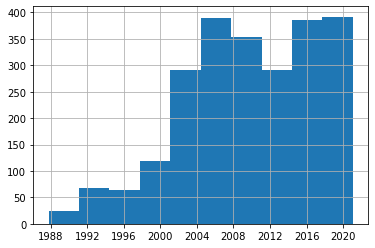

In [866]:
cov_outcomes_df.loc[filter_ss, 'datetime'].hist()

<AxesSubplot:>

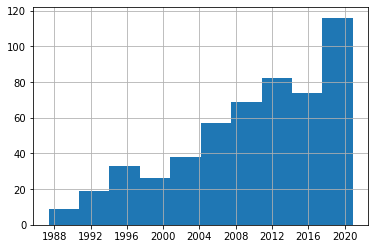

In [870]:
cov_outcomes_df.loc[filter_f4, 'datetime'].hist()

# HCC EMPIS

In [364]:
nlp_cirrhosis = pd.read_csv('/Users/pkc17/MGH/Liver_RPDR_analysis/NLP_cirrhosis_cohort_biobank_plasma_raw.csv', 
                            index_col=0)

In [365]:
nlp_cirrhosis

,EMPI,MRN,BIOBANK,AMGEN_657,GENOTYPED,SERUM,PLASMA
40,100054939,675222,Y,NaN,Y,Y,Y
60,100641859,3383102,Y,NaN,Y,Y,Y
61,100592091,3301201,Y,Y,Y,Y,Y
64,106961923,4210636,Y,NaN,Y,Y,Y
103,106273187,1209628,Y,NaN,Y,Y,Y
...,...,...,...,...,...,...,...
5478,110959594,10829761,NaN,NaN,NaN,NaN,NaN
5480,111103362,5453652,NaN,NaN,NaN,NaN,NaN
5481,111082098,5685048,NaN,NaN,NaN,NaN,NaN
5482,111076602,5681654,NaN,NaN,NaN,NaN,NaN


In [325]:
hcc_codes = {'ICD9': ['155.0', '155.2'], 'ICD10': ['C22.0', 'C22.9']}

In [344]:
filter_hcc_icd9 = (dia_df_liv['Code_Type']=='ICD9')&(dia_df_liv['Code'].isin(hcc_codes['ICD9']))
filter_hcc_icd10 = (dia_df_liv['Code_Type']=='ICD10')&(dia_df_liv['Code'].isin(hcc_codes['ICD10']))

In [357]:
dia_df_liv_hcc = dia_df_liv[filter_hcc_icd9|filter_hcc_icd10].copy()
dia_df_liv_hcc['HCC'] = 'Y'

In [358]:
dia_df_liv_hcc = (
    dia_df_liv_hcc
    .sort_values(['MRN','datetime'])
    .drop_duplicates('MRN', keep='first')
    .loc[:, ['MRN','datetime','HCC']]
)

In [361]:
dia_df_liv_hcc['MRN'] = dia_df_liv_hcc['MRN'].astype(int)

In [366]:
nlp_cirrhosis_mod = pd.merge(nlp_cirrhosis, dia_df_liv_hcc, on='MRN', how='left')

In [370]:
nlp_cirrhosis_mod.rename(columns={'datetime':'HCC_dx_date'}, inplace=True)

In [371]:
nlp_cirrhosis_mod.to_csv('/Users/pkc17/MGH/Liver_RPDR_analysis/NLP_cirrhosis_cohort_biobank_plasma.csv', index=False)

In [338]:
nlp_cirrhosis['MRN'].nunique()

5484

In [401]:
nlp_cirrhosis_mod[nlp_cirrhosis_mod['MRN']==10035950]

,EMPI,MRN,BIOBANK,AMGEN_657,GENOTYPED,SERUM,PLASMA,HCC_dx_date,HCC


In [ ]:
10035129
115355140

In [403]:
nlp_cirrhosis_mod.sort_values('EMPI')

,EMPI,MRN,BIOBANK,AMGEN_657,GENOTYPED,SERUM,PLASMA,HCC_dx_date,HCC
483,100000860,194886,NaN,NaN,NaN,NaN,NaN,1999-12-25,Y
2840,100002042,432658,NaN,NaN,NaN,NaN,NaN,1997-07-14,Y
1133,100002791,531293,NaN,NaN,NaN,NaN,NaN,NaT,NaN
3824,100002992,555672,NaN,NaN,NaN,NaN,NaN,NaT,NaN
3029,100003299,2156994,NaN,NaN,NaN,NaN,NaN,NaT,NaN
...,...,...,...,...,...,...,...,...,...
3648,115326166,3772844,NaN,NaN,NaN,NaN,NaN,NaT,NaN
795,115328428,7194548,NaN,NaN,NaN,NaN,NaN,NaT,NaN
5009,115329519,7194579,NaN,NaN,NaN,NaN,NaN,NaT,NaN
3808,115337647,7205269,NaN,NaN,NaN,NaN,NaN,NaT,NaN


In [ ]:
nlp_cirrhosis_mod

In [409]:
sum(path_merged['EMPI'].drop_duplicates().isin(nlp_cirrhosis_mod['EMPI'].astype(str)))

5362

In [410]:
path_merged['EMPI'].min()

'100000151'

# Bariatric surgery

In [171]:
brsrg_codes = {'ICD9': ['44.31', '44.38', '44.39', '44.95', 'V45.86', 'V45.75'], 
                  'ICD10': ['Z98.84', 'Z90.3'],
                  'CPT': ['43770', '43771', '43772', '43773', '43774', '43775', '43842', '43843',
                         '43846', '43847', '43848']}

In [172]:
brsrg_codes = {'ICD9': ['V45.86', 'V45.75'], 
                  'ICD10': ['Z98.84', 'Z90.3'],
                  'CPT': ['43770', '43771', '43772', '43773', '43774', '43775', '43842', '43843',
                         '43846', '43847', '43848']}

In [183]:
filter_brsrg_icd = (
        ((dia_df_liv['Code_Type']=='ICD9')&
         (dia_df_liv['Code'].isin(brsrg_codes['ICD9']))) |
    
        ((dia_df_liv['Code_Type']=='ICD10')
         &(dia_df_liv['Code'].isin(brsrg_codes['ICD10'])))
    )

brsrg_diag_df = (
        dia_df_liv[filter_brsrg_icd]
        .sort_values(['EMPI','datetime'])
        .loc[:,['EMPI','datetime']]
        .drop_duplicates(['EMPI', 'datetime'])
        .rename(columns={'datetime':'datetime_bar_diag'})
    ).copy()

brsrg_diag_df['brsurg_dia'] = 1

In [184]:
filter_brsrg_cpt = (
        ((prc_df_liv['Code_Type']=='CPT')&
         (prc_df_liv['Code'].isin(brsrg_codes['CPT'])))
    )

brsrg_prc_df = (
        prc_df_liv[filter_brsrg_cpt]
        .sort_values(['EMPI','datetime'])
        .loc[:,['EMPI','datetime']]
        .drop_duplicates(['EMPI', 'datetime'])
    .rename(columns={'datetime':'datetime_bar_prc'})
    ).copy()

brsrg_prc_df['brsurg_prc'] = 1

In [220]:
brsrg_df = pd.merge_asof(path_nafld.sort_values('datetime'), 
              brsrg_diag_df.sort_values('datetime_bar_diag'), left_on='datetime', right_on='datetime_bar_diag', by='EMPI', 
              tolerance=pd.Timedelta("365 days"), direction='nearest')

brsrg_df = pd.merge_asof(brsrg_df.sort_values('datetime'), 
              brsrg_prc_df.sort_values('datetime_bar_prc'), left_on='datetime', right_on='datetime_bar_prc', by='EMPI', 
              tolerance=pd.Timedelta("365 days"), direction='nearest')
 
brsrg_df['datetime_bar'] = brsrg_df[['datetime_bar_diag','datetime_bar_prc']].min(axis=1)
brsrg_df['bar_diff'] = (brsrg_df['datetime_bar']-brsrg_df['datetime']).dt.days

brsrg_df.loc[(brsrg_df['brsurg_dia']==1)|(brsrg_df['brsurg_prc']==1),'brsurg'] = 1

# CT Scans and Cirrhosis

In [167]:
ct_scans_df = pd.read_excel(
    '/Users/pkc17/MGH/CT Scan Cirrhosis/rad_df_liv_subset V2.xlsx', sheet_name='Contrast and Non-Con CT Scans')

ct_scans_df_noncon = pd.read_excel(
    '/Users/pkc17/MGH/CT Scan Cirrhosis/rad_df_liv_subset V2.xlsx', sheet_name='Non-Contrast CT Scans')

In [207]:
ct_scans_df['CT_all'] = True
ct_scans_df_noncon['CT_noncon'] = True

rad_df_liv_ct = rad_df_liv.copy()

rad_df_liv_ct = pd.merge(rad_df_liv_ct, ct_scans_df, 
                         on=['Mode', 'Group', 'Test_Description'], how='left').copy()
rad_df_liv_ct = pd.merge(rad_df_liv_ct, ct_scans_df_noncon, 
                         on=['Mode', 'Group', 'Test_Description'], how='left').copy()

rad_df_liv_ct = rad_df_liv_ct.sort_values(['EMPI', 'datetime']).rename(columns={'datetime': 'datetime_rad'})
rad_df_liv_ct = rad_df_liv_ct[rad_df_liv_ct['CT_all']==True].copy()

In [211]:
filter_cirrhosis = (path_df5_liv['cirrhosis']==True)|(path_df5_liv['fibrosis_stage_4']==4)

cirr_liv_df = path_df5_liv[filter_cirrhosis].sort_values(['EMPI','datetime']).drop_duplicates(['EMPI']).copy()
cirr_liv_df['Cirrhosis'] = True

cirr_liv_df = cirr_liv_df[['EMPI','datetime','Cirrhosis']].copy()
cirr_liv_df = cirr_liv_df.rename(columns={'datetime': 'datetime_pat'})

In [212]:
rad_df_liv_ct = pd.merge_asof(rad_df_liv_ct.sort_values(['datetime_rad']), cirr_liv_df.sort_values(['datetime_pat']), 
              left_on='datetime_rad', right_on='datetime_pat', by='EMPI', direction='backward')

In [213]:
rad_df_liv_ct_all = rad_df_liv_ct[(rad_df_liv_ct['Cirrhosis']==True)].copy()
rad_df_liv_ct_noncon = rad_df_liv_ct[(rad_df_liv_ct['Cirrhosis']==True)&(rad_df_liv_ct['CT_noncon']==True)].copy()

rad_df_liv_ct_all = rad_df_liv_ct_all.sort_values(['EMPI', 'datetime_rad']).drop_duplicates('EMPI').copy()
rad_df_liv_ct_noncon = rad_df_liv_ct_noncon.sort_values(['EMPI', 'datetime_rad']).drop_duplicates('EMPI').copy()

rad_df_liv_ct_all = rad_df_liv_ct_all.drop(columns=['Date','CT_all','CT_noncon','Cirrhosis'])
rad_df_liv_ct_noncon = rad_df_liv_ct_noncon.drop(columns=['Date','CT_all','CT_noncon','Cirrhosis'])

In [231]:
rad_df_liv_ct_all.to_excel('/Users/pkc17/MGH/CT Scan Cirrhosis/cirr_ct_both.xlsx', index=False)
rad_df_liv_ct_noncon.to_excel('/Users/pkc17/MGH/CT Scan Cirrhosis/cirr_ct_noncon.xlsx', index=False)

In [234]:
rad_df_liv_ct_noncon

,EMPI,EPIC_PMRN,MRN_Type,MRN,Mode,Group,Test_Code,Test_Description,Accession_Number,Provider,Clinic,Hospital,Inpatient_Outpatient,datetime_rad,datetime_pat,Cirrhosis
135096,100006103,10040052028,BWH,00930537,CT,ABD,BRRADCT.AB.ABDPEL,CT ABDOMEN/PELVIS (Test:CT.AB.ABDPEL),E4377166,"Kayden, Stephanie R, MD, MPH",BWH EMERGENCY,BWH,Outpatient-Emergency,2017-03-03,1988-02-08 00:00:00,True
131100,100006333,10040055823,BWH,00956060,CT,ABD,BRRADCT.AB.ABDPEL,CT ABDOMEN/PELVIS (Test:CT.AB.ABDPEL),E3437316,"Eyre, Andrew J, MD",BWH EMERGENCY,BWH,Outpatient-Emergency,2016-10-27,2011-10-31 00:00:00,True
1300,100007560,10040075573,MGH,1714993,CT,ABD,MRRADCTABP-,CTAbdomenw/oCTPelvis w/o Con (Test:CTABP-),8536345,MGH:83249,not recorded,MGH,not recorded,2004-10-22,2000-08-30 00:00:00,True
103389,100009861,10040121054,BWH,01269059,CT,LEXTR,BRRADECT191,CT ABDOMEN/PELVIS W/O CONTRAS (Test:ECT191),A13849179,NaN,not recorded,BWH,Outpatient-Emergency,2014-07-24,2008-08-13 00:00:00,True
24890,100010873,10040146010,BWH,01354901,CT,ABD,BRRADCT007,CT SCAN ABDOMEN W/O CONTRAST (Test:CT007),A08418778,NaN,not recorded,BWH,not recorded,2007-07-19,2004-05-25 00:00:00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178709,115146605,10142332583,MGH,6972618,CT,SPLV,MRRADCT.AB.ABDPEL,CT ABDOMEN/PELVIS (Test:CT.AB.ABDPEL),E16164064,"Kimura, Shoko, MD",NaN,MGH,Inpatient,2020-07-07,2020-06-25 00:00:00,True
180320,115203606,10142910180,BWH,42638387,CT,ABD,BRRADCT.AB.ABDPEL,CT ABDOMEN/PELVIS (Test:CT.AB.ABDPEL),E16625008,"Farrell, Susan E, MD",BWH EMERGENCY,BWH,Outpatient-Emergency,2020-08-18,2020-07-30 00:00:00,True
182756,115261027,10143489655,MGH,7114530,CT,SPLV,MRRADCT.AB.ABDPEL,CT ABDOMEN/PELVIS (Test:CT.AB.ABDPEL),E17395497,"Darling, Lisa J, CNP",NaN,MGH,Inpatient,2020-10-27,2020-10-26 00:00:00,True
185206,115328428,10144172144,MGH,7194548,CT,SPLV,MRRADCT.AB.ABDPEL,CT ABDOMEN/PELVIS (Test:CT.AB.ABDPEL),E18140817,"Baker, Joanne E, CNP",NaN,MGH,Inpatient,2021-01-08,2020-12-23 14:47:00,True


In [229]:
rad_df_liv_ct_noncon['EMPI'].isin(rad_df_liv_ct_all['EMPI']).sum()

1541